In [36]:
%load_ext autoreload 
%autoreload 2
%matplotlib inline

import utils

import geopandas as gpd
import matplotlib.pyplot as plt
import glob
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd
import seaborn as sns
from scipy import stats
import numpy as np
from shapely.geometry import LineString, MultiLineString
import os
from matplotlib.collections import LineCollection
import os
from shapely.geometry import LineString
import matplotlib.patches as patches
from matplotlib.patches import Rectangle
from adjustText import adjust_text
from matplotlib_scalebar.scalebar import ScaleBar
from scipy.stats import ks_2samp
from shapely.geometry import Point


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


To do:

- Consider whether fault should be resampled to prevent roughness to be synthetically added by having more nodes pre-windowing
- Check that wiki epis have negative lons when appropriate

### Load and prepare data

In [37]:
supershear_list = ['Izmit_Kocaeli', 'Duzce', 'Tajikistan', 'Kunlun_Kokoxili', 'Palu', 'Yushu', 'Denali', 'Landers', 'San Francisco', 'Imperial1979','Elbistan', 'Maduo', 'Kahramanmaras', 'Myanmar', 'Balochistan','Wenchuan','Nuweiba']
fdhi_data = pd.read_csv('FDHI data/02_FDHI_FLATFILE_MEASUREMENTS_20220719.csv')
Wenchuan_data = fdhi_data[fdhi_data['eq_name'] == 'Wenchuan']
strike_slip_data = fdhi_data[fdhi_data['style'] == 'Strike-Slip']
# add Wenchuan to strike-slip data as potential supershear event
strike_slip_data = pd.concat([strike_slip_data, Wenchuan_data])

shapefiles = glob.glob('primary_shapefiles/*.shp')
shapefiles_dict = {}

for shp_file in shapefiles:    
    filename = shp_file.split('/')[-1]
    name = filename.replace('_main.shp', '').replace('.shp', '')
    gdf = gpd.read_file(shp_file)
    shapefiles_dict[name] = gdf


In [38]:
fdhi_data = pd.read_csv('FDHI data/02_FDHI_FLATFILE_MEASUREMENTS_20220719.csv')
utm_mapping = {}
for _, row in fdhi_data.iterrows():
    eq_name = row['eq_name']
    epsg_code = row['epsg_for_analysis']
    utm_mapping[eq_name] = epsg_code
manual_epsg = {
    'Maduo': 32647,  # UTM Zone 47N
    'Elbistan': 32638,  # UTM Zone 38N  
    'Kahramanmaras': 32637,  # UTM Zone 37N
    'Myanmar': 32646   # UTM Zone 46N
}
utm_mapping.update(manual_epsg)

Kahramanmaras
Denali
Myanmar
Kunlun_Kokoxili
Luzon
Balochistan
Maduo
Wenchuan
Palu
Izmit_Kocaeli


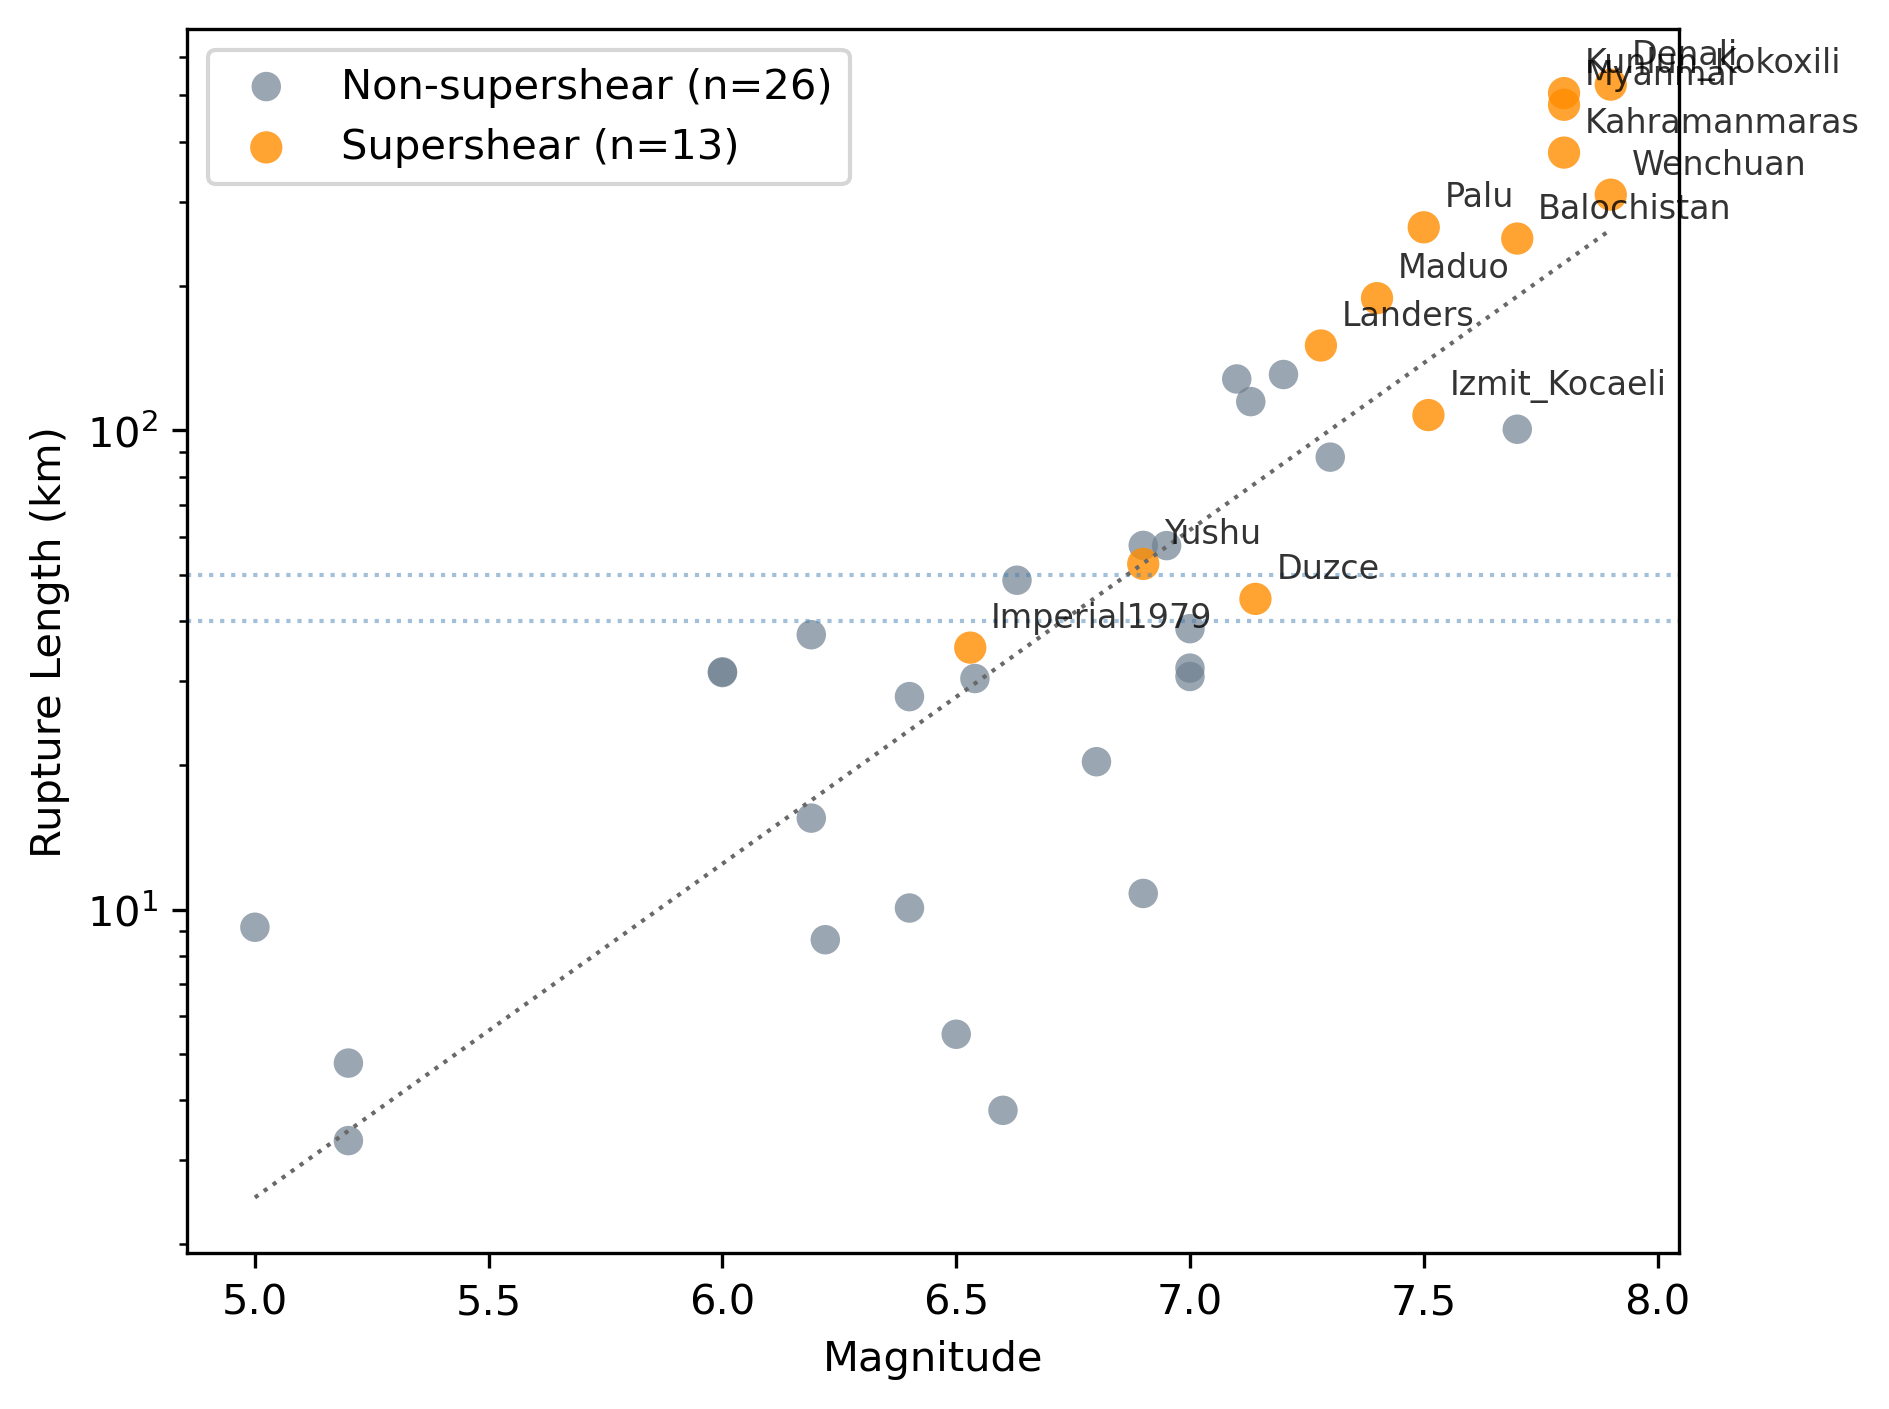

In [39]:
rupture_lengths = {}
supershear_lengths = []
non_supershear_lengths = []

for name, gdf in shapefiles_dict.items():
    try:
        if len(gdf) > 0 and not gdf.empty:
            if name in utm_mapping:
                epsg_code = utm_mapping[name]
                gdf_projected = gdf.to_crs(epsg=epsg_code)
            else:
                print(f"No UTM zone found for {name}, using Web Mercator")
                gdf_projected = gdf.to_crs(epsg=3857)
            
            total_length = 0
            for geom in gdf_projected.geometry:
                if hasattr(geom, 'length'):
                    total_length += geom.length
                elif hasattr(geom, 'geoms'):
                    for sub_geom in geom.geoms:
                        if hasattr(sub_geom, 'length'):
                            total_length += sub_geom.length
            
            total_length_km = total_length / 1000
            rupture_lengths[name] = total_length_km
            
            if name in supershear_list:
                supershear_lengths.append(total_length_km)
            else:
                non_supershear_lengths.append(total_length_km)
    except Exception as e:
        print(f"Error calculating length for {name}: {e}")


magnitude_mapping = {}
for _, row in fdhi_data.iterrows():
    eq_name = row['eq_name']
    magnitude = row['magnitude']
    magnitude_mapping[eq_name] = magnitude

manual_magnitudes = {
    'Maduo': 7.4,
    'Elazig': 7.6,
    'Kahramanmaras': 7.8,
    'Myanmar': 7.8
}

magnitude_mapping.update(manual_magnitudes)

supershear_lengths_plot = []
supershear_magnitudes_plot = []
non_supershear_lengths_plot = []
non_supershear_magnitudes_plot = []

for name, length in rupture_lengths.items():
    if name in magnitude_mapping:
        magnitude = magnitude_mapping[name]
        if name in supershear_list:
            supershear_lengths_plot.append(length)
            supershear_magnitudes_plot.append(magnitude)
        else:
            non_supershear_lengths_plot.append(length)
            non_supershear_magnitudes_plot.append(magnitude)
        if magnitude>7.3:
            print(name)

fig, ax = plt.subplots(dpi=300)
ax.scatter(non_supershear_magnitudes_plot, non_supershear_lengths_plot, 
        c='slategray', alpha=0.7, s=50, edgecolor='none', label=f'Non-supershear (n={len(non_supershear_lengths_plot)})')
ax.scatter(supershear_magnitudes_plot, supershear_lengths_plot, 
        c='darkorange', alpha=0.8, s=60, edgecolor='none', label=f'Supershear (n={len(supershear_lengths_plot)})')
all_magnitudes = non_supershear_magnitudes_plot + supershear_magnitudes_plot
all_lengths = non_supershear_lengths_plot + supershear_lengths_plot

# linear regression
slope, intercept, r_value, p_value, std_err = stats.linregress(all_magnitudes, np.log10(all_lengths))
x_reg = np.linspace(min(all_magnitudes), max(all_magnitudes), 100)
y_reg_log = slope * x_reg + intercept
y_reg = 10**y_reg_log
ax.plot(x_reg, y_reg, linestyle=':',c='dimgray', linewidth=1)

ax.axhline(y=50, linestyle=':',c='steelblue', alpha=0.5, linewidth=1, zorder=1) # backprojection length res limit - Bao
ax.axhline(y=40, linestyle=':',c='steelblue', alpha=0.5, linewidth=1, zorder=1) # length required for observable Mach cone - Vallee and Dunham, 2012

for name, length in rupture_lengths.items():
    if name in magnitude_mapping and name in supershear_list:
        magnitude = magnitude_mapping[name]
        ax.annotate(name, (magnitude, length), 
                xytext=(5, 5), textcoords='offset points', 
                fontsize=8, alpha=0.8)

ax.set_yscale('log')
ax.set_xlabel('Magnitude')
ax.set_ylabel('Rupture Length (km)')
ax.legend()
plt.tight_layout()
plt.savefig('Figures/rupture_length_vs_mag.pdf',dpi=300)


### Measure roughness of simplified fault traces over window

In [40]:
# load data
rupture_vel_points = pd.read_excel('supershear_segment_data/supershear_segments.xlsx')  # Event, init, end, type
shapefiles = glob.glob('Output_LCP/*_LCP_line.shp')
window_length = 5000 # m
alpha_data_all_events = []

In [41]:
for shp in shapefiles:
    eq_name = os.path.basename(shp).replace('_LCP_line.shp', '') # simplified fault trace from LCP method 
    gdf = gpd.read_file(shp)
    epsg_code = utm_mapping.get(eq_name)
    gdf_proj = gdf.to_crs(epsg=int(epsg_code))
    line = gdf_proj.geometry.iloc[0] # simplified fault trace 
    coords = np.array(line.coords) 

    ##################### Establish positions along fault and measure fault length
    segment_dists = np.diff(coords, axis=0) # distance between segment points along LPC line
    seg_lengths = np.hypot(segment_dists[:, 0], segment_dists[:, 1]) # segment distance
    cumdist_fault = np.concatenate(([0.0], np.cumsum(seg_lengths))) # calc cumulative distance along line 
    total_length = cumdist_fault[-1]
    if total_length < window_length: # exclude events with total length < window length
        continue
    # plt.figure()
    # plt.hist(segment_dists) # for debugging
    
    ##################### Start sliding window at each vertex
    for start_idx in range(len(coords) - 1):
        start_window = cumdist_fault[start_idx] # pick segment start
        end_window = start_window + window_length # windowing
        if end_window > total_length:
            break # stop when fault runs out
        
        end_idx = np.searchsorted(cumdist_fault, end_window, side='left') # index of end of last window along fault
        
        # build windows
        if cumdist_fault[end_idx] > end_window: # if end of window is not at a vertex, interpolate
            prev_point = cumdist_fault[end_idx - 1]
            next_point = cumdist_fault[end_idx]
            t = (end_window - prev_point) / (next_point - prev_point) if next_point > prev_point else 0.0 # interp param - where are we along line?
            interp_point = coords[end_idx - 1] + t * (coords[end_idx] - coords[end_idx - 1])
            window_coords = np.vstack([coords[start_idx:end_idx], interp_point])
        else:
            window_coords = coords[start_idx:end_idx + 1] # if end of window is at a vertex, use segment
    
    ##################### Calculate roughness and alpha of each window
        h_rms = utils.compute_rms_fault(window_coords) # 6 min ish for all events
        alpha = h_rms / window_length 
        
    ##################### Save alpha values at position in middle of window for later analysis
        window_center_distance = start_window + window_length / 2 # window center
        center_idx = np.searchsorted(cumdist_fault, window_center_distance, side='left')
        if center_idx >= len(coords):
            center_idx = len(coords) - 1
        elif center_idx > 0 and cumdist_fault[center_idx] > window_center_distance:
            # Interpolate between center_idx-1 and center_idx
            prev_point = cumdist_fault[center_idx - 1]
            next_point = cumdist_fault[center_idx]
            if next_point > prev_point:
                t = (window_center_distance - prev_point) / (next_point - prev_point) # interp param - where are we along line?
                center_coords = coords[center_idx - 1] + t * (coords[center_idx] - coords[center_idx - 1])
            else:
                center_coords = coords[center_idx - 1]
        else:
            center_coords = coords[center_idx]
            
    ##################### Store window info for event with UTM coordinates
        alpha_data_all_events.append({
            'event': eq_name,
            'window_start_position': start_window,
            'window_center_position': window_center_distance, 
            'alpha': alpha,
            'utm_x': center_coords[0],
            'utm_y': center_coords[1],
            'epsg_code': epsg_code
        })
    
alpha_data_all_events_df = pd.DataFrame(alpha_data_all_events)

### Define whether each segment is sub, supershear, or a bounding segment

In [42]:
alpha_data_all_events_segment_type= utils.classify_alpha_points(alpha_data_all_events_df, rupture_vel_points, utm_mapping, window_length)

### Map of segments and alphas

/var/folders/kg/j5ms0y1x28l_gm2jtsf5j4pr0000gn/T/ipykernel_43014/1111633887.py:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 4), dpi=150)


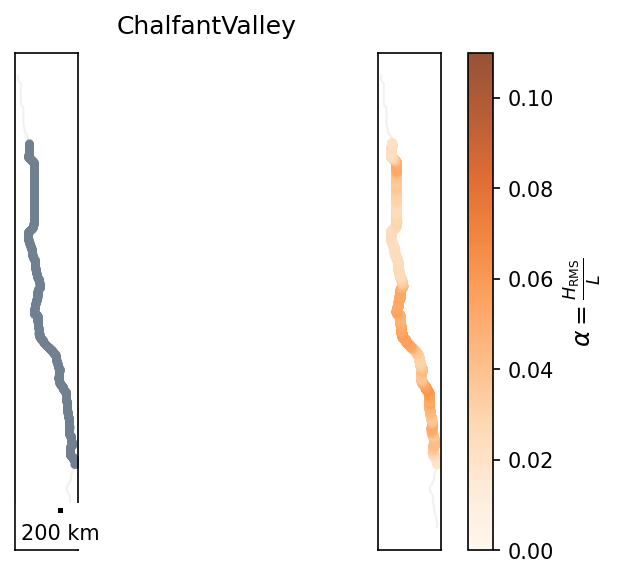

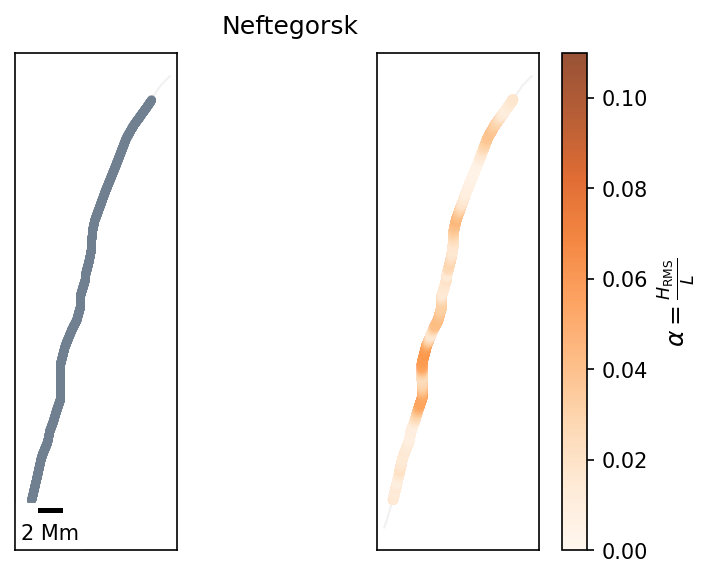

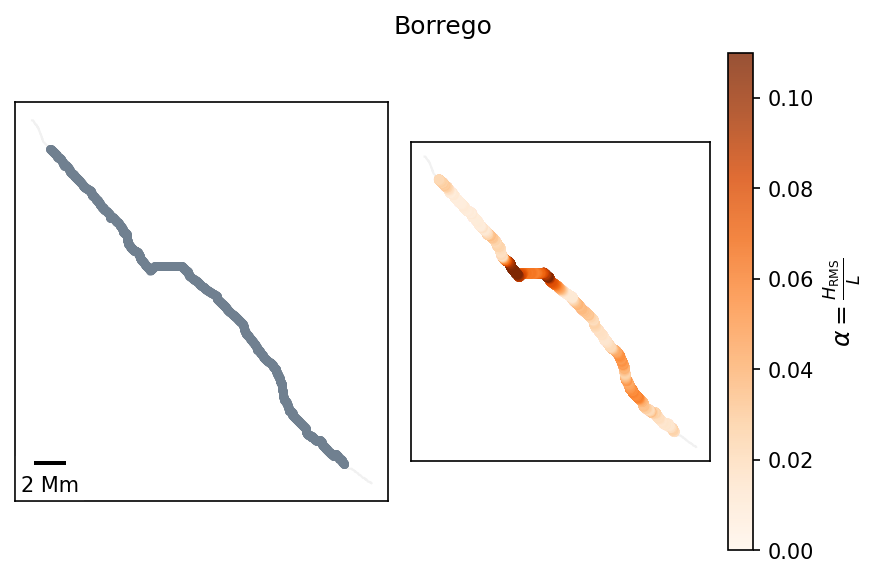

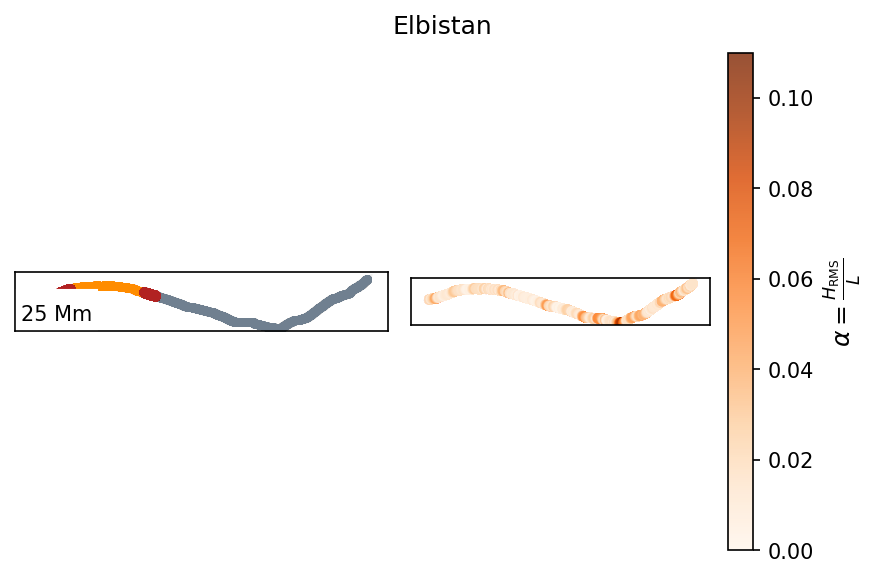

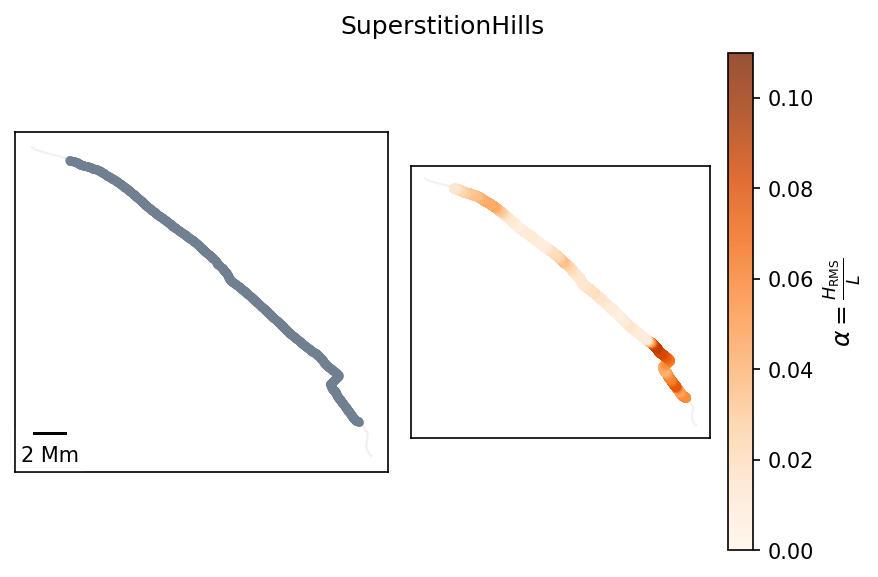

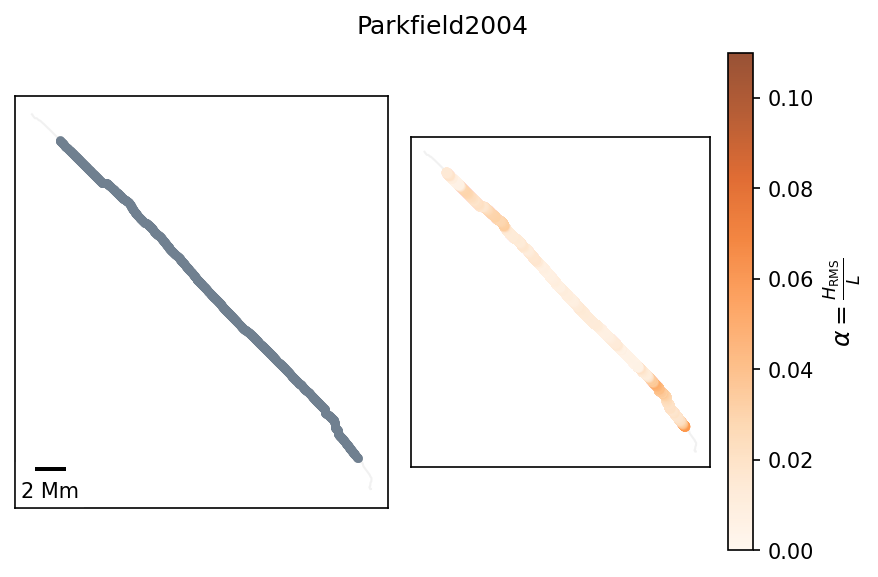

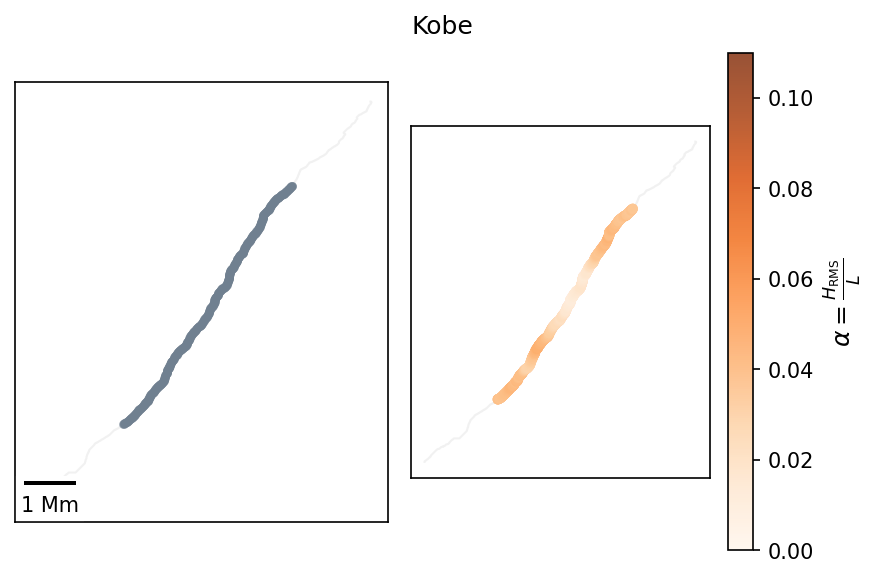

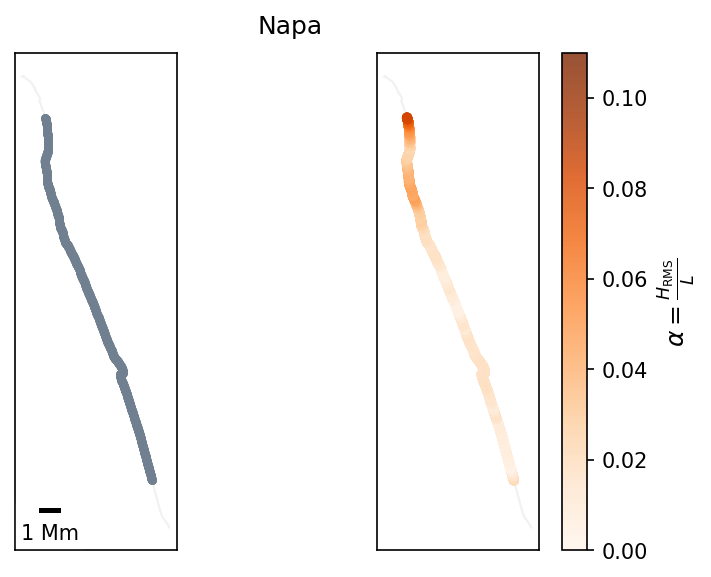

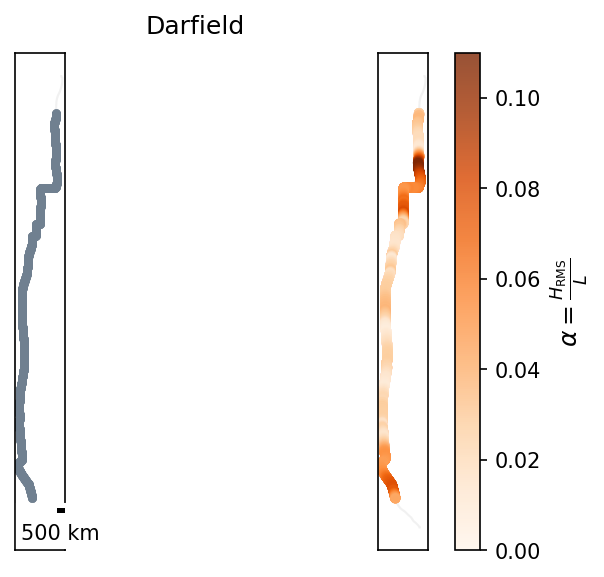

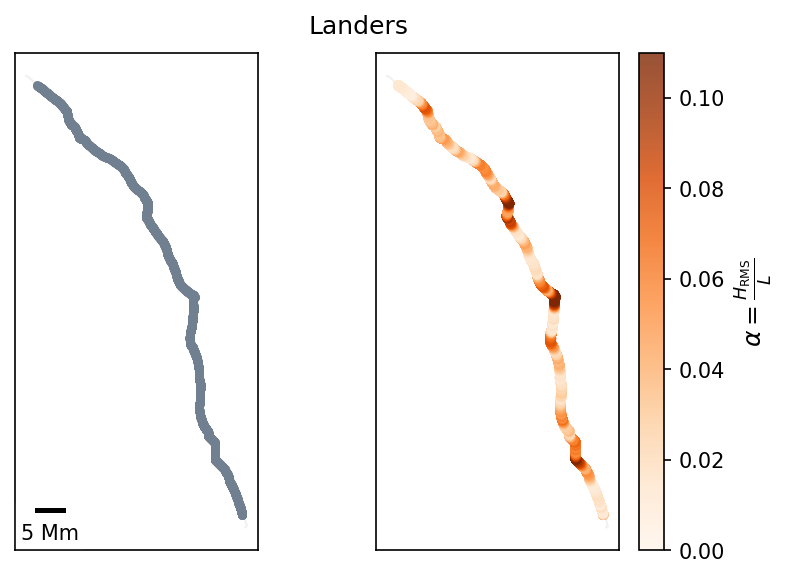

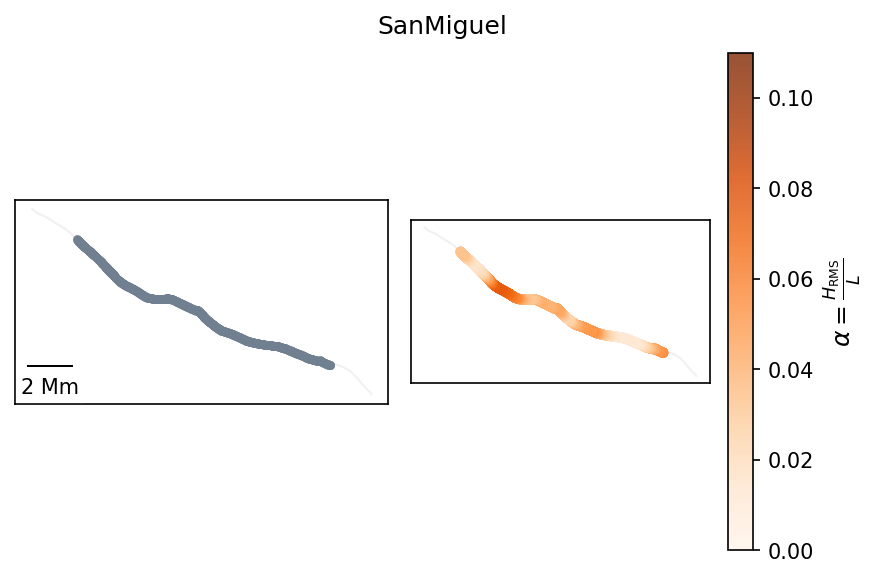

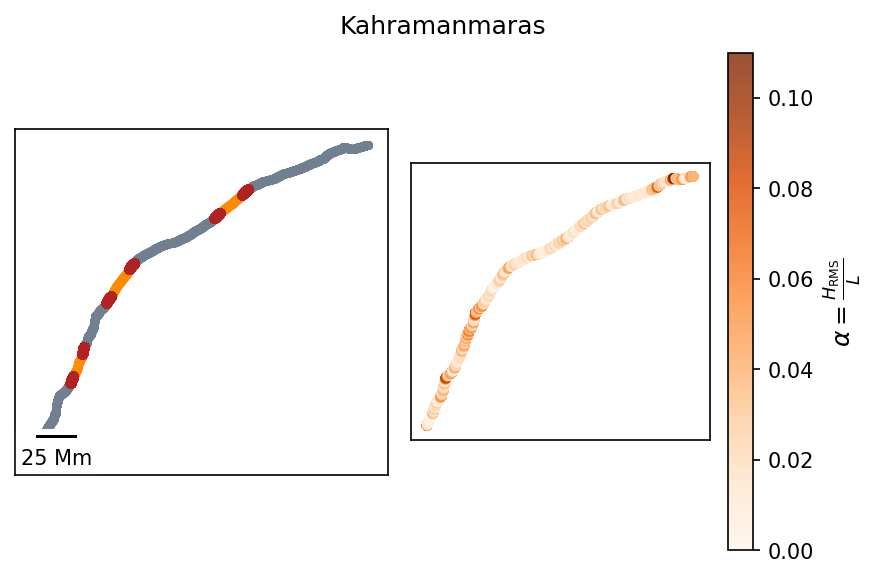

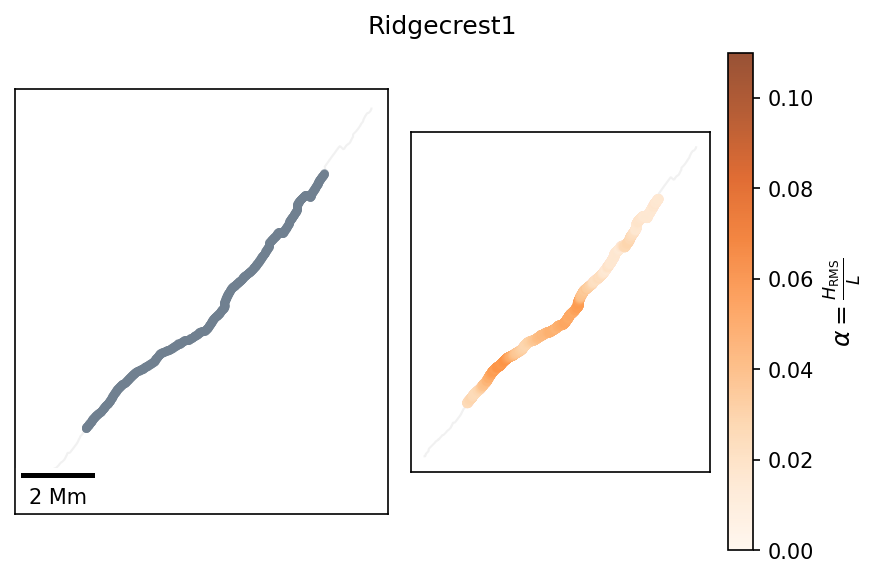

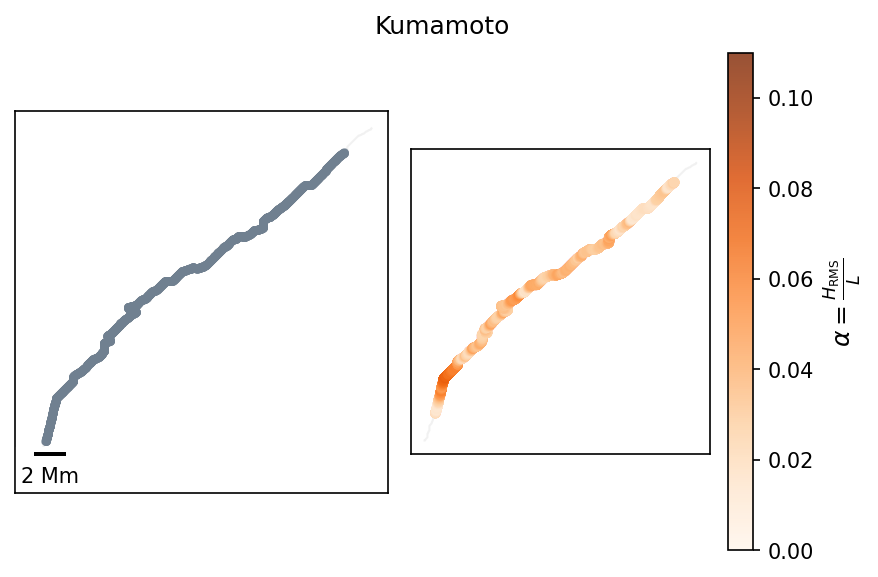

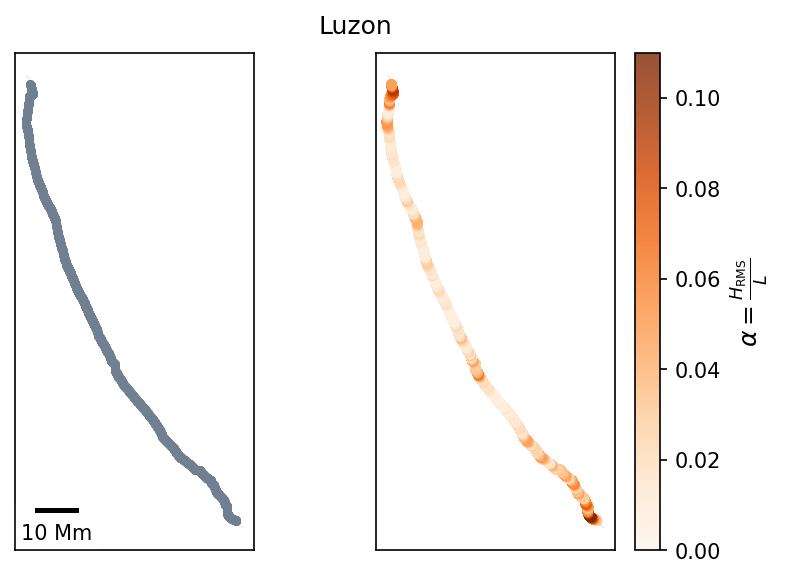

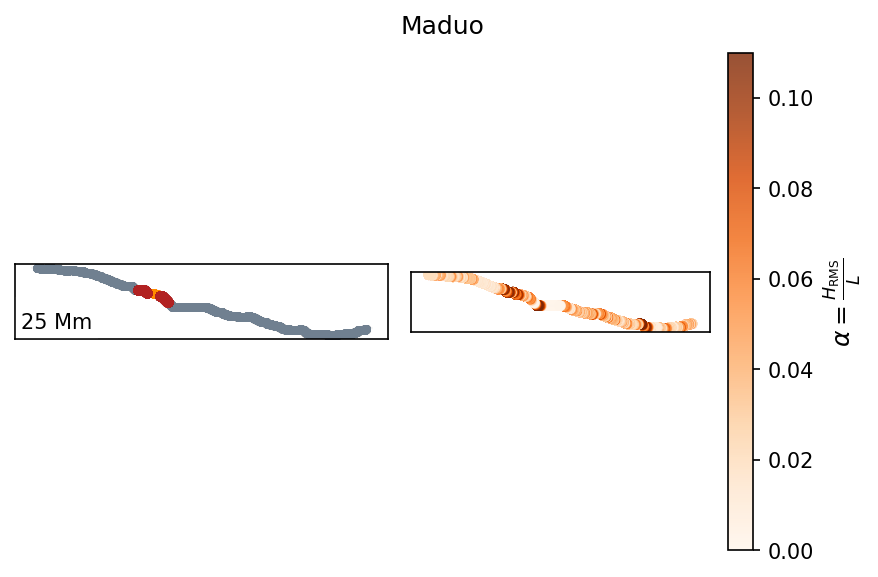

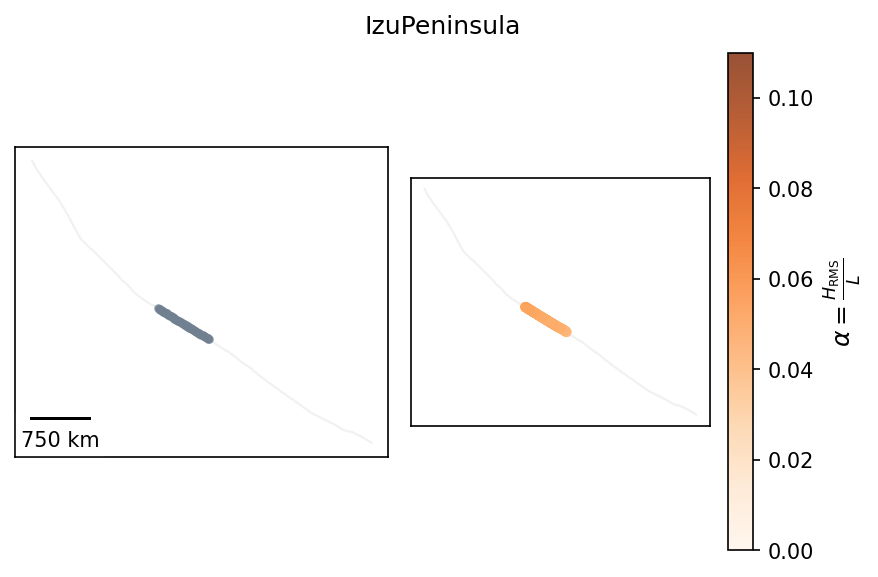

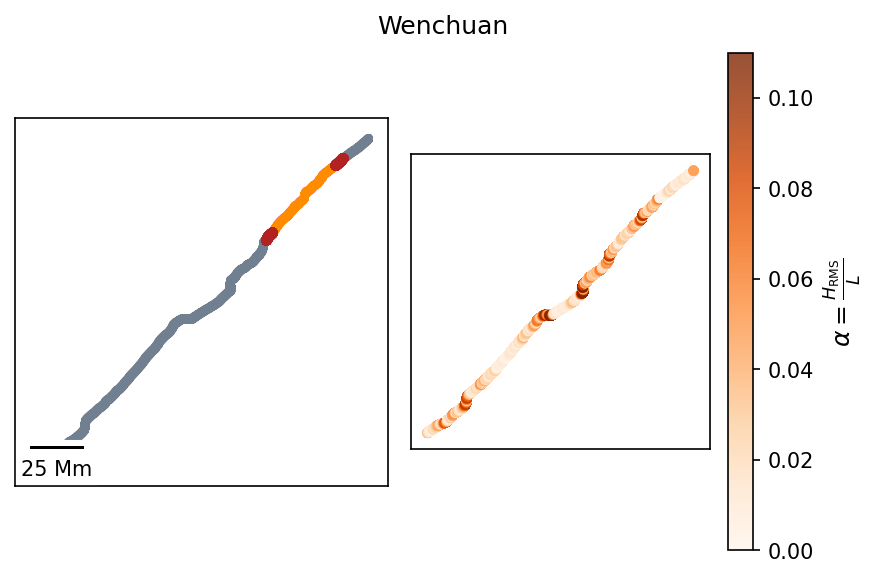

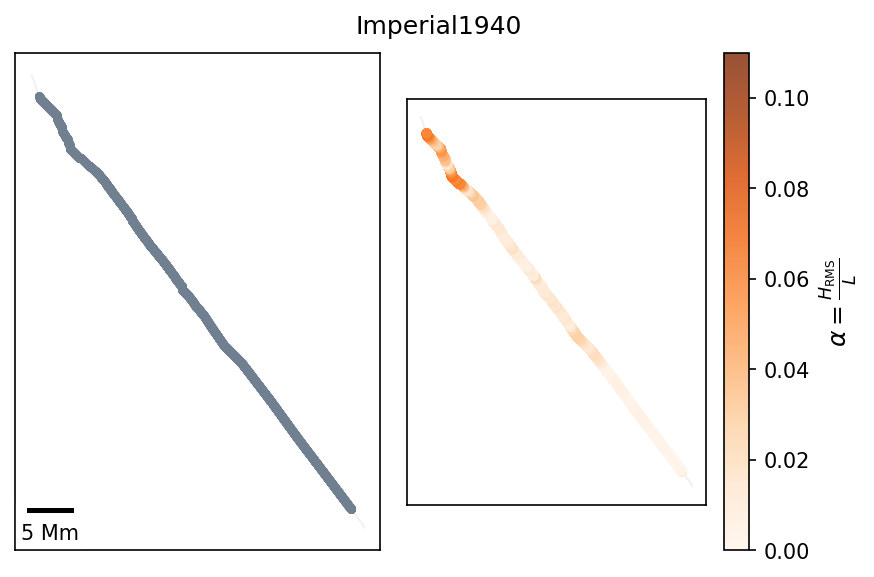

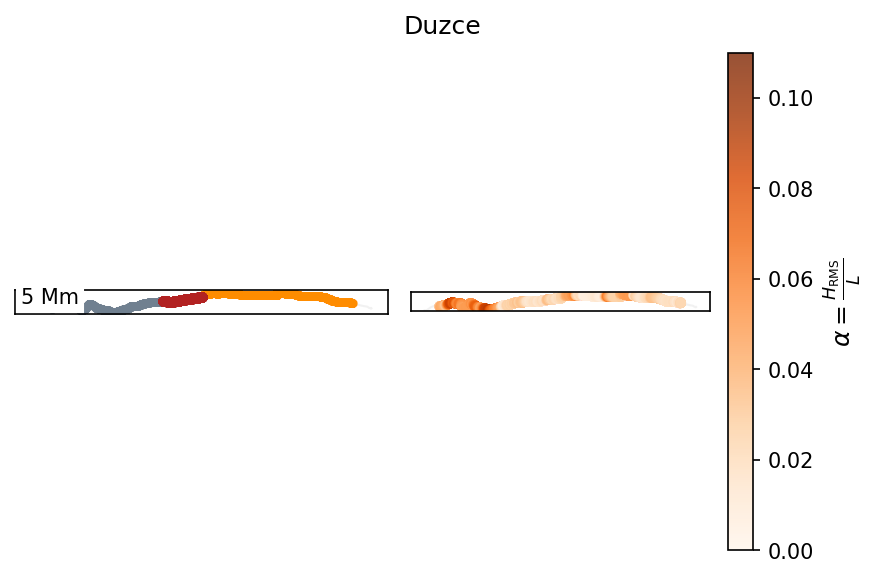

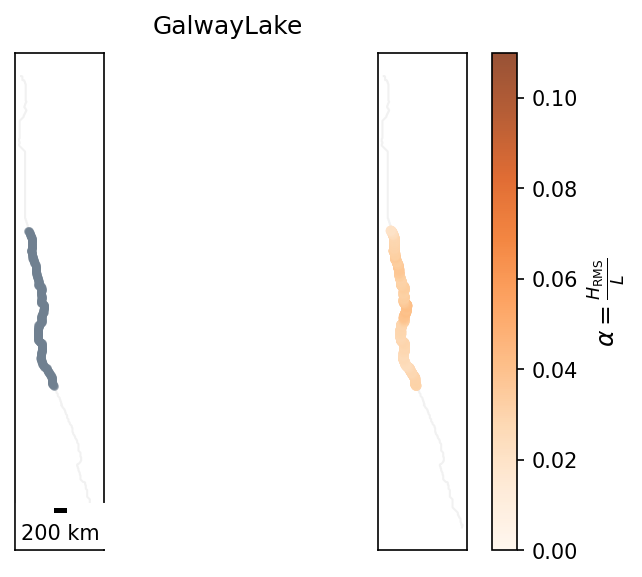

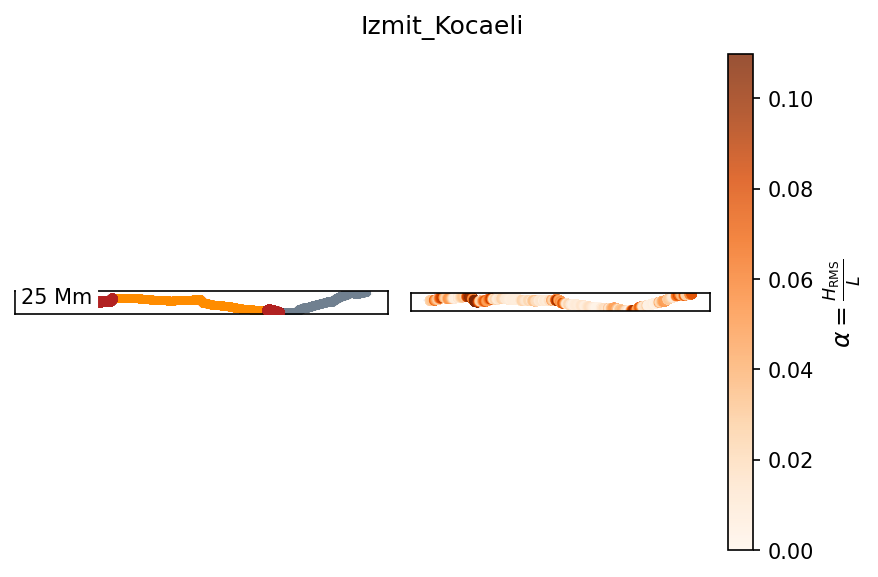

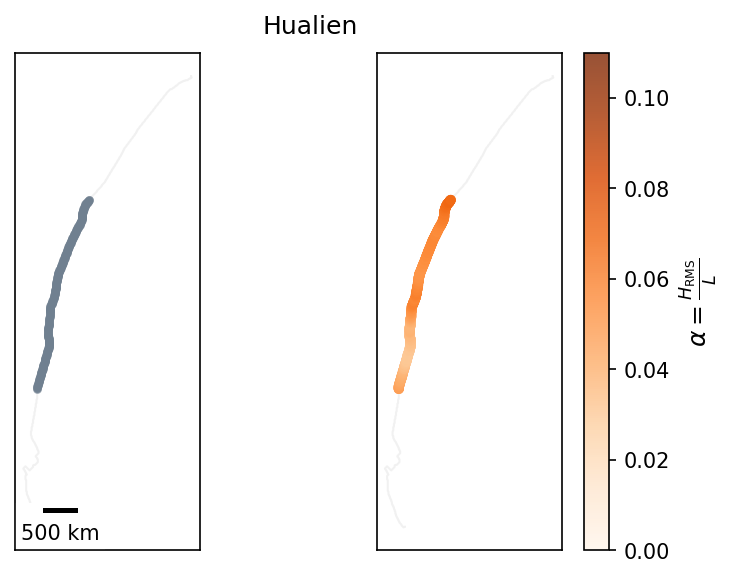

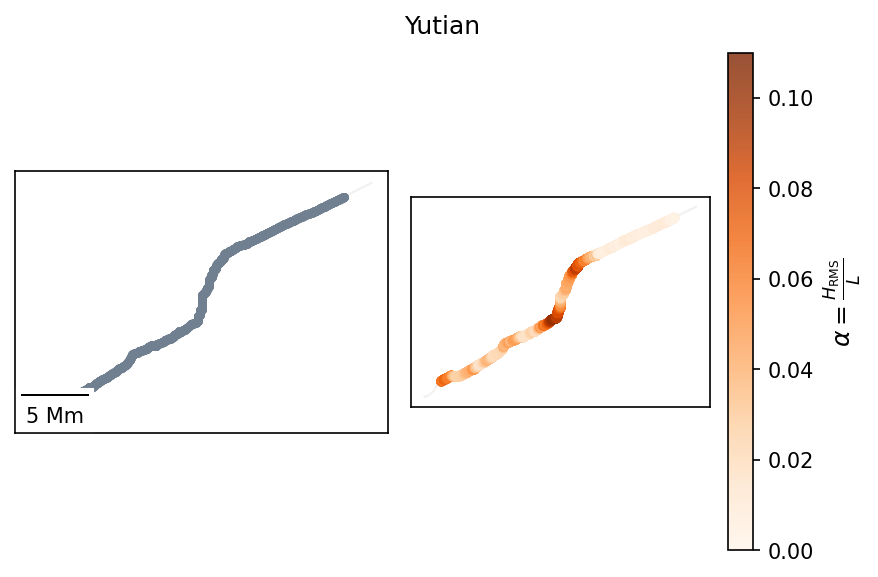

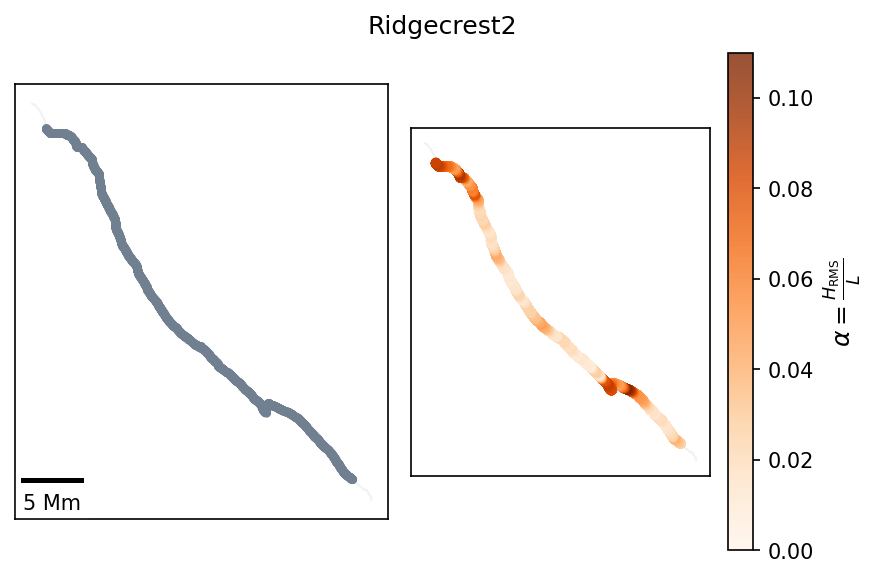

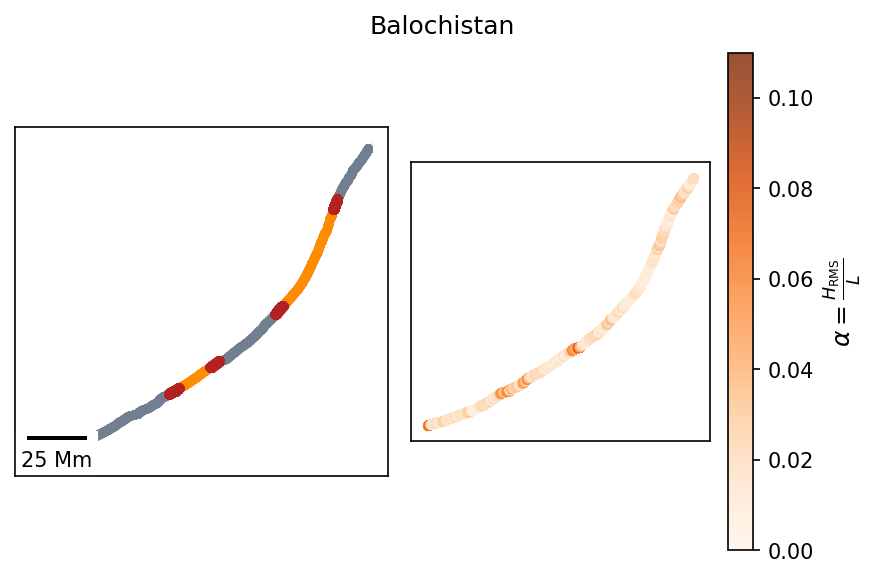

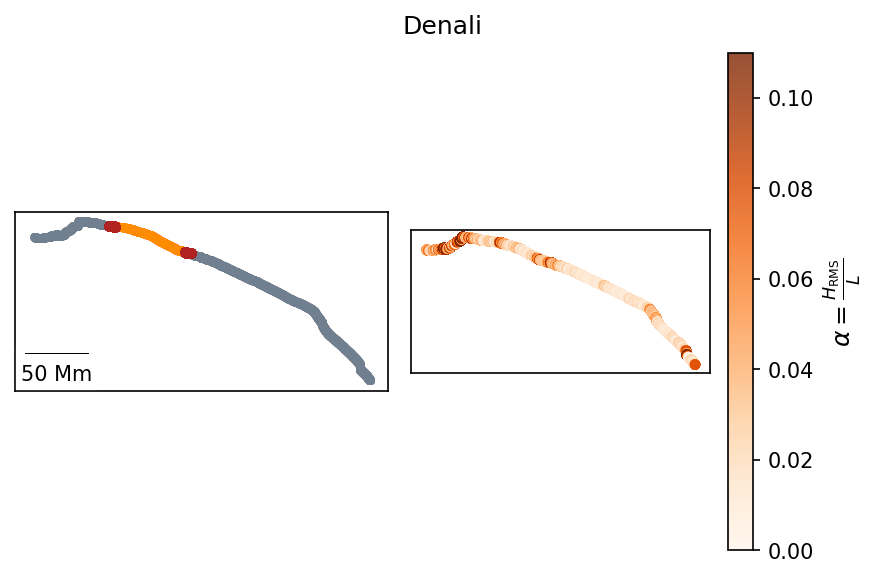

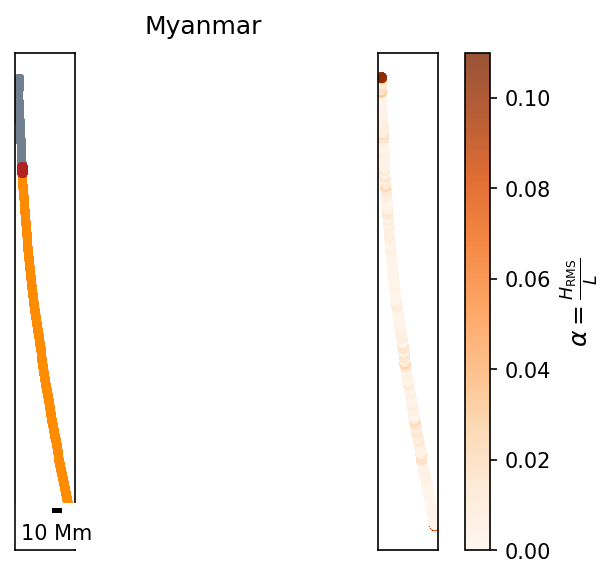

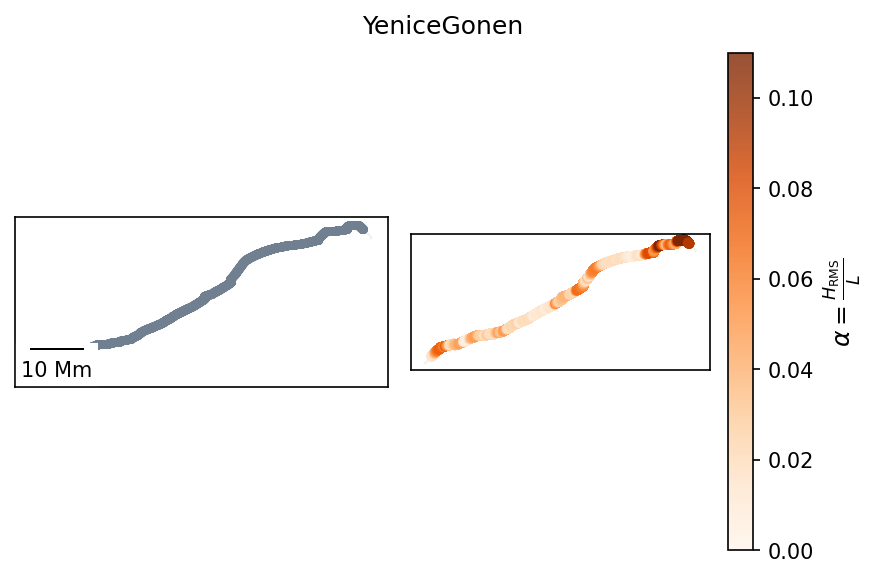

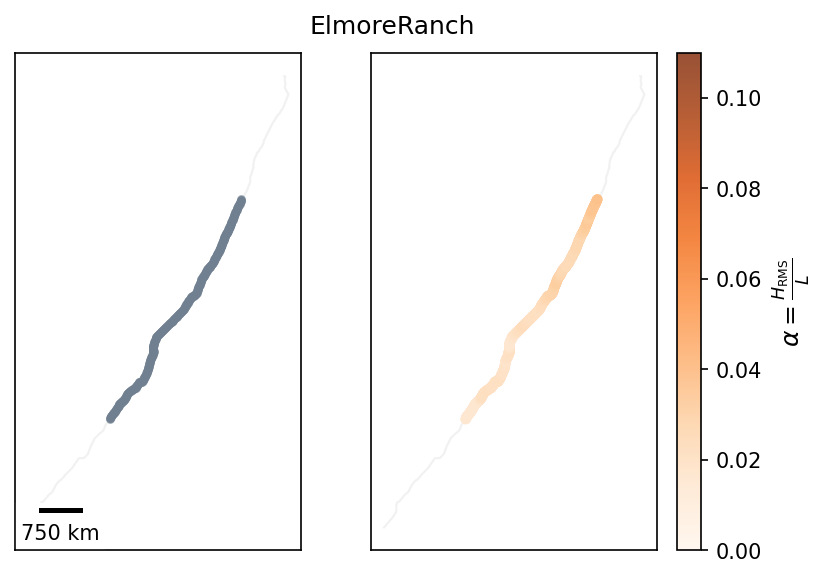

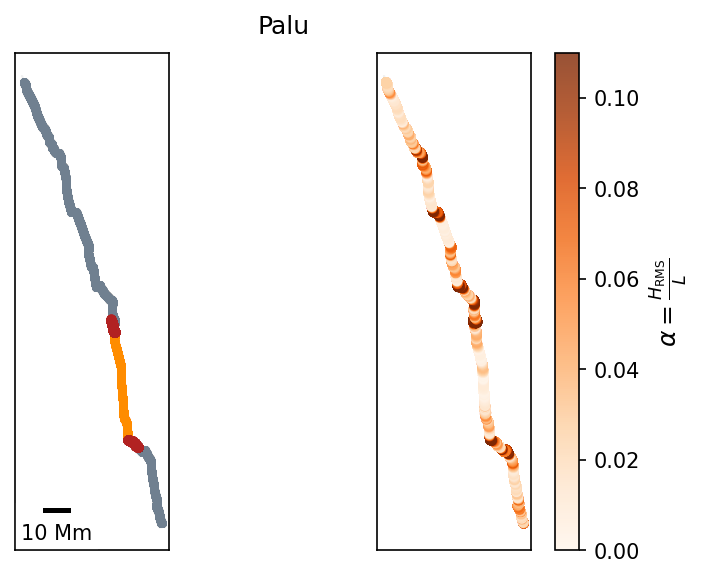

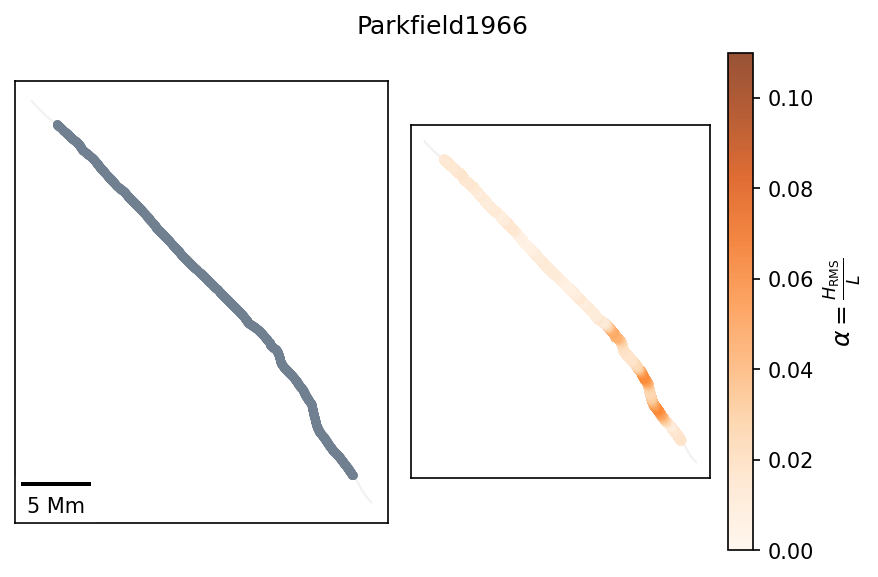

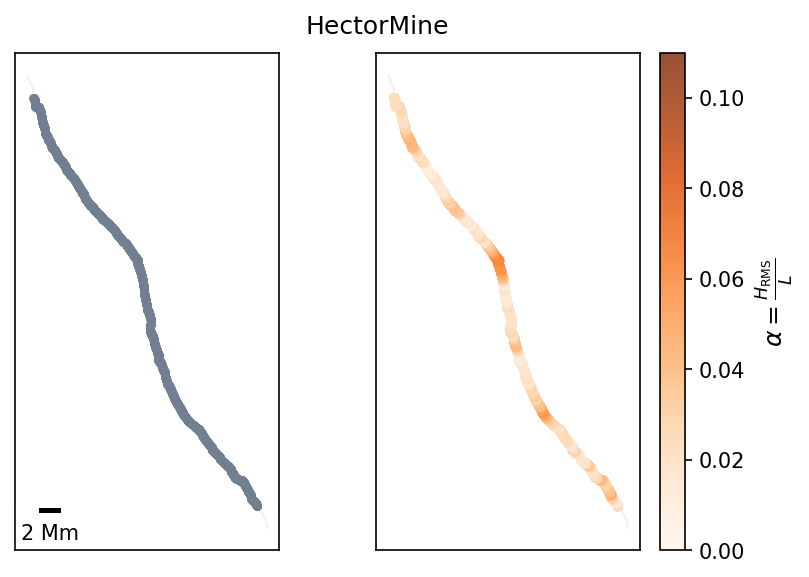

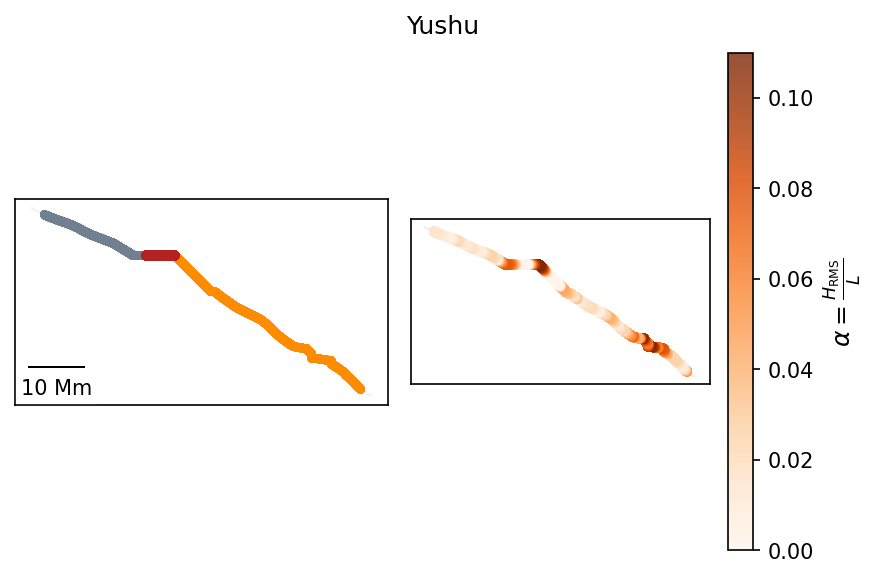

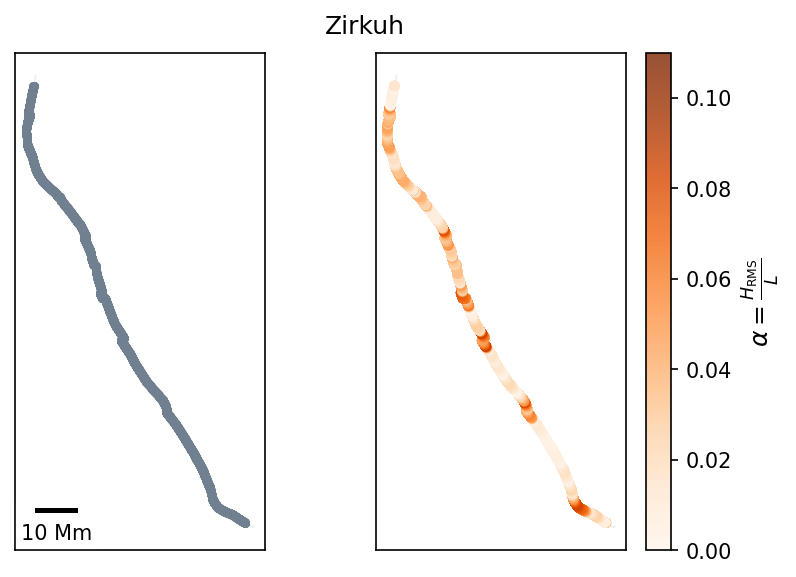

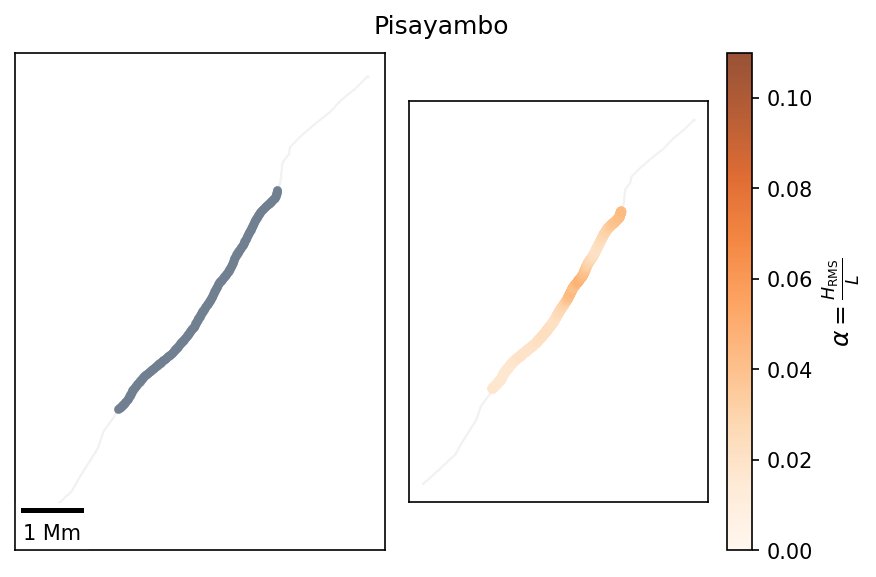

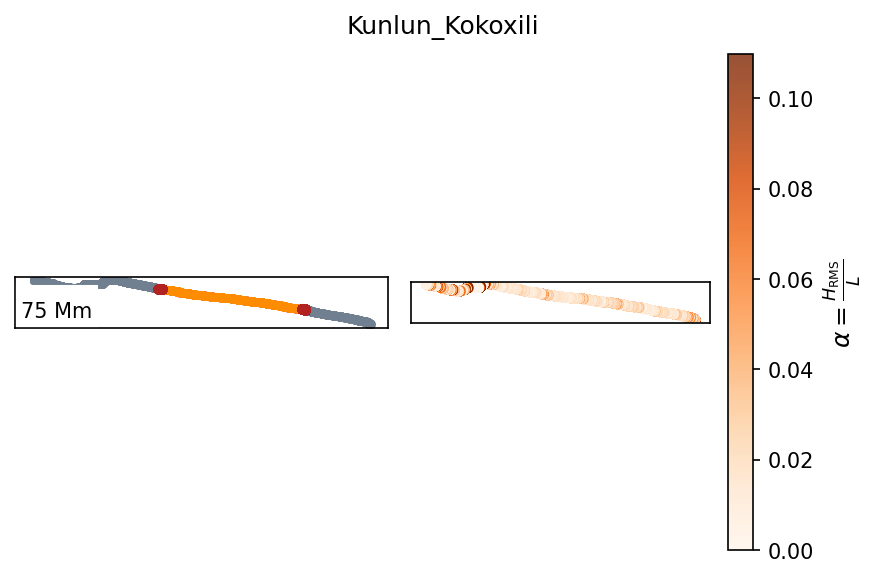

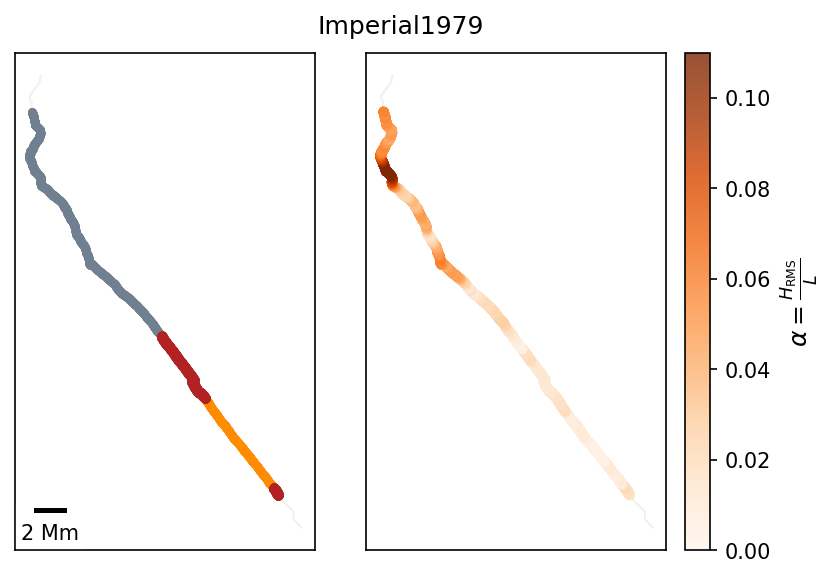

In [43]:
segment_colors = {
    'subshear': 'slategray',
    'supershear': 'darkorange', 
    'boundary_segment': 'firebrick',
    'unclassified': 'lightgray'
}

alpha_cmap = plt.cm.Oranges
events = alpha_data_all_events_segment_type['event'].unique()

for event in events:
    event_data = alpha_data_all_events_segment_type[alpha_data_all_events_segment_type['event'] == event].copy()
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 4), dpi=150)
    shp_file = f'Output_LCP/{event}_LCP_line.shp'
    gdf = gpd.read_file(shp_file)
    epsg_code = utm_mapping.get(event)
    gdf_proj = gdf.to_crs(epsg=int(epsg_code))
        
    # rupture LPC in back
    line = gdf_proj.geometry.iloc[0]
    coords = np.array(line.coords)
    ax1.plot(coords[:, 0], coords[:, 1], 'lightgray', linewidth=1, alpha=0.3, zorder=1)
    ax2.plot(coords[:, 0], coords[:, 1], 'lightgray', linewidth=1, alpha=0.3, zorder=1)
    
    for segment_type in ['subshear', 'supershear', 'unclassified']:
    #################### subshear segments - boundaries too
        if segment_type == 'subshear':
            mask = (event_data['segment_type'] == segment_type) & (~event_data['boundary_segment'])
            subset = event_data[mask]
            ax1.scatter(subset['utm_x'], subset['utm_y'], 
                    c=segment_colors[segment_type], s=10, alpha=0.7, zorder=2,
                    label=f'{segment_type} ({len(subset)})')
        else:
    #################### subshear, supershear segments
            mask = event_data['segment_type'] == segment_type
            subset = event_data[mask]
            ax1.scatter(subset['utm_x'], subset['utm_y'], 
                    c=segment_colors[segment_type], s=10, alpha=0.7, zorder=2,
                    label=f'{segment_type} ({len(subset)})')
    
    #################### boundary segments
        boundary_mask = event_data['boundary_segment'] == True
        boundary_subset = event_data[boundary_mask]
        if len(boundary_subset) > 0:
            ax1.scatter(boundary_subset['utm_x'], boundary_subset['utm_y'], 
                    c=segment_colors['boundary_segment'], s=15, alpha=0.8, zorder=3,
                    label=f'boundary ({len(boundary_subset)})')

        scatter = ax2.scatter(event_data['utm_x'], event_data['utm_y'], 
                        c=event_data['alpha'], cmap=alpha_cmap, 
                        s=15, alpha=0.8, zorder=2, 
                        vmin=alpha_data_all_events_segment_type['alpha'].quantile(0.01),  #colortscaling based on all events
                        vmax=alpha_data_all_events_segment_type['alpha'].quantile(0.99))
    ax1.add_artist(ScaleBar(1, units='km', location='lower left')) 
    cbar = plt.colorbar(scatter, ax=ax2)
    cbar.set_label(r'$\alpha = \frac{H_{\mathrm{RMS}}}{L}$', fontsize=12)
        
    for ax in [ax1, ax2]:
        ax.set_aspect('equal')
        ax.ticklabel_format(style='sci', axis='both', scilimits=(0,0))
        ax.set_xticks([])
        ax.set_yticks([])

    fig.suptitle(f'{event}', fontsize=12, y=0.95)
    plt.tight_layout()
    plt.savefig(f'Figures/{event}_alpha_map.pdf', dpi=300)
    #plt.close() # so it doesn't choke up entire notebook

### Alpha distribution analysis

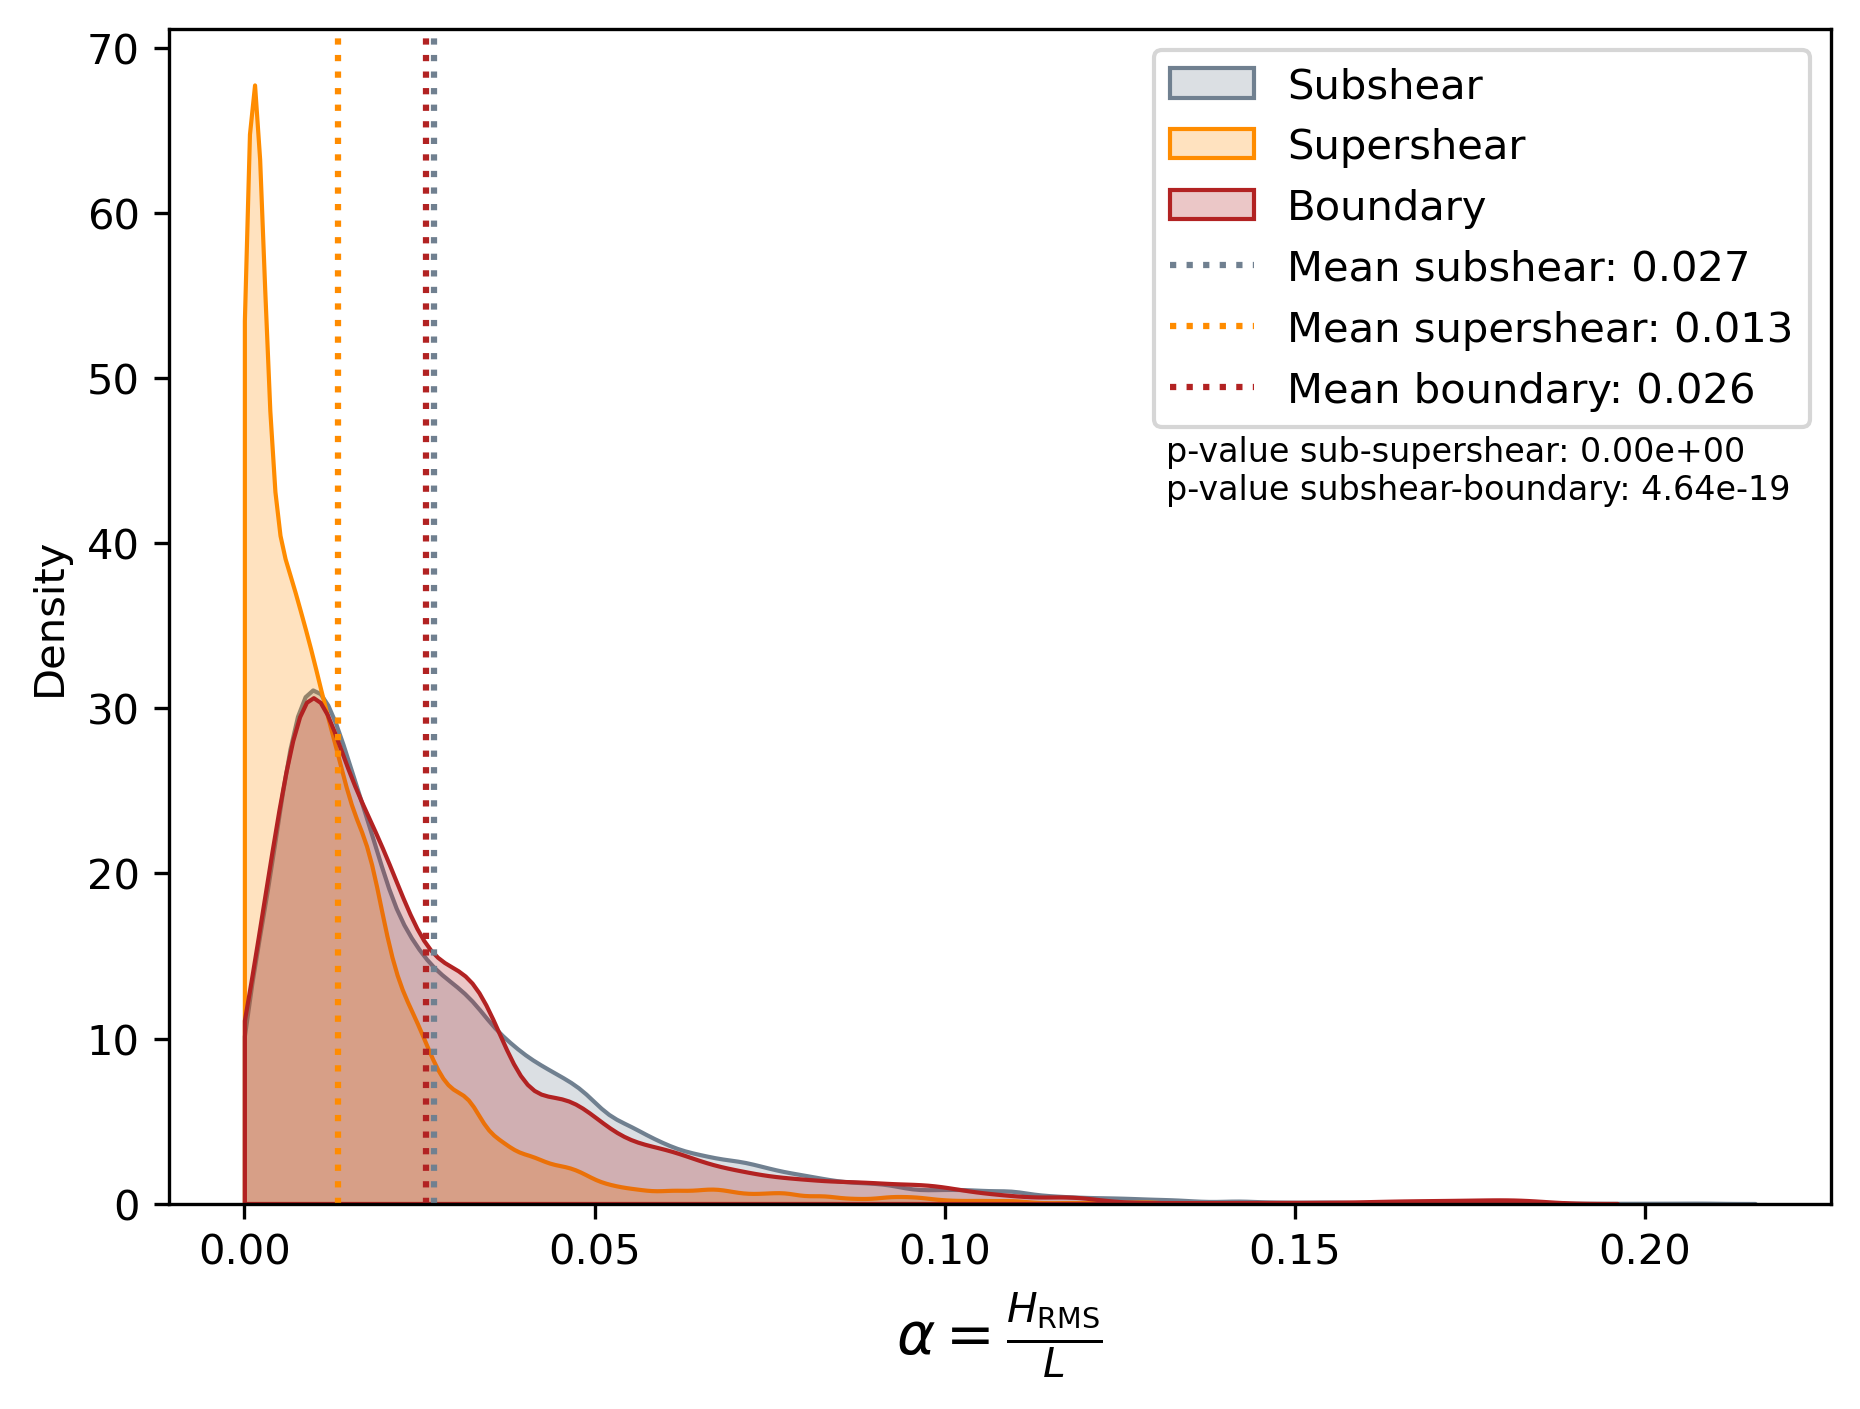

In [44]:
plt.figure(dpi=300)
supershear_alphas = alpha_data_all_events_segment_type[alpha_data_all_events_segment_type['segment_type'] == 'supershear']['alpha']
subshear_alphas = alpha_data_all_events_segment_type[alpha_data_all_events_segment_type['segment_type'] == 'subshear']['alpha']
boundary_alphas = alpha_data_all_events_segment_type[alpha_data_all_events_segment_type['boundary_segment']  == True]['alpha']

sns.kdeplot(alpha_data_all_events_segment_type[alpha_data_all_events_segment_type['segment_type'] == 'subshear']['alpha'], label='Subshear',fill=True,color='slategray',clip=(0,None))
sns.kdeplot(alpha_data_all_events_segment_type[alpha_data_all_events_segment_type['segment_type'] == 'supershear']['alpha'], label='Supershear',fill=True,color='darkorange',clip=(0,None))
sns.kdeplot(alpha_data_all_events_segment_type[alpha_data_all_events_segment_type['boundary_segment'] == True]['alpha'], label='Boundary',fill=True,color='firebrick',clip=(0,None))

mean_subshear = alpha_data_all_events_segment_type[alpha_data_all_events_segment_type['segment_type'] == 'subshear']['alpha'].mean()
mean_supershear = alpha_data_all_events_segment_type[alpha_data_all_events_segment_type['segment_type'] == 'supershear']['alpha'].mean()
mean_boundary = alpha_data_all_events_segment_type[alpha_data_all_events_segment_type['boundary_segment'] == True]['alpha'].mean()

plt.axvline(mean_subshear, color='slategray', linestyle=':', label=f'Mean subshear: {mean_subshear:.3f}')
plt.axvline(mean_supershear, color='darkorange', linestyle=':', label=f'Mean supershear: {mean_supershear:.3f}')
plt.axvline(mean_boundary, color='firebrick', linestyle=':', label=f'Mean boundary: {mean_boundary:.3f}')

# ks test
statistic, p_value_subshear_supershear = ks_2samp(subshear_alphas, supershear_alphas)
statistic, p_value_subshear_boundary = ks_2samp(subshear_alphas, boundary_alphas)
plt.text(0.6, 0.6, f'p-value sub-supershear: {p_value_subshear_supershear:.2e}\np-value subshear-boundary: {p_value_subshear_boundary:.2e}', transform=plt.gca().transAxes, fontsize=8)
plt.legend()
plt.xlabel(r'$\alpha = \frac{H_{\mathrm{RMS}}}{L}$',fontsize=14)
plt.ylabel('Density')
plt.tight_layout()
plt.savefig('Figures/alpha_events.pdf', dpi=300)


### Classify supershear segments for twin analysis

In [45]:
# put all event alphas together in one df
all_event_alphas = {} # dic to save data per event

# Group by event and convert to (position, alpha) tuples
for event_name, group in alpha_data_all_events_segment_type.groupby('event'):
    event_alphas = [(row['window_center_position'], row['alpha']) for _, row in group.iterrows()]
    all_event_alphas[event_name] = event_alphas
    # print(f"  {event_name}: {len(event_alphas)} alpha values") # for debugging



In [46]:
supershear_data = alpha_data_all_events_segment_type[alpha_data_all_events_segment_type['segment_type'] == 'supershear']

if not supershear_data.empty:
    segment_info = []
    
    for event_name, group in supershear_data.groupby('event'):        
        current_segment_start = None # to find continuous supershear segments for events with multiple ones
        current_segment_windows = []
        
        for idx, row in group.iterrows():
            if current_segment_start is None:
                current_segment_start = row['window_center_position'] # start segment
                current_segment_windows = [row]
            else:
                # check if this window is continuous with current segment
                if abs(row['window_center_position'] - current_segment_windows[-1]['window_center_position']) <= window_length * 1.02:
                    current_segment_windows.append(row)
                else:
                    # end current segment and save it
                    if len(current_segment_windows) > 0:
                        segment_info.append({
                            'event': event_name,
                            'segment_start_m': current_segment_windows[0]['window_center_position'],
                            'segment_end_m': current_segment_windows[-1]['window_center_position'],
                            'segment_length_km': (current_segment_windows[-1]['window_center_position'] - current_segment_windows[0]['window_center_position']) / 1000,
                            'n_windows': len(current_segment_windows),
                            'mean_alpha': np.mean([w['alpha'] for w in current_segment_windows]),
                            'std_alpha': np.std([w['alpha'] for w in current_segment_windows]),
                            'segment_type':'supershear'
                        })
                    
                    # init new segment
                    current_segment_start = row['window_center_position']
                    current_segment_windows = [row]
        
        if len(current_segment_windows) > 0:
            segment_info.append({
                'event': event_name,
                'segment_start_m': current_segment_windows[0]['window_center_position'],
                'segment_end_m': current_segment_windows[-1]['window_center_position'],
                'segment_length_km': (current_segment_windows[-1]['window_center_position'] - current_segment_windows[0]['window_center_position']) / 1000,
                'n_windows': len(current_segment_windows),
                'mean_alpha': np.mean([w['alpha'] for w in current_segment_windows]),
                'std_alpha': np.std([w['alpha'] for w in current_segment_windows]),
                'segment_type':'supershear'
            })
    
    segment_info_df = pd.DataFrame(segment_info)

### Twin search


In [47]:
segment_info_df['twin_segments'] = '' # new col for twins
all_non_supershear_data = alpha_data_all_events_segment_type[alpha_data_all_events_segment_type['segment_type'] != 'supershear']

for idx, supershear_seg in segment_info_df.iterrows():
    event_name = supershear_seg['event']
    supershear_mean_alpha = supershear_seg['mean_alpha']
    supershear_std_alpha = supershear_seg['std_alpha']
    supershear_length_km = supershear_seg['segment_length_km']

    twin_candidates = []
    
    for twin_event_name, twin_event_data in all_non_supershear_data.groupby('event'):
        twin_event_sorted = twin_event_data.sort_values('window_center_position')
    
        target_length_m = supershear_length_km * 1000 # 5 km sliding window
        
        #  step size to avoid overlapping segments
        step_size = 1000  # meters
        for start_idx in range(0, len(twin_event_sorted), max(1, int(step_size / 5))):  # 5m is approximate window spacing
            start_pos = twin_event_sorted.iloc[start_idx]['window_center_position']
            target_end_pos = start_pos + target_length_m
            
            # find windows within target length
            segment_mask = (twin_event_sorted['window_center_position'] >= start_pos) & \
                (twin_event_sorted['window_center_position'] <= target_end_pos)
            
            segment_windows = twin_event_sorted[segment_mask]
            
            if len(segment_windows) >= 2:
                segment_length_km = (segment_windows.iloc[-1]['window_center_position'] - segment_windows.iloc[0]['window_center_position']) / 1000
                
                if abs(segment_length_km - supershear_length_km) < 0.2:  
                    segment_mean_alpha = segment_windows['alpha'].mean()
                    segment_std_alpha = segment_windows['alpha'].std()
                    
                    alpha_diff = abs(segment_mean_alpha - supershear_mean_alpha)
                    std_diff = abs(segment_std_alpha - supershear_std_alpha)
                    
                    if (alpha_diff < 0.005 and std_diff < 0.002): 
                        # Check if this candidate is too close to existing ones
                        too_close = False
                        for existing_twin in twin_candidates:
                            existing_center = (existing_twin['start_pos'] + existing_twin['end_pos']) / 2
                            candidate_center = (segment_windows.iloc[0]['window_center_position'] + segment_windows.iloc[-1]['window_center_position']) / 2
                            distance = abs(existing_center - candidate_center)
                            
                            if distance < 10:  # 10m threshold
                                too_close = True
                                break
                        
                        if not too_close:
                            twin_candidates.append({
                                'event': twin_event_name,
                                'start_pos': segment_windows.iloc[0]['window_center_position'],
                                'end_pos': segment_windows.iloc[-1]['window_center_position'],
                                'length_km': segment_length_km,
                                'n_windows': len(segment_windows),
                                'mean_alpha': segment_mean_alpha,
                                'std_alpha': segment_std_alpha
                            })
    
    segment_info_df.at[idx, 'twin_segments'] = twin_candidates
    print(f"{event_name}: Found {len(twin_candidates)} twin segments")

for idx, supershear_seg in segment_info_df.iterrows():
    event_name = supershear_seg['event']
    supershear_mean_alpha = supershear_seg['mean_alpha']
    supershear_length_km = supershear_seg['segment_length_km']
    twin_candidates = supershear_seg['twin_segments']

Balochistan: Found 89 twin segments
Balochistan: Found 66 twin segments
Denali: Found 40 twin segments
Duzce: Found 80 twin segments
Elbistan: Found 89 twin segments
Imperial1979: Found 133 twin segments
Izmit_Kocaeli: Found 11 twin segments
Kahramanmaras: Found 103 twin segments
Kahramanmaras: Found 118 twin segments
Kahramanmaras: Found 119 twin segments
Kunlun_Kokoxili: Found 0 twin segments
Maduo: Found 10 twin segments
Myanmar: Found 0 twin segments
Palu: Found 13 twin segments
Wenchuan: Found 44 twin segments
Yushu: Found 23 twin segments


In [48]:
# Count segments that match the specific supershear lengths

total_possible_segments = 0
supershear_lengths = segment_info_df['segment_length_km'].tolist()

for twin_event_name, twin_event_data in all_non_supershear_data.groupby('event'):
    twin_event_sorted = twin_event_data.sort_values('window_center_position')
    
    # for each supershear length, count how many segments could match
    for target_length_km in supershear_lengths:
        target_length_m = target_length_km * 1000
        
        # count segments of this specific length
        for start_idx in range(len(twin_event_sorted)):
            start_pos = twin_event_sorted.iloc[start_idx]['window_center_position']
            target_end_pos = start_pos + target_length_m
            
            # find windows within target length
            segment_mask = (twin_event_sorted['window_center_position'] >= start_pos) & \
                        (twin_event_sorted['window_center_position'] <= target_end_pos)
            
            segment_windows = twin_event_sorted[segment_mask]
            
            if len(segment_windows) >= 2:
                segment_length_km = (segment_windows.iloc[-1]['window_center_position'] - segment_windows.iloc[0]['window_center_position']) / 1000
                
                # count if length is close to target
                if abs(segment_length_km - target_length_km) < 0.2:  # same tol as twin search
                    total_possible_segments += 1
    
for idx, supershear_seg in segment_info_df.iterrows():
    event_name = supershear_seg['event']
    twin_candidates = supershear_seg['twin_segments']
    
    if len(twin_candidates) > 0:
        twin_percentage = (len(twin_candidates) / total_possible_segments) * 100
        print(f"{event_name}: {len(twin_candidates)} twins out of {total_possible_segments:,} possible segments = {twin_percentage:.3f}%")
    else:
        print(f"{event_name}: 0 twins out of {total_possible_segments:,} possible segments = 0.000%")

total_twins_found = sum(len(seg['twin_segments']) for _, seg in segment_info_df.iterrows())
overall_twin_percentage = (total_twins_found / total_possible_segments) * 100

print(f"\nOVERALL SUMMARY:")
print(f"Total twins found: {total_twins_found:,}")
print(f"Total possible segments: {total_possible_segments:,}")
print(f"Overall twin percentage: {overall_twin_percentage:.3f}%")

Balochistan: 89 twins out of 2,042,554 possible segments = 0.004%
Balochistan: 66 twins out of 2,042,554 possible segments = 0.003%
Denali: 40 twins out of 2,042,554 possible segments = 0.002%
Duzce: 80 twins out of 2,042,554 possible segments = 0.004%
Elbistan: 89 twins out of 2,042,554 possible segments = 0.004%
Imperial1979: 133 twins out of 2,042,554 possible segments = 0.007%
Izmit_Kocaeli: 11 twins out of 2,042,554 possible segments = 0.001%
Kahramanmaras: 103 twins out of 2,042,554 possible segments = 0.005%
Kahramanmaras: 118 twins out of 2,042,554 possible segments = 0.006%
Kahramanmaras: 119 twins out of 2,042,554 possible segments = 0.006%
Kunlun_Kokoxili: 0 twins out of 2,042,554 possible segments = 0.000%
Maduo: 10 twins out of 2,042,554 possible segments = 0.000%
Myanmar: 0 twins out of 2,042,554 possible segments = 0.000%
Palu: 13 twins out of 2,042,554 possible segments = 0.001%
Wenchuan: 44 twins out of 2,042,554 possible segments = 0.002%
Yushu: 23 twins out of 2,042,

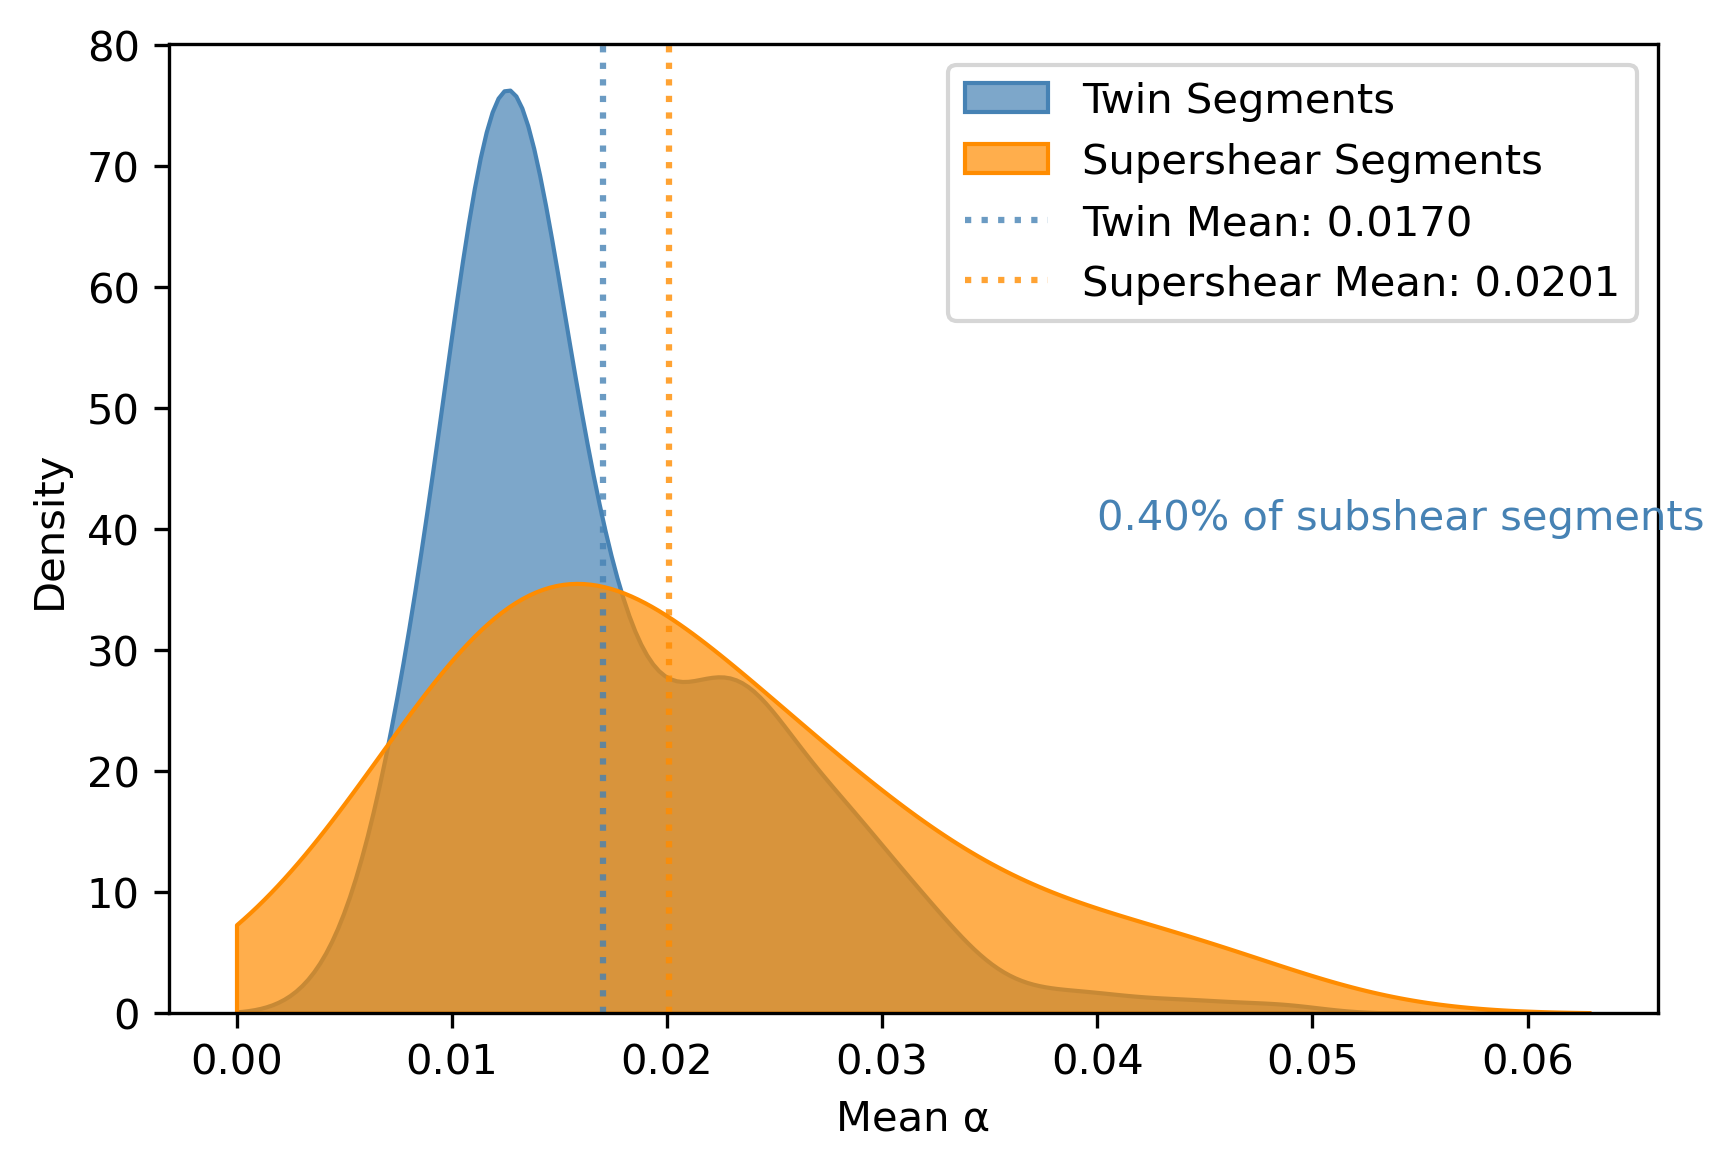

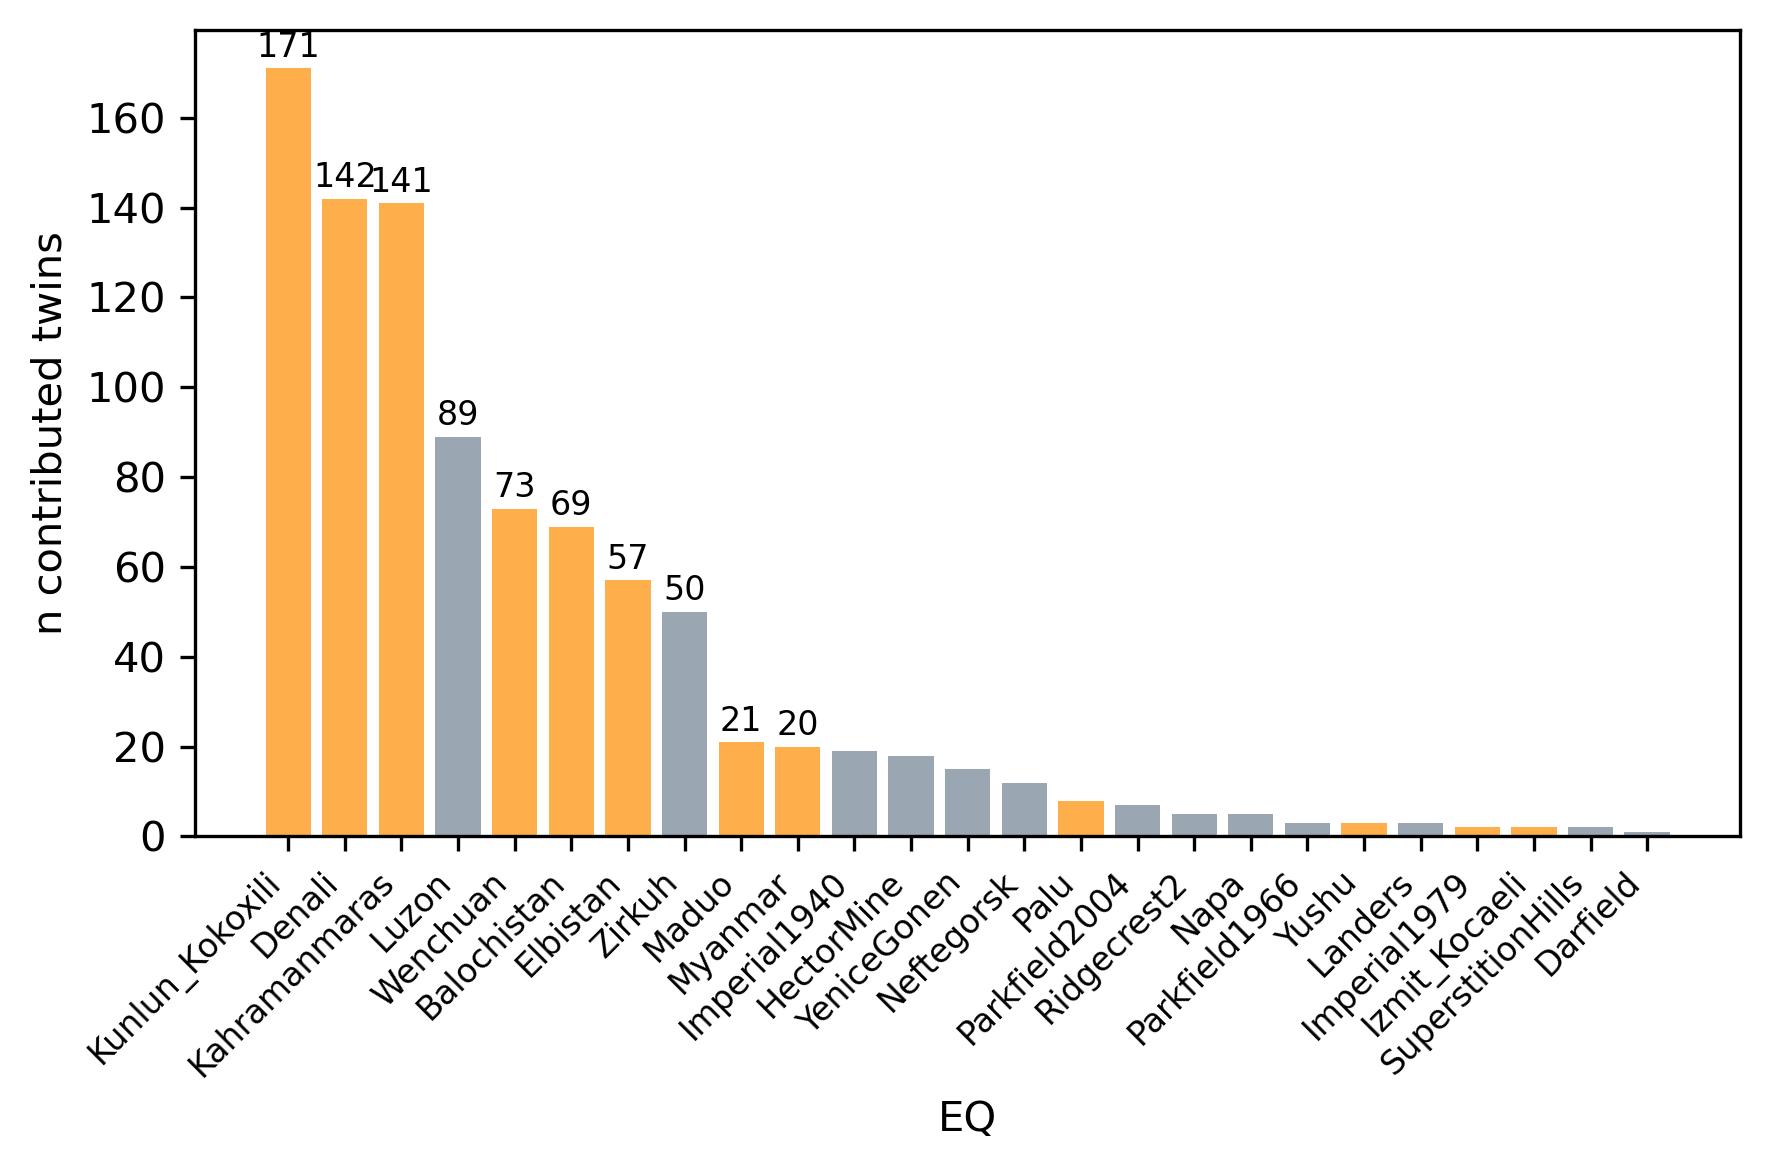

In [49]:
if 'segment_info_df' in locals() and not segment_info_df.empty:
    fig1, ax1 = plt.subplots(figsize=(6,4), dpi=300)
    all_twin_alphas = []
    all_supershear_alphas = []
    
    for idx, supershear_seg in segment_info_df.iterrows():
        all_supershear_alphas.append(supershear_seg['mean_alpha'])
        twin_candidates = supershear_seg['twin_segments']
        if len(twin_candidates) > 0:
            for twin in twin_candidates:
                all_twin_alphas.append(twin['mean_alpha'])
    
    # clip kde at 0 
    if all_twin_alphas:
        sns.kdeplot(data=all_twin_alphas, label='Twin Segments', fill=True, color='steelblue', alpha=0.7, ax=ax1, clip=(0,None))
    if all_supershear_alphas:
        sns.kdeplot(data=all_supershear_alphas, label='Supershear Segments', fill=True, color='darkorange', alpha=0.7, ax=ax1, clip=(0,None))
    
    if all_twin_alphas:
        twin_mean = np.mean(all_twin_alphas)
        ax1.axvline(twin_mean, color='steelblue', linestyle=':', alpha=0.8, 
            label=f'Twin Mean: {twin_mean:.4f}')
    
    if all_supershear_alphas:
        supershear_mean = np.mean(all_supershear_alphas)
        ax1.axvline(supershear_mean, color='darkorange', linestyle=':', alpha=0.8, 
            label=f'Supershear Mean: {supershear_mean:.4f}')
    
    #  twin percentage
    total_possible_segments = len(all_non_supershear_data)  # Approximate
    twin_percentage = (len(all_twin_alphas) / total_possible_segments) * 100 if total_possible_segments > 0 else 0
    
    if all_twin_alphas and all_supershear_alphas:
        ax1.text(0.04, 40, f'{twin_percentage:.2f}% of subshear segments', color='steelblue', fontsize=10)
    
    ax1.set_xlabel('Mean α')
    ax1.set_ylabel('Density')
    ax1.legend()
    plt.tight_layout()
    plt.savefig('Figures/twin_segments_alpha.pdf', dpi=300)
    

    fig2, ax2 = plt.subplots(figsize=(6,4), dpi=300)
    twin_counts_by_event = {}
    for idx, supershear_seg in segment_info_df.iterrows():
        twin_candidates = supershear_seg['twin_segments']
        if len(twin_candidates) > 0:
            for twin in twin_candidates:
                event_name = twin['event']
                twin_counts_by_event[event_name] = twin_counts_by_event.get(event_name, 0) + 1
    
    if twin_counts_by_event:
        sorted_events = sorted(twin_counts_by_event.items(), key=lambda x: x[1], reverse=True)
        events = [item[0] for item in sorted_events]
        counts = [item[1] for item in sorted_events]
        

        supershear_events = set(rupture_vel_points['Event'].unique()) if 'rupture_vel_points' in locals() else set()
        colors = ['darkorange' if event in supershear_events else 'slategray' for event in events]
        
        bars = ax2.bar(range(len(events)), counts, alpha=0.7, edgecolor='none', color=colors)
        ax2.set_xlabel('EQ')
        ax2.set_ylabel('n contributed twins')
        ax2.set_xticks(range(len(events)))
        ax2.set_xticklabels(events, rotation=45, ha='right', fontsize=8)
        

        for i, count in enumerate(counts[:10]):
            ax2.text(i, count + 1, str(count), ha='center', va='bottom', fontsize=8)
        
        plt.tight_layout()
        plt.savefig('Figures/twin_segments_by_event.pdf', dpi=300)

### Distance to epicenter

In [50]:
# epi dataframe from FDHI and other events
epicenter_locs = {}
for _, row in fdhi_data.iterrows():
    eq_name = row['eq_name']
    hypo_lon = row['hypocenter_longitude_degrees']
    hypo_lat = row['hypocenter_latitude_degrees']
    epicenter_locs[eq_name] = (hypo_lat, hypo_lon)
# epis not in FDHI
manual_epi = {
    'Maduo': (34.586, 98.255),  # wikipedia https://en.wikipedia.org/wiki/2021_Maduo_earthquake
    'Elbistan': (38.089, 37.239) ,  #  Karray et al., 2024 https://www.sciencedirect.com/science/article/pii/S0267726124001866#:~:text=The%20second%20earthquake%2C%20hereafter%20referred,%E2%88%92%20focal%20depth%207.0%20km).
    'Kahramanmaras': (37.166,37.032),  # wikipedia https://en.wikipedia.org/wiki/2023_Turkey%E2%80%93Syria_earthquakes
    'Myanmar': (22.001, 95.925) # wikipedia https://en.wikipedia.org/wiki/2025_Myanmar_earthquake
}
epicenter_locs.update(manual_epi)

In [51]:
# Create dataframe to store segment distances from epicenters (no boundaries)
segment_distances = []

for idx, supershear_seg in segment_info_df.iterrows():
    event_name = supershear_seg['event']
    
    # Get epicenter for this event
    if event_name in epicenter_locs:
        epicenter_lat, epicenter_lon = epicenter_locs[event_name]
        
        # Load the fault geometry for this event
        shp_file = f'Output_LCP/{event_name}_LCP_line.shp'

        gdf = gpd.read_file(shp_file)
        epsg_code = utm_mapping.get(event_name)
        gdf_proj = gdf.to_crs(epsg=int(epsg_code)) if epsg_code is not None else gdf
        
        # Get the fault line
        fault_line = gdf_proj.geometry.iloc[0]
        
        
        epicenter_point = Point(epicenter_lon, epicenter_lat)
        epicenter_point_utm = gpd.GeoDataFrame(geometry=[epicenter_point], crs='EPSG:4326').to_crs(epsg=int(epsg_code)).geometry.iloc[0]
        
        #  closest point on fault to epicenter
        closest_point_on_fault = fault_line.interpolate(fault_line.project(epicenter_point_utm))
        epicenter_distance_along_fault = fault_line.project(epicenter_point_utm)
        
        #  supershear segment info
        supershear_start = supershear_seg['segment_start_m']
        supershear_end = supershear_seg['segment_end_m']
        supershear_center = (supershear_start + supershear_end) / 2
        
        #  distance from epicenter to supershear segment center
        distance_to_supershear = abs(epicenter_distance_along_fault - supershear_center)
        
        segment_distances.append({
            'event': event_name,
            'segment_type': 'supershear',
            'segment_start_m': supershear_start,
            'segment_end_m': supershear_end,
            'segment_center_m': supershear_center,
            'epicenter_distance_along_fault_m': epicenter_distance_along_fault,
            'distance_to_segment_m': distance_to_supershear,
            'distance_to_segment_km': distance_to_supershear / 1000
        })
        
        #  twins for this supershear segment
        twin_candidates = supershear_seg['twin_segments']
        if twin_candidates and len(twin_candidates) > 0:
            for twin in twin_candidates:
                twin_start = twin['start_pos']
                twin_end = twin['end_pos']
                twin_center = (twin_start + twin_end) / 2
                
                distance_to_twin = abs(epicenter_distance_along_fault - twin_center)
                
                segment_distances.append({
                    'event': event_name,
                    'segment_type': 'twin',
                    'segment_start_m': twin_start,
                    'segment_end_m': twin_end,
                    'segment_center_m': twin_center,
                    'epicenter_distance_along_fault_m': epicenter_distance_along_fault,
                    'distance_to_segment_m': distance_to_twin,
                    'distance_to_segment_km': distance_to_twin / 1000
                })
        
        event_data = alpha_data_all_events_segment_type[alpha_data_all_events_segment_type['event'] == event_name]
        
        subshear_data = event_data[event_data['segment_type'] == 'subshear']
        if len(subshear_data) > 0:
            # find continuous subshear segments
            subshear_data_sorted = subshear_data.sort_values('window_center_position')
            
            # group consecutive windows
            current_segment_start = None
            current_segment_windows = []
            
            for _, row in subshear_data_sorted.iterrows():
                if current_segment_start is None:
                    current_segment_start = row['window_center_position']
                    current_segment_windows = [row]
                else:
                    # Check if continuous (within reasonable gap)
                    if abs(row['window_center_position'] - current_segment_windows[-1]['window_center_position']) <= window_length * 1.5:
                        current_segment_windows.append(row)
                    else:
                        # End current segment
                        if len(current_segment_windows) >= 2:
                            seg_start = current_segment_windows[0]['window_center_position']
                            seg_end = current_segment_windows[-1]['window_center_position']
                            seg_center = (seg_start + seg_end) / 2
                            
                            distance_to_seg = abs(epicenter_distance_along_fault - seg_center)
                            
                            segment_distances.append({
                                'event': event_name,
                                'segment_type': 'subshear',
                                'segment_start_m': seg_start,
                                'segment_end_m': seg_end,
                                'segment_center_m': seg_center,
                                'epicenter_distance_along_fault_m': epicenter_distance_along_fault,
                                'distance_to_segment_m': distance_to_seg,
                                'distance_to_segment_km': distance_to_seg / 1000
                            })
                        
                        #  new segment
                        current_segment_start = row['window_center_position']
                        current_segment_windows = [row]
            
            # last segment
            if len(current_segment_windows) >= 2:
                seg_start = current_segment_windows[0]['window_center_position']
                seg_end = current_segment_windows[-1]['window_center_position']
                seg_center = (seg_start + seg_end) / 2
                
                distance_to_seg = abs(epicenter_distance_along_fault - seg_center)
                
                segment_distances.append({
                    'event': event_name,
                    'segment_type': 'subshear',
                    'segment_start_m': seg_start,
                    'segment_end_m': seg_end,
                    'segment_center_m': seg_center,
                    'epicenter_distance_along_fault_m': epicenter_distance_along_fault,
                    'distance_to_segment_m': distance_to_seg,
                    'distance_to_segment_km': distance_to_seg / 1000
                })
    
segment_distances_df = pd.DataFrame(segment_distances)

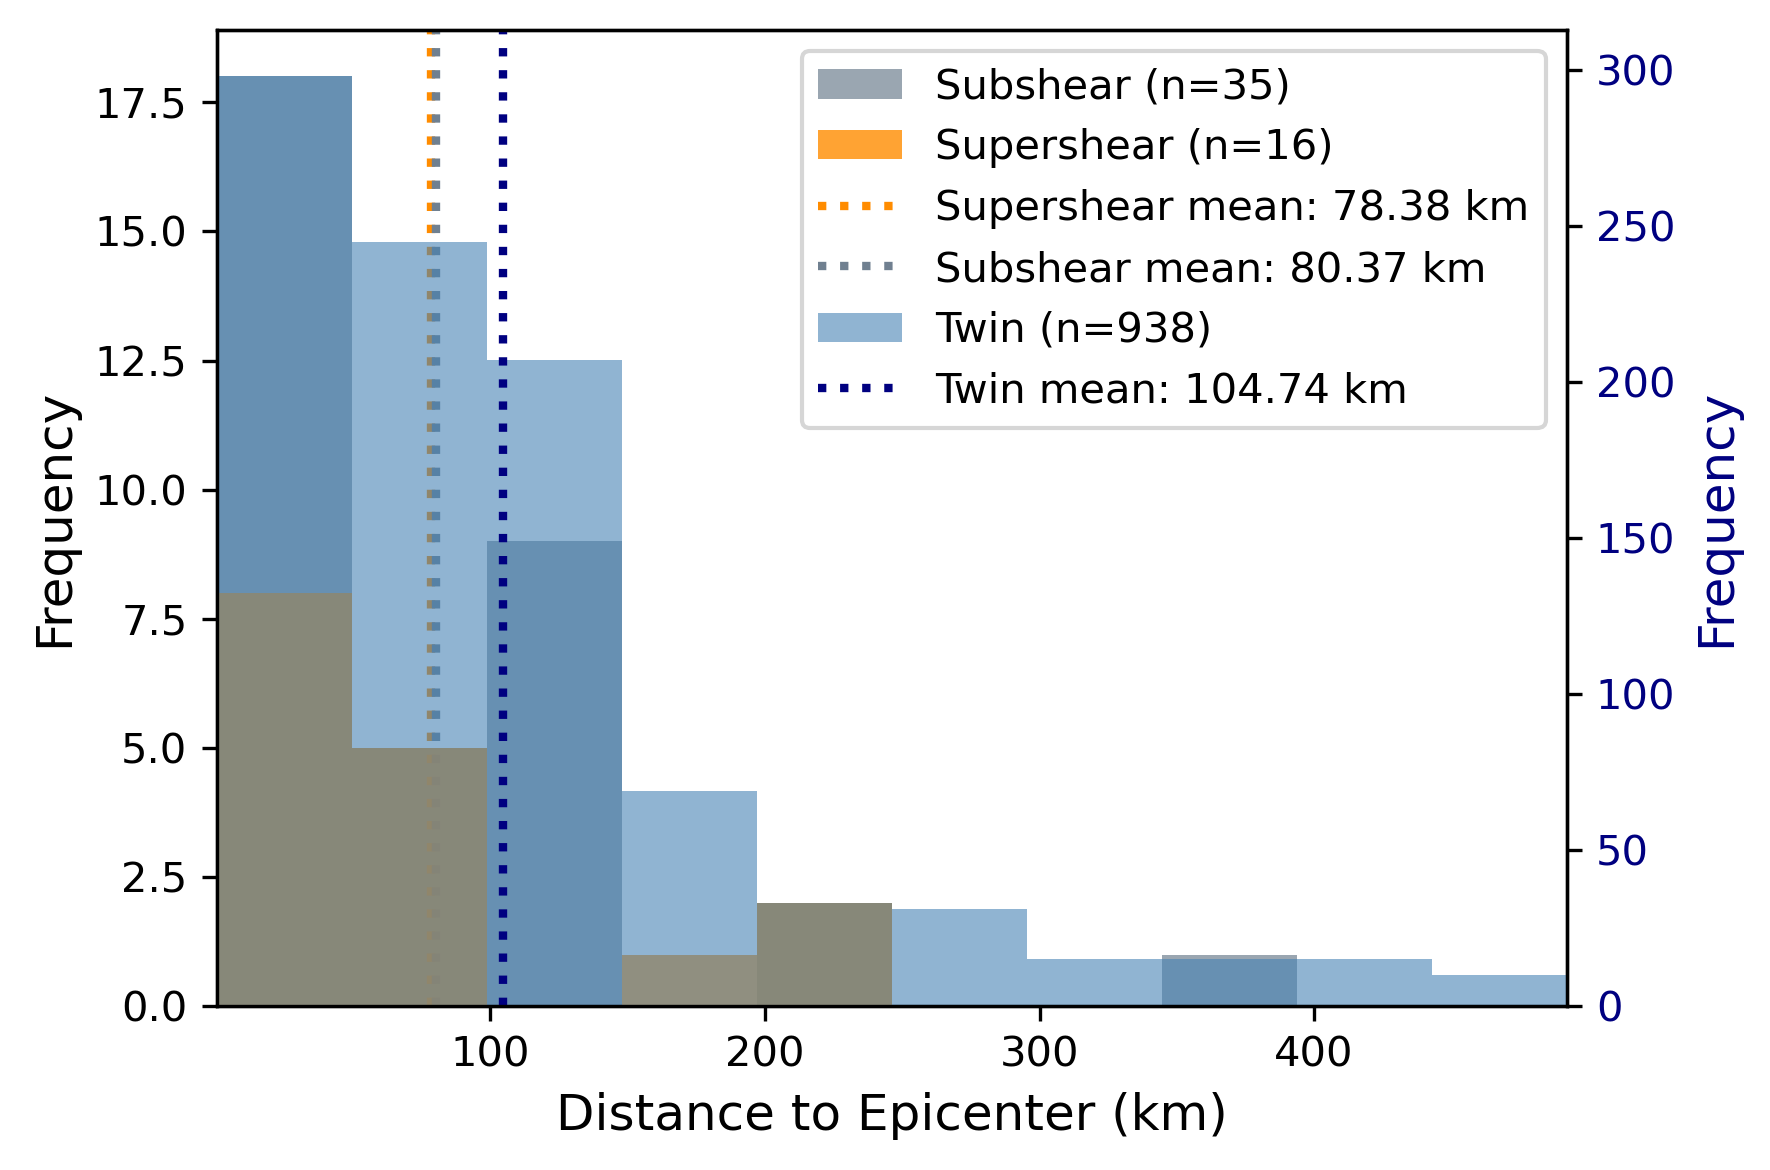

In [52]:
supershear_distances = segment_distances_df[segment_distances_df['segment_type'] == 'supershear']['distance_to_segment_km']
subshear_distances = segment_distances_df[segment_distances_df['segment_type'] == 'subshear']['distance_to_segment_km']
twin_distances = segment_distances_df[segment_distances_df['segment_type'] == 'twin']['distance_to_segment_km']
all_distances = np.concatenate([supershear_distances, subshear_distances, twin_distances])
min_dist = all_distances.min()
max_dist = all_distances.max()
n_bins = 10
bin_edges = np.linspace(min_dist, max_dist, n_bins + 1)

fig, ax1 = plt.subplots(figsize=(6,4), dpi=300)
ax2 = ax1.twinx()

if len(subshear_distances) > 0:
    ax1.hist(subshear_distances, bins=bin_edges, alpha=0.7, color='slategray', 
             label=f'Subshear (n={len(subshear_distances)})', edgecolor='none')

if len(supershear_distances) > 0:
    ax1.hist(supershear_distances, bins=bin_edges, alpha=0.8, color='darkorange', zorder=10,
             label=f'Supershear (n={len(supershear_distances)})', edgecolor='none')

if len(twin_distances) > 0:
    ax2.hist(twin_distances, bins=bin_edges, alpha=0.6, color='steelblue', 
             label=f'Twin (n={len(twin_distances)})', edgecolor='none', linewidth=0.5)

if len(supershear_distances) > 0:
    supershear_mean = supershear_distances.mean()
    ax1.axvline(supershear_mean, color='darkorange', linestyle=':', linewidth=2, # show on top of the plot
                label=f'Supershear mean: {supershear_mean:.2f} km')
if len(subshear_distances) > 0:
    subshear_mean = subshear_distances.mean()
    ax1.axvline(subshear_mean, color='slategray', linestyle=':', linewidth=2, 
                label=f'Subshear mean: {subshear_mean:.2f} km')

if len(twin_distances) > 0:
    twin_mean = twin_distances.mean()
    ax2.axvline(twin_mean, color='navy', linestyle=':', linewidth=2, 
                label=f'Twin mean: {twin_mean:.2f} km')

ax1.set_xlabel('Distance to Epicenter (km)', fontsize=12)
ax1.set_ylabel('Frequency', fontsize=12, color='black')
ax2.set_ylabel('Frequency', fontsize=12, color='navy')
ax1.set_xlim(min_dist, max_dist)
ax1.tick_params(axis='y', labelcolor='black')
ax2.tick_params(axis='y', labelcolor='navy')

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right', fontsize=10)
plt.tight_layout()

### Distribution of supershear segment lengths and cut offs

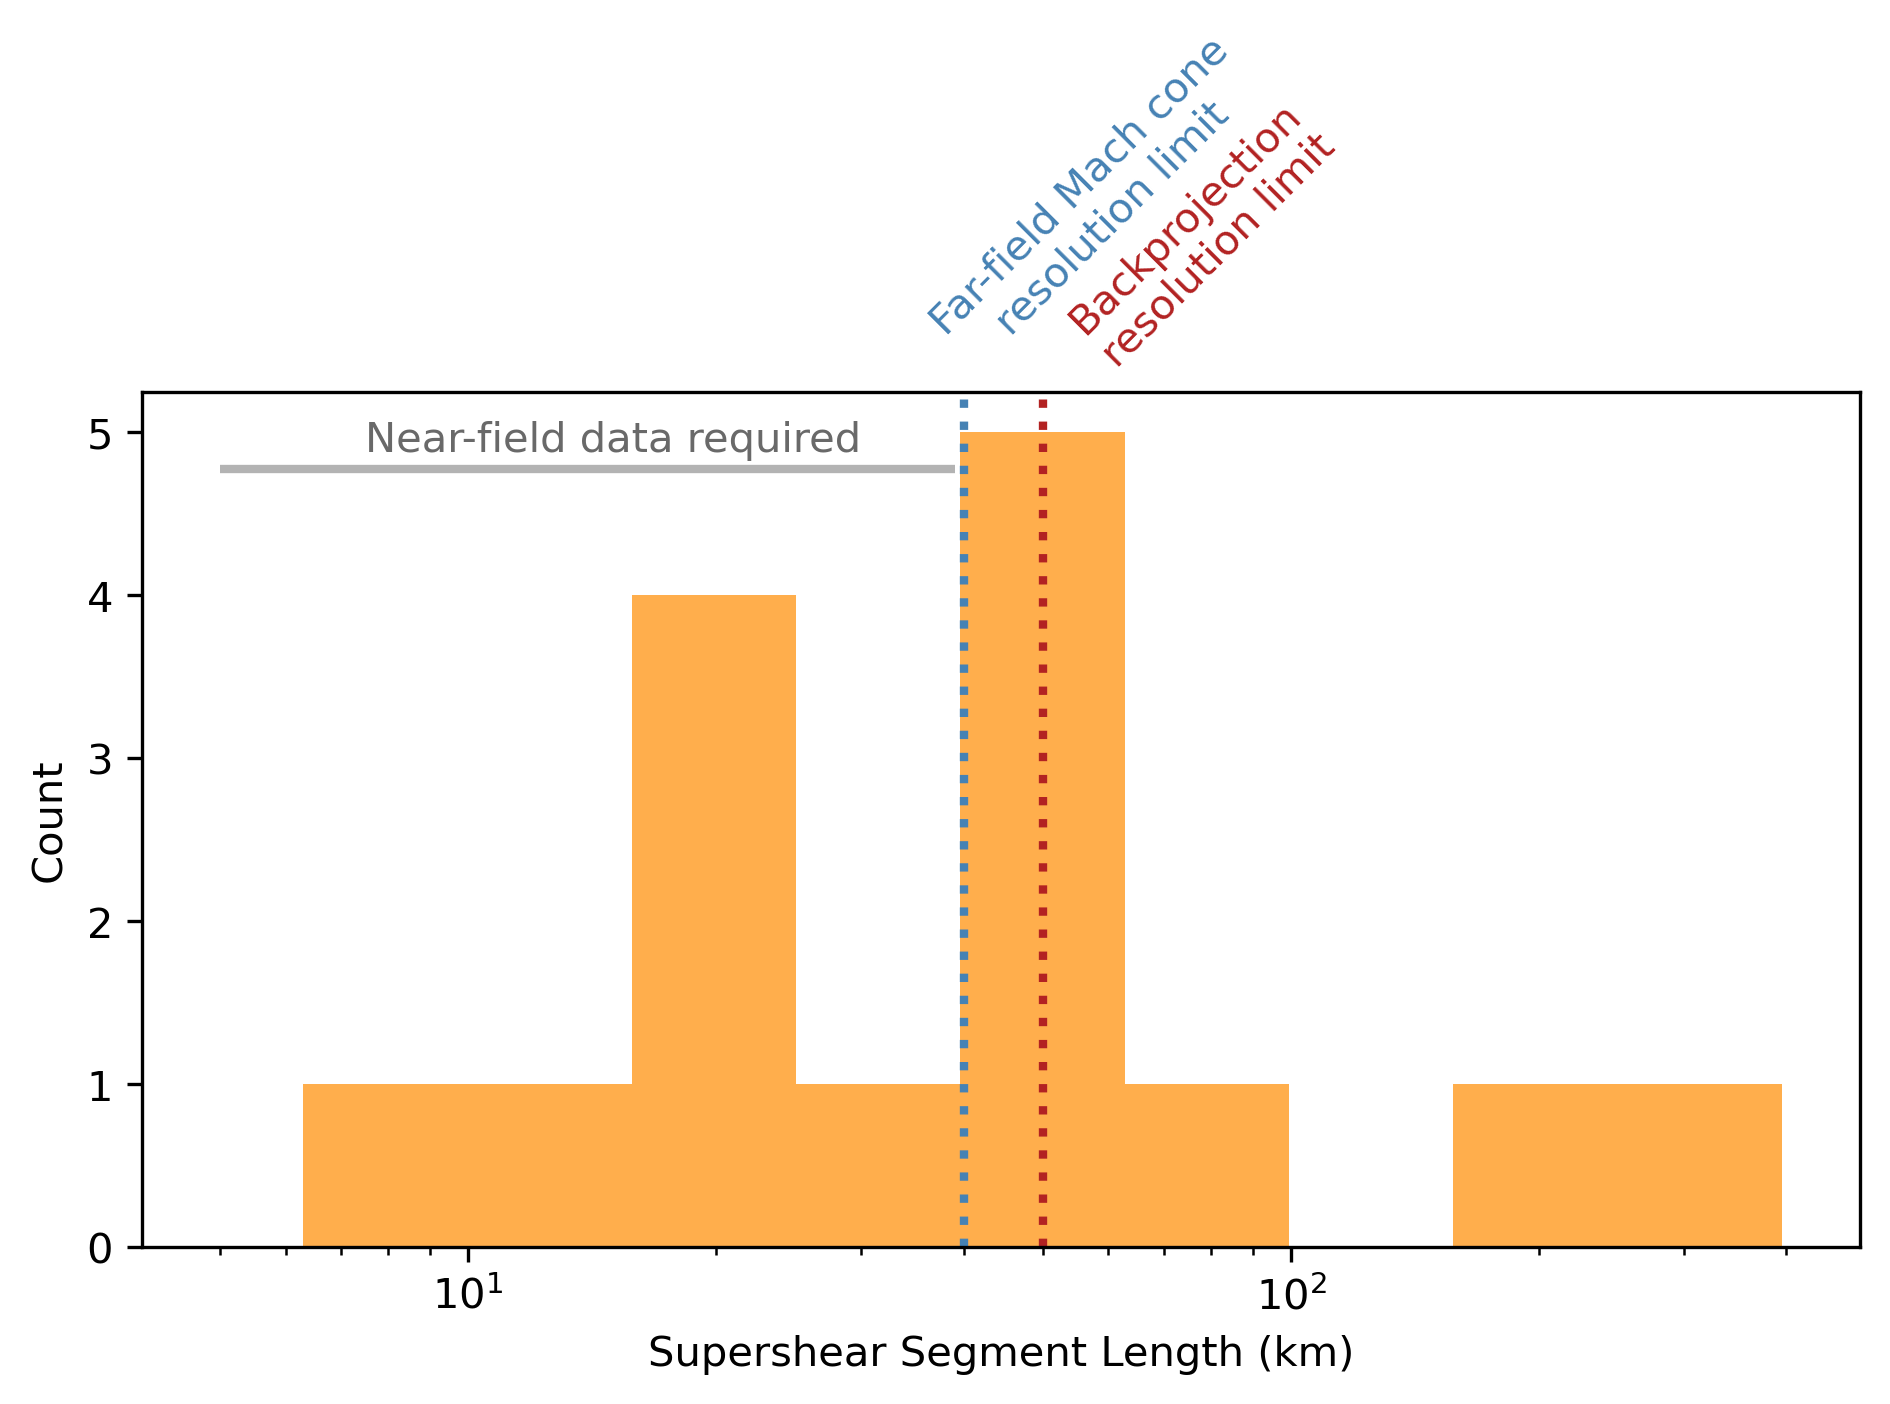

In [53]:
plt.figure(dpi=300)
bins = np.logspace(np.log10(min(supershear_lengths)), np.log10(max(supershear_lengths) + 1), 10)
sns.histplot(supershear_lengths, color='darkorange',alpha=0.7, edgecolor='none', bins=bins)
plt.axvline(x=40, color='steelblue', linestyle=':', linewidth=2) 
plt.axvline(x=50, color='firebrick', linestyle=':', linewidth=2)
plt.xlabel('Supershear Segment Length (km)')
plt.ylabel('Count')
plt.text(58, plt.ylim()[1] * 1.02, 'Far-field Mach cone\nresolution limit', 
        rotation=45, ha='center', va='bottom', fontsize=10, color='steelblue')
plt.text(78, plt.ylim()[1] * 1.02, 'Backprojection\nresolution limit', 
        rotation=45, ha='center', va='bottom', fontsize=10, color='firebrick')

plt.hlines(y=plt.ylim()[1] * 0.91, xmin=5, xmax=39, 
        color='dimgray', linewidth=2, alpha=0.5)
plt.text(15, plt.ylim()[1] * 0.92, 'Near-field data required', 
        ha='center', va='bottom', fontsize=10, color='dimgray')

plt.xscale('log') 
plt.tight_layout()
plt.savefig('Figures/supershear_length_and_detection_thresholds.pdf', dpi=300)

### Twin vs supershear seeds

Percentage larger: 22.2%
KS test p-value: 0.0000


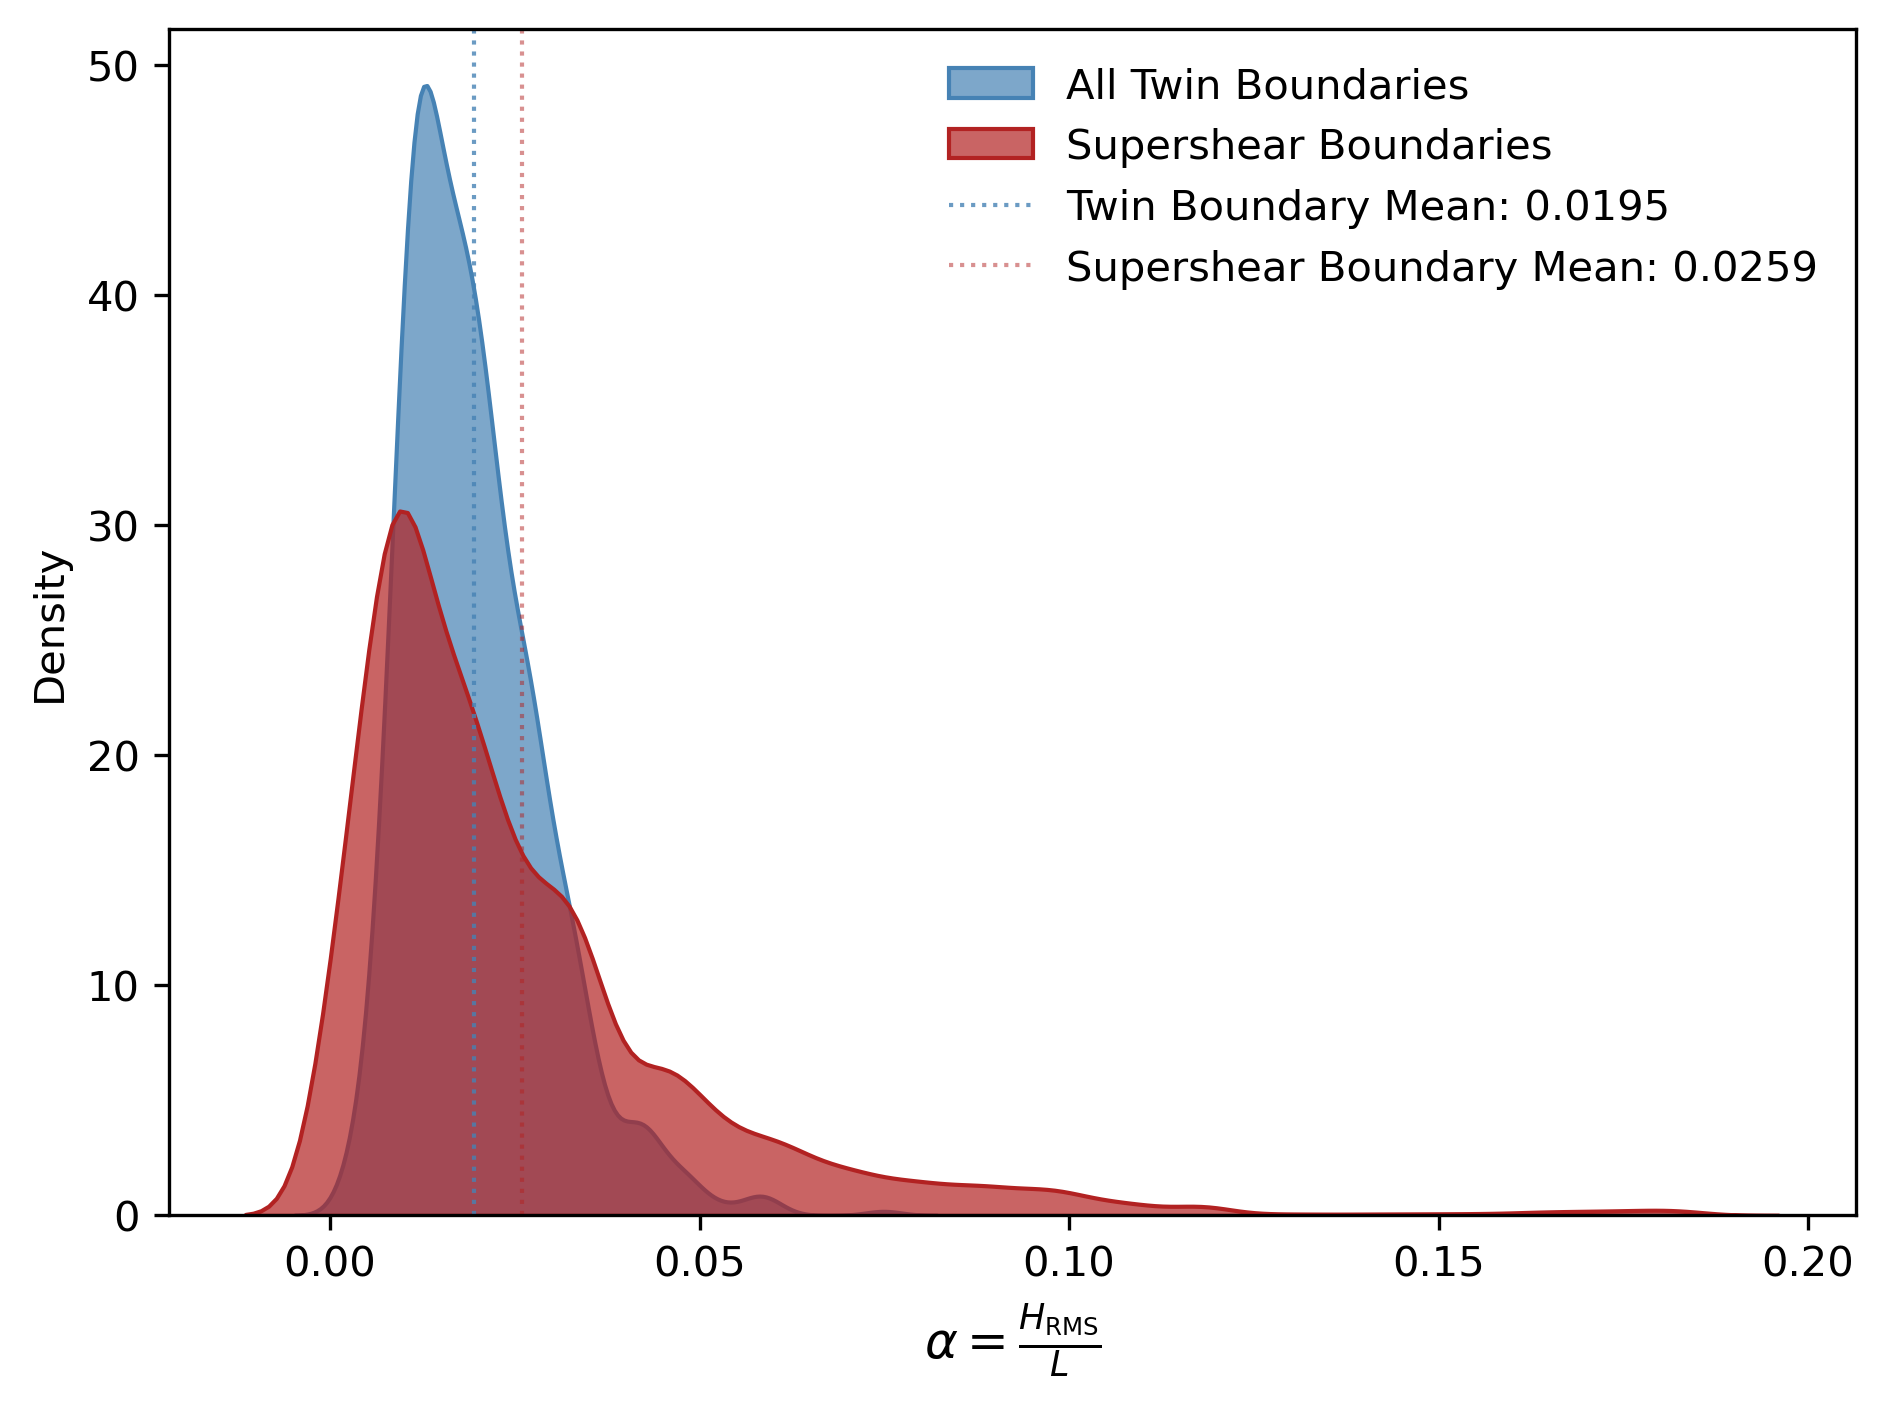

In [54]:
twin_boundary_alphas = []
twin_boundary_info = []

for idx, supershear_seg in segment_info_df.iterrows():
    event_name = supershear_seg['event']
    twin_candidates = supershear_seg['twin_segments']
        
    for twin in twin_candidates:
        twin_event = twin['event']
        twin_start = twin['start_pos']
        twin_end = twin['end_pos']
        
        twin_event_data = alpha_data_all_events_segment_type[
            alpha_data_all_events_segment_type['event'] == twin_event
        ].copy()
        
        boundary_candidates = []
        pre_twin_mask = (twin_event_data['window_center_position'] < twin_start) & \
                        (twin_event_data['window_center_position'] >= twin_start - window_length * 1.5)
        pre_twin_segments = twin_event_data[pre_twin_mask]
        
        post_twin_mask = (twin_event_data['window_center_position'] > twin_end) & \
                        (twin_event_data['window_center_position'] <= twin_end + window_length * 1.5)
        post_twin_segments = twin_event_data[post_twin_mask]
        
        boundary_candidates = pd.concat([pre_twin_segments, post_twin_segments])
        
        if len(boundary_candidates) > 0:
            boundary_mean_alpha = boundary_candidates['alpha'].mean()
            boundary_std_alpha = boundary_candidates['alpha'].std()
            boundary_count = len(boundary_candidates)
            
            twin_boundary_alphas.append(boundary_mean_alpha)

            supershear_boundary_mean = np.mean(boundary_alphas)
            alpha_larger_than_supershear = boundary_mean_alpha > supershear_boundary_mean
            
            twin_boundary_info.append({
                'supershear_event': event_name,
                'twin_event': twin_event,
                'twin_start': twin_start,
                'twin_end': twin_end,
                'twin_length_km': twin['length_km'],
                'twin_mean_alpha': twin['mean_alpha'],
                'boundary_mean_alpha': boundary_mean_alpha,
                'boundary_std_alpha': boundary_std_alpha,
                'boundary_count': boundary_count,
                'boundary_positions': boundary_candidates['window_center_position'].tolist(),
                'alpha_larger_than_supershear': alpha_larger_than_supershear,
                'supershear_boundary_mean': supershear_boundary_mean,
                'alpha_difference': boundary_mean_alpha - supershear_boundary_mean
            })

twin_boundary_df = pd.DataFrame(twin_boundary_info)
total_twin_boundaries = len(twin_boundary_df)
larger_than_supershear = twin_boundary_df['alpha_larger_than_supershear'].sum()
percentage_larger = (larger_than_supershear / total_twin_boundaries) * 100 if total_twin_boundaries > 0 else 0
print(f"Percentage larger: {percentage_larger:.1f}%")
# KS test
statistic, p_value = ks_2samp(twin_boundary_alphas, boundary_alphas)
print(f"KS test p-value: {p_value:.4f}")

plt.figure(dpi=300)
sns.kdeplot(data=twin_boundary_alphas, label='All Twin Boundaries', fill=True, color='steelblue', alpha=0.7)

# larger_twin_boundaries = twin_boundary_df[twin_boundary_df['alpha_larger_than_supershear']]['boundary_mean_alpha']
# if len(larger_twin_boundaries) > 0:
#     sns.kdeplot(data=larger_twin_boundaries, label='Twin Boundaries > Supershear Mean', 
#                 fill=True, color='red', alpha=0.5)


sns.kdeplot(data=boundary_alphas, label='Supershear Boundaries', fill=True, color='firebrick', alpha=0.7)
twin_boundary_mean = np.mean(twin_boundary_alphas)
boundary_mean = np.mean(boundary_alphas)

plt.axvline(twin_boundary_mean, color='steelblue', linestyle=':', alpha=0.8, lw=1,
            label=f'Twin Boundary Mean: {twin_boundary_mean:.4f}')
plt.axvline(boundary_mean, color='firebrick', linestyle=':', alpha=0.5, lw=1,
            label=f'Supershear Boundary Mean: {boundary_mean:.4f}')

plt.xlabel(r'$\alpha = \frac{H_{\mathrm{RMS}}}{L}$', fontsize=12)
plt.ylabel('Density')
plt.legend(frameon=False)
plt.tight_layout()
plt.savefig('Figures/twin_vs_supershear_boundary_alphas.pdf', dpi=300)



Processing ChalfantValley...

Processing Neftegorsk...
  Twin 1: Neftegorsk segment 4761-24518m is twin to Duzce supershear segment 23172-42938m (length: 19.8 km)
  Twin 2: Neftegorsk segment 6968-26726m is twin to Duzce supershear segment 23172-42938m (length: 19.8 km)
  Twin 3: Neftegorsk segment 9175-28933m is twin to Duzce supershear segment 23172-42938m (length: 19.8 km)
  Twin 4: Neftegorsk segment 11432-31188m is twin to Duzce supershear segment 23172-42938m (length: 19.8 km)
  Twin 5: Neftegorsk segment 13705-33463m is twin to Duzce supershear segment 23172-42938m (length: 19.8 km)
  Twin 6: Neftegorsk segment 13705-29468m is twin to Kahramanmaras supershear segment 62293-78057m (length: 15.8 km)
  Twin 7: Neftegorsk segment 15763-31523m is twin to Kahramanmaras supershear segment 62293-78057m (length: 15.8 km)
  Twin 8: Neftegorsk segment 17850-33613m is twin to Kahramanmaras supershear segment 62293-78057m (length: 15.8 km)
  Twin 9: Neftegorsk segment 20161-35916m is twin t

/var/folders/kg/j5ms0y1x28l_gm2jtsf5j4pr0000gn/T/ipykernel_43014/309282988.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=(10, 6), dpi=300)



Processing Hualien...

Processing Yutian...

Processing Ridgecrest2...
  Twin 1: Ridgecrest2 segment 20584-40341m is twin to Duzce supershear segment 23172-42938m (length: 19.8 km)
  Twin 2: Ridgecrest2 segment 15337-31090m is twin to Kahramanmaras supershear segment 62293-78057m (length: 15.8 km)
  Twin 3: Ridgecrest2 segment 17897-33659m is twin to Kahramanmaras supershear segment 62293-78057m (length: 15.8 km)
  Twin 4: Ridgecrest2 segment 20584-36344m is twin to Kahramanmaras supershear segment 62293-78057m (length: 15.8 km)
  Twin 5: Ridgecrest2 segment 23160-38917m is twin to Kahramanmaras supershear segment 62293-78057m (length: 15.8 km)

Processing Balochistan...
  Twin 1: Balochistan segment 32530-52290m is twin to Duzce supershear segment 23172-42938m (length: 19.8 km)
  Twin 2: Balochistan segment 34969-54726m is twin to Duzce supershear segment 23172-42938m (length: 19.8 km)
  Twin 3: Balochistan segment 37421-57186m is twin to Duzce supershear segment 23172-42938m (length

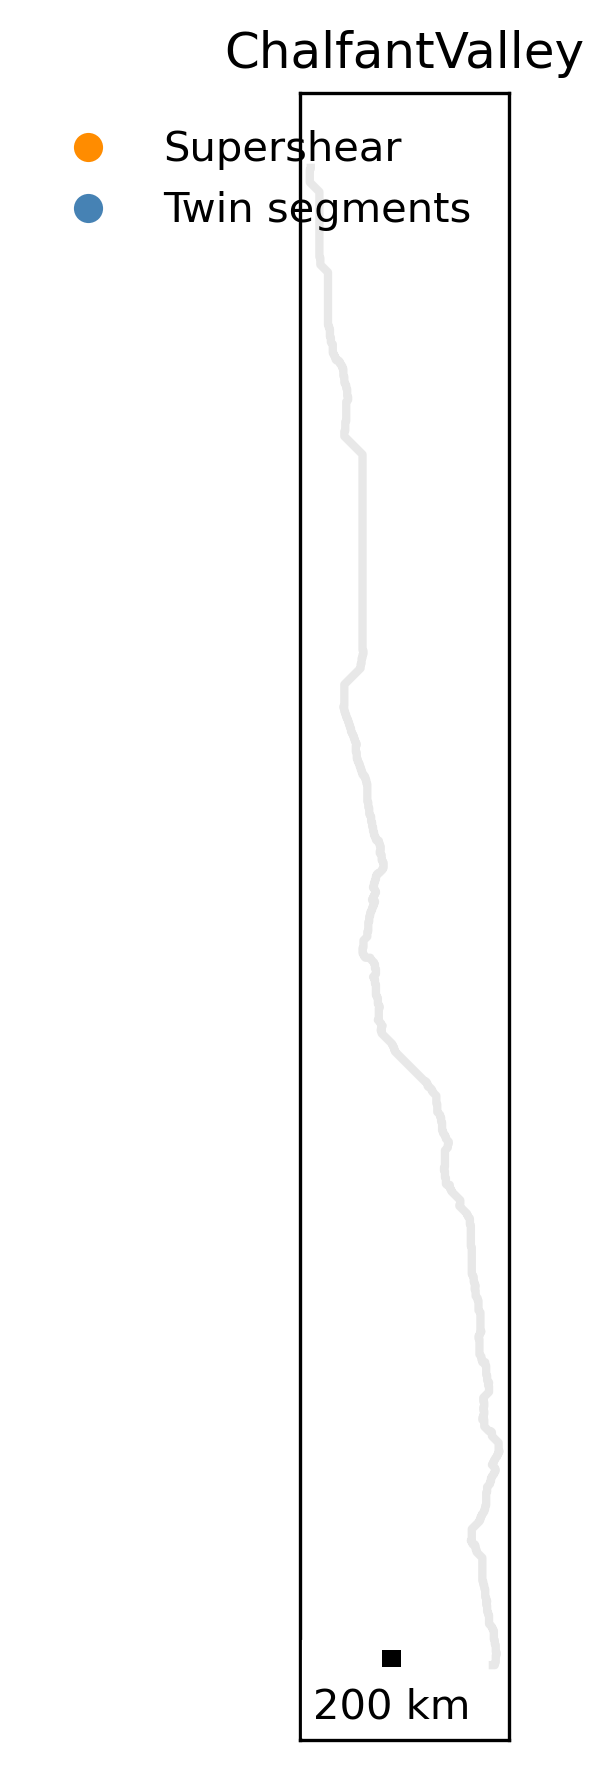

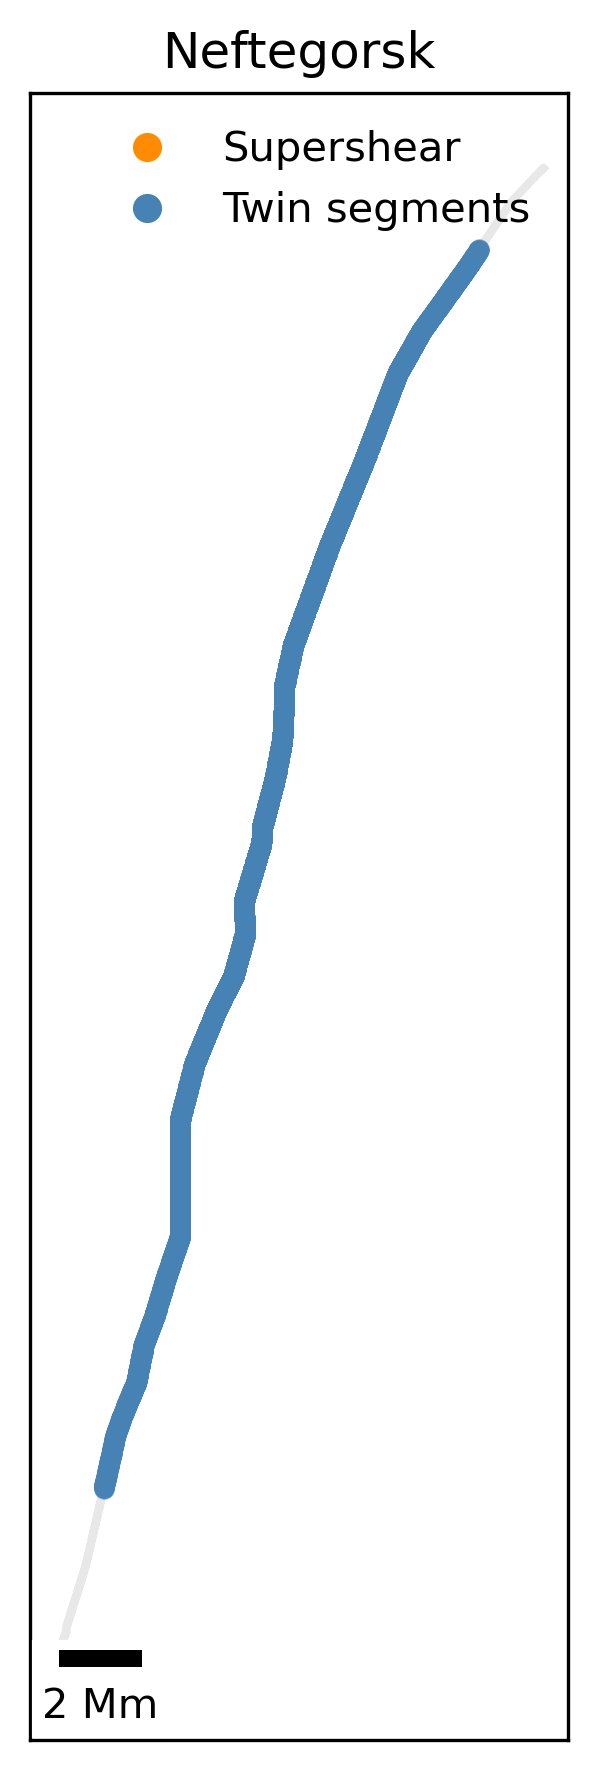

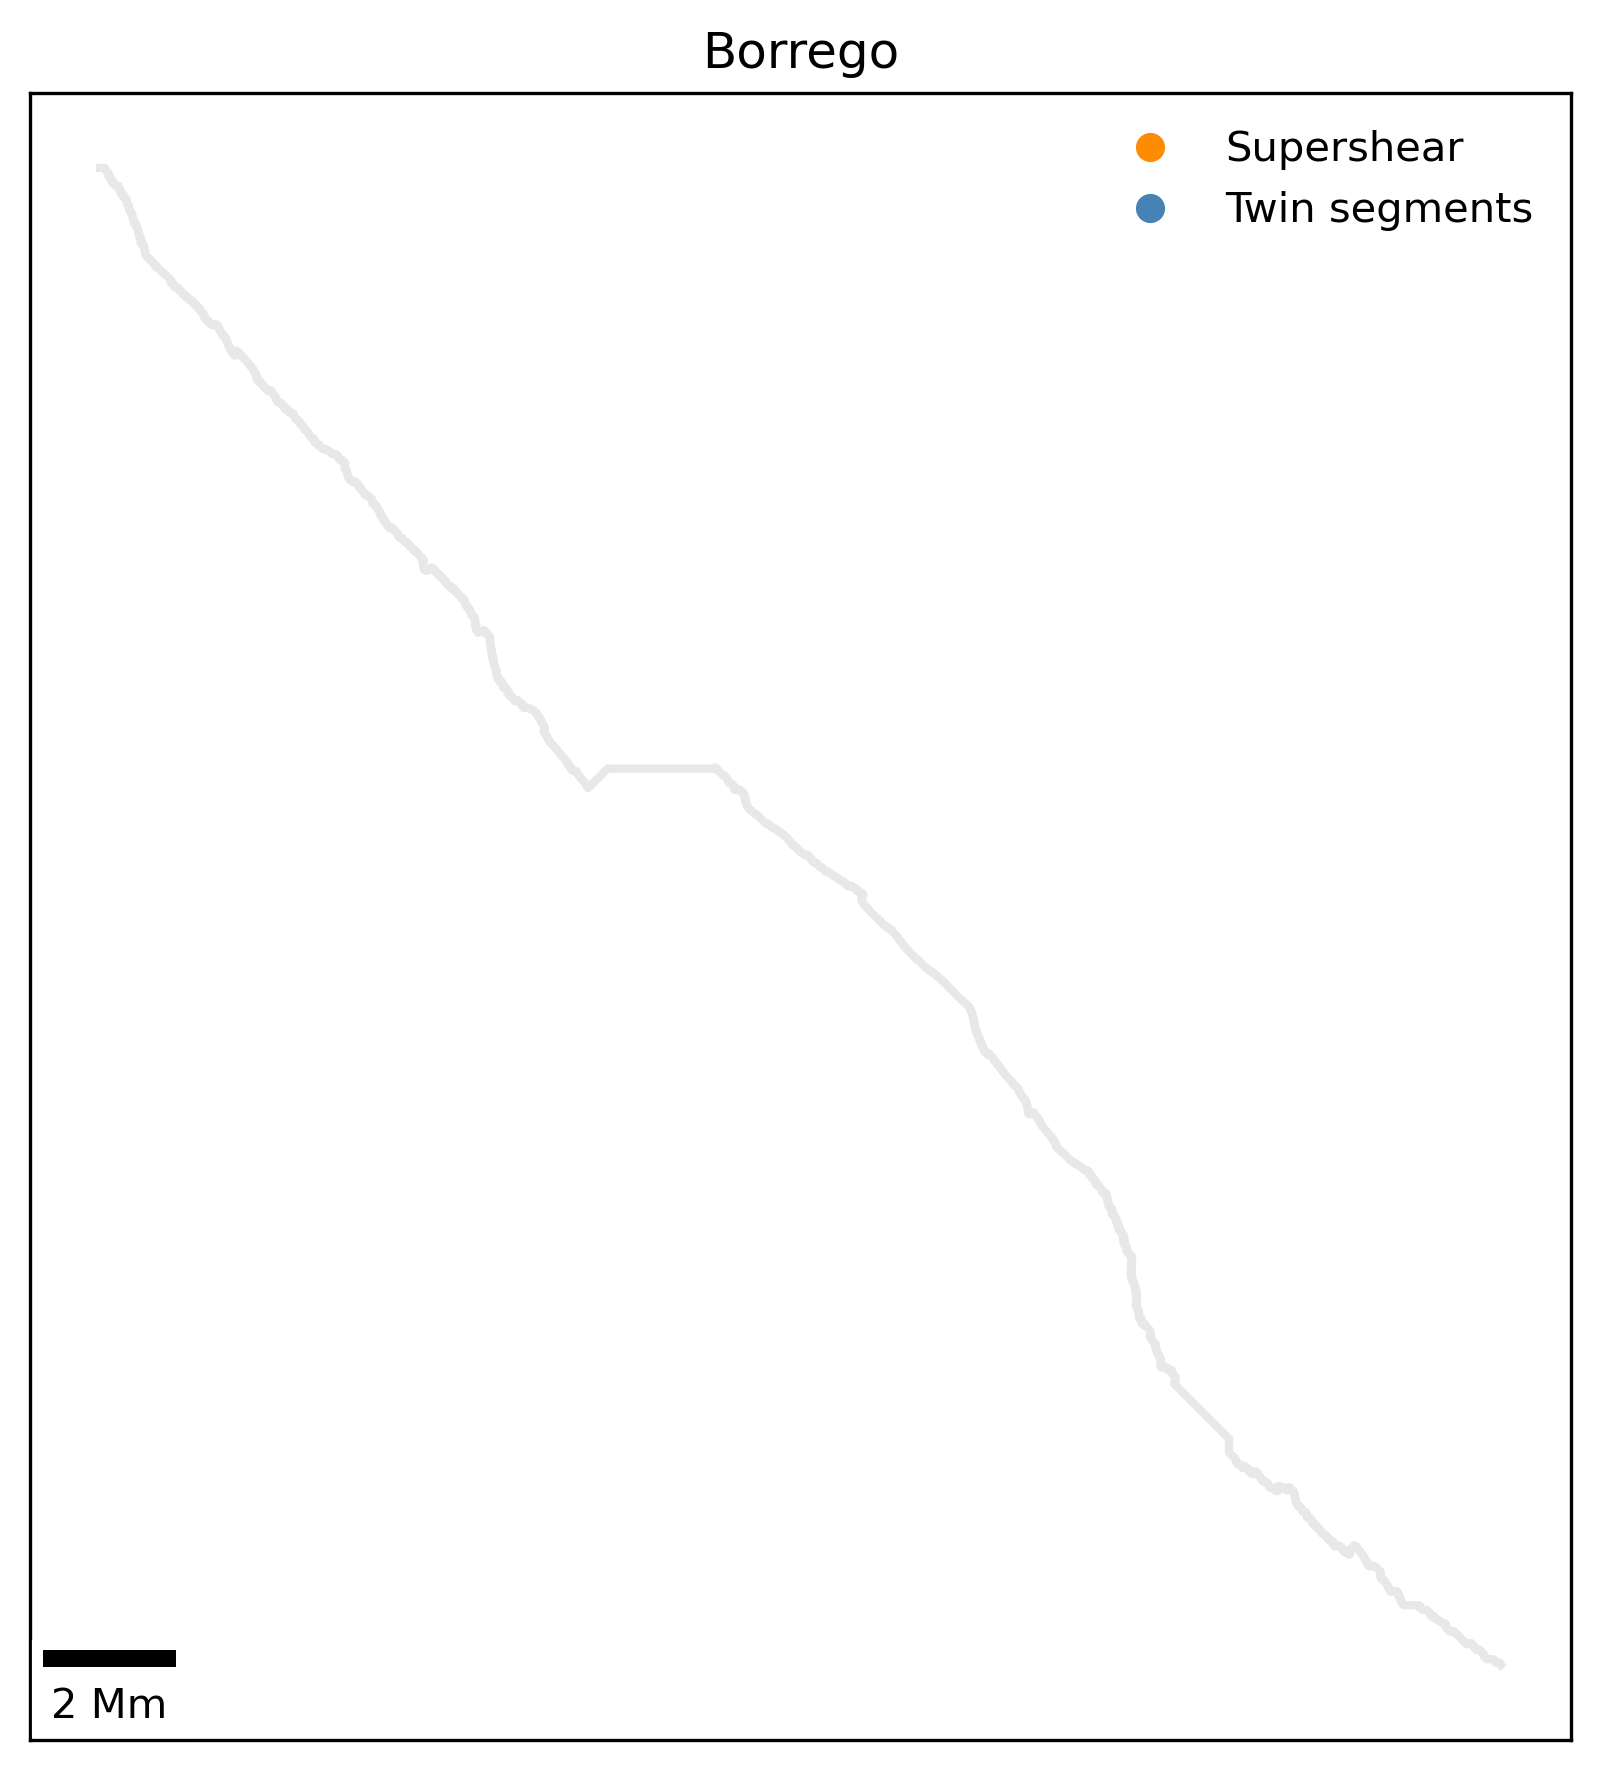

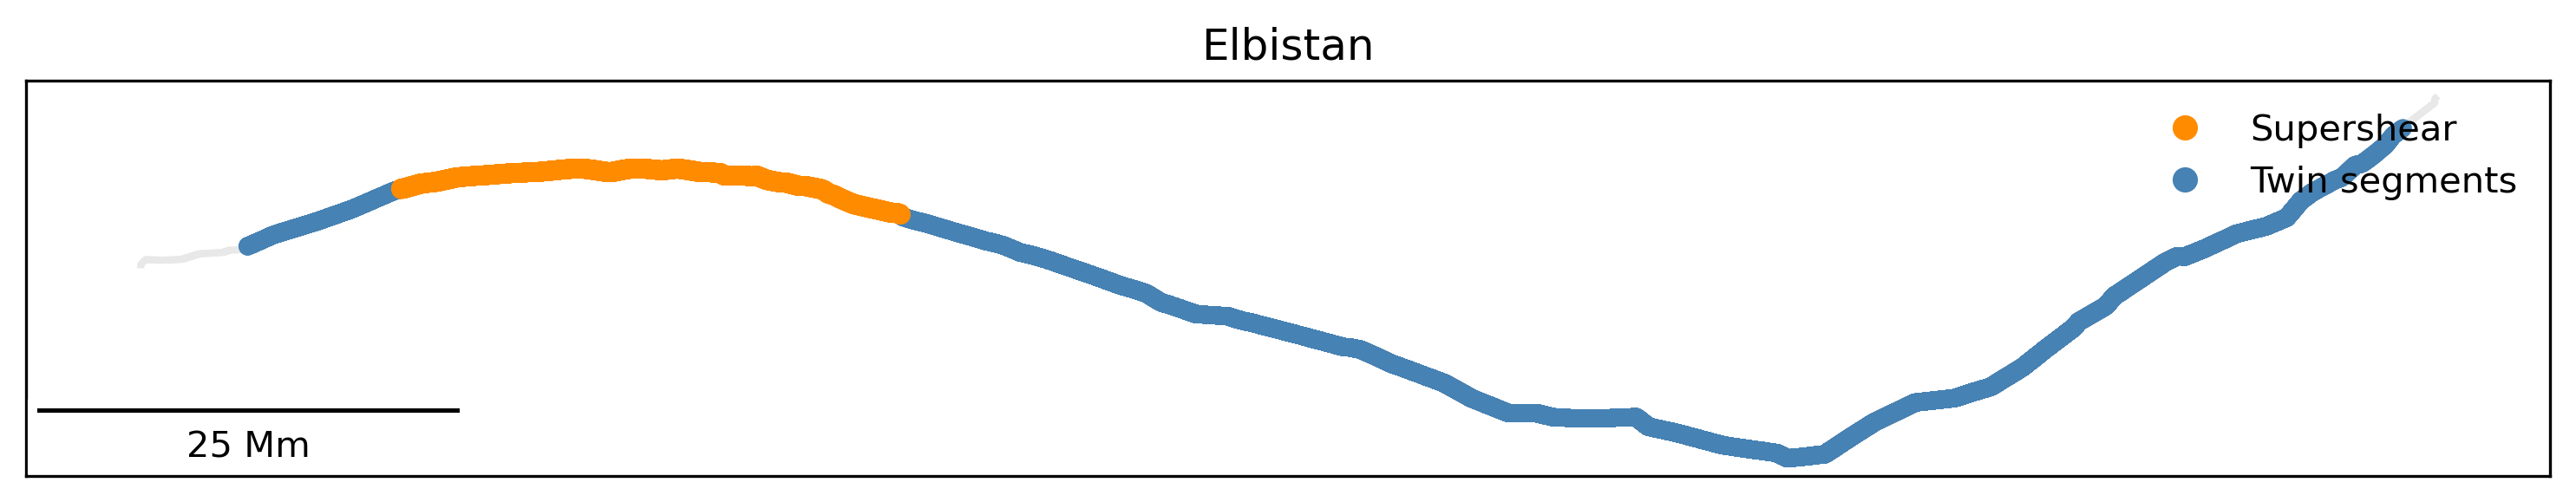

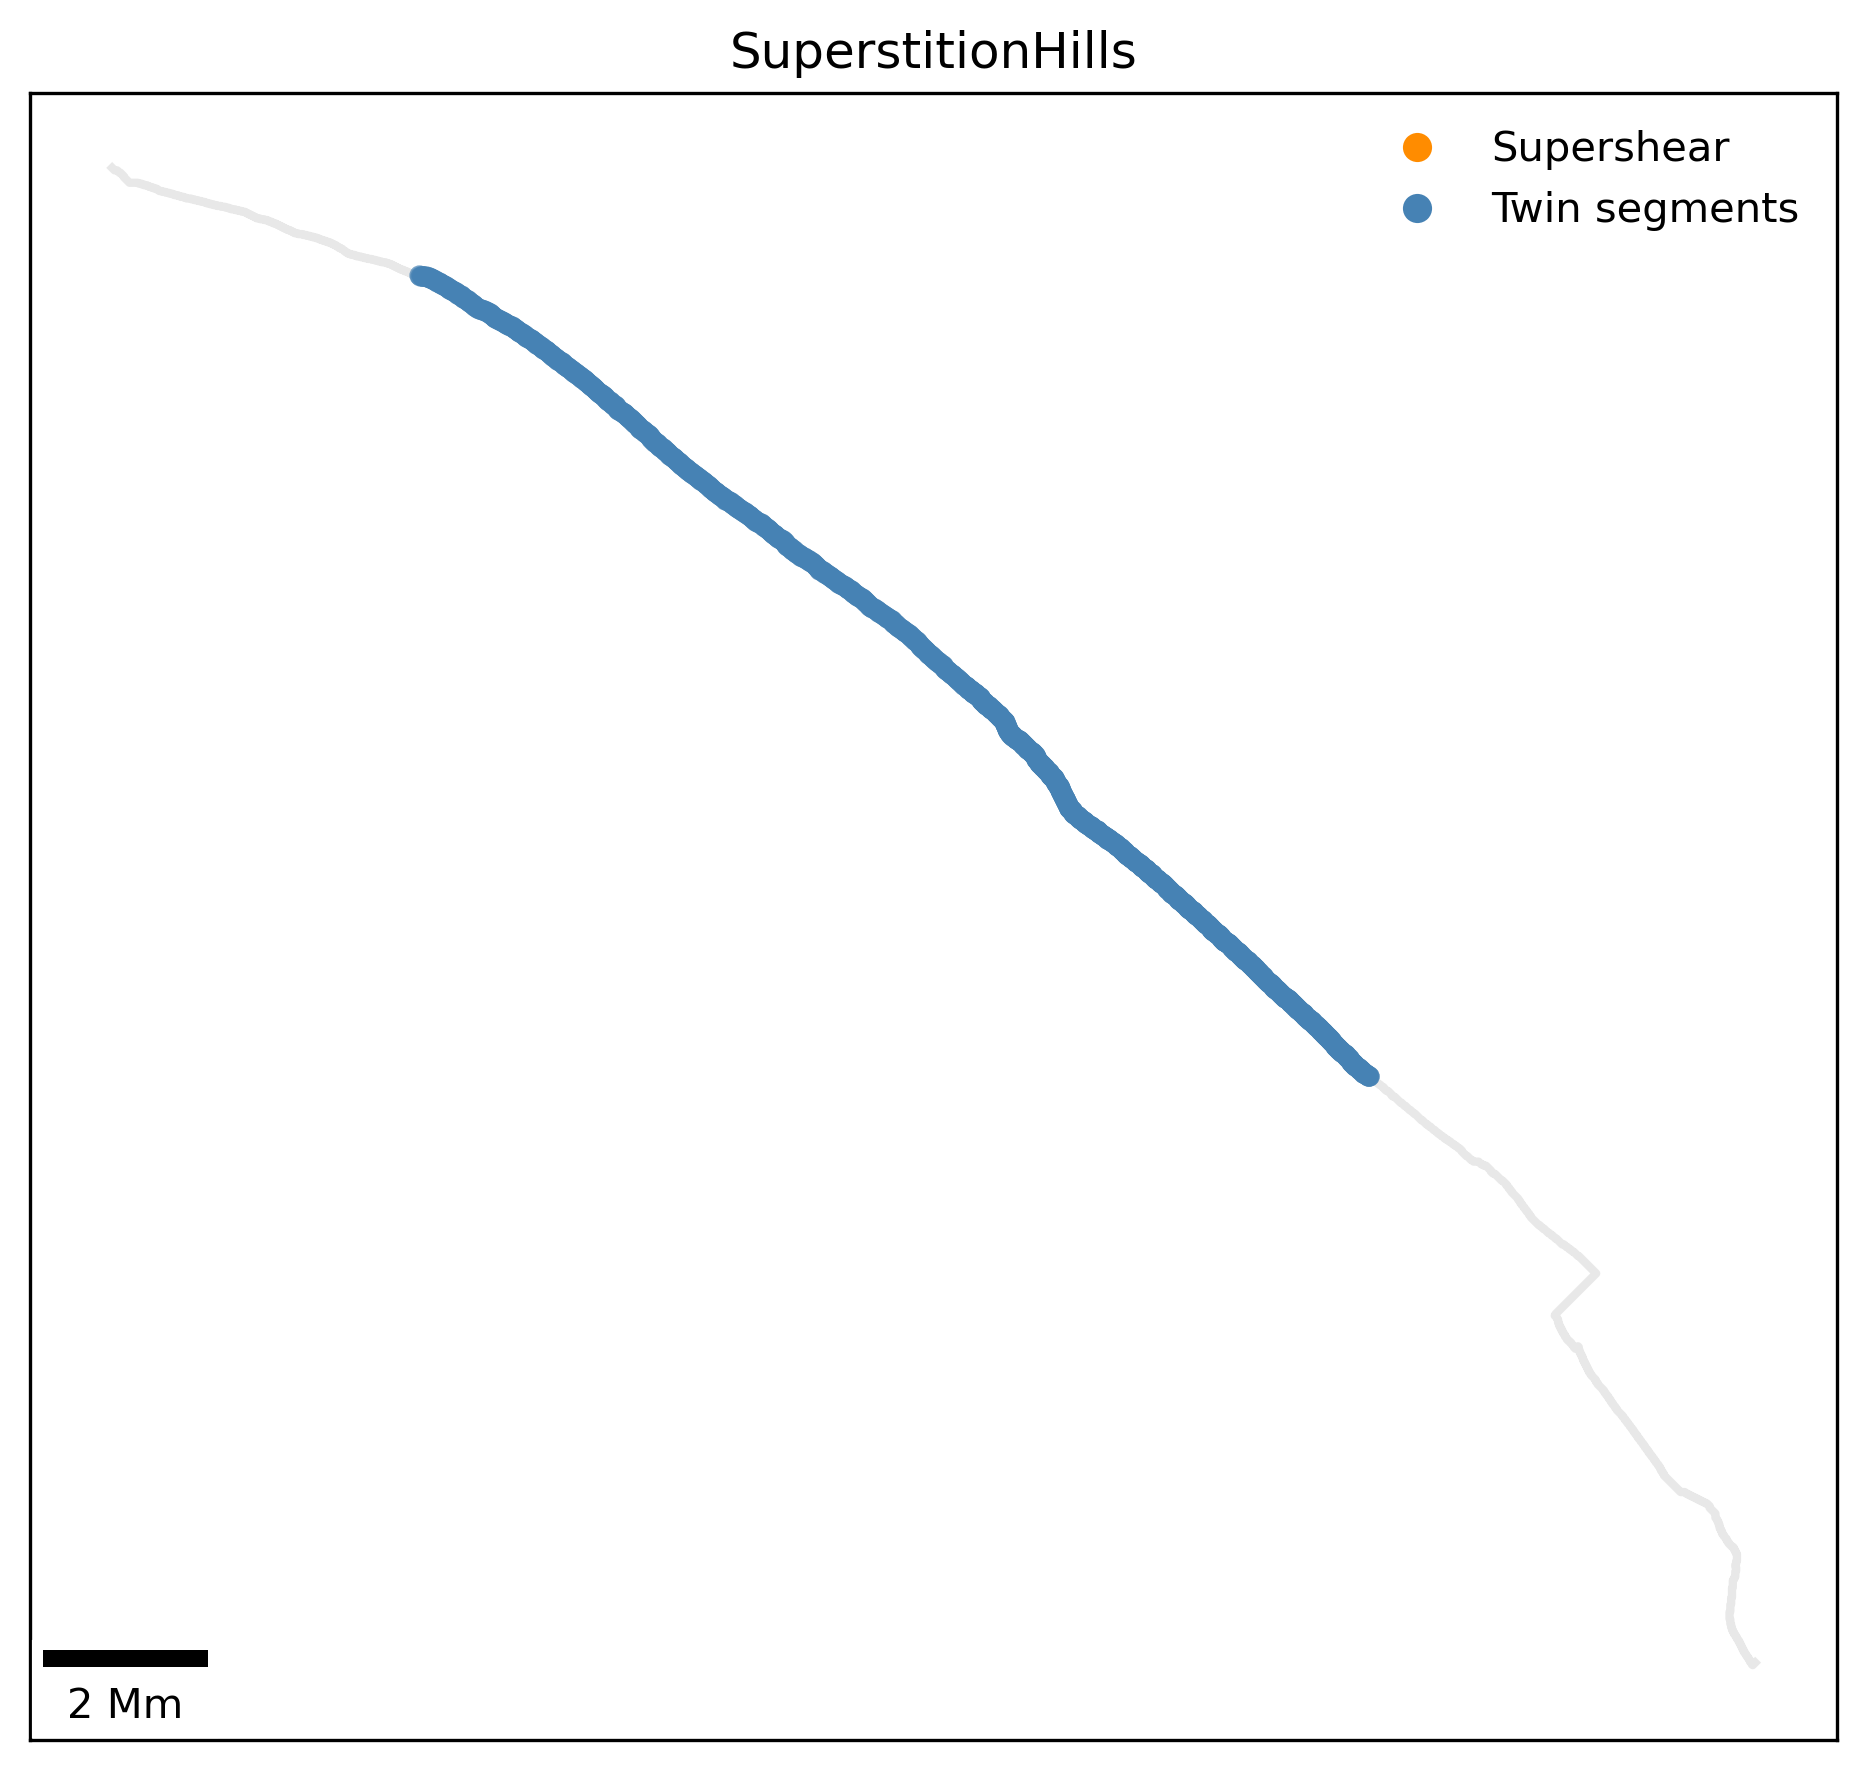

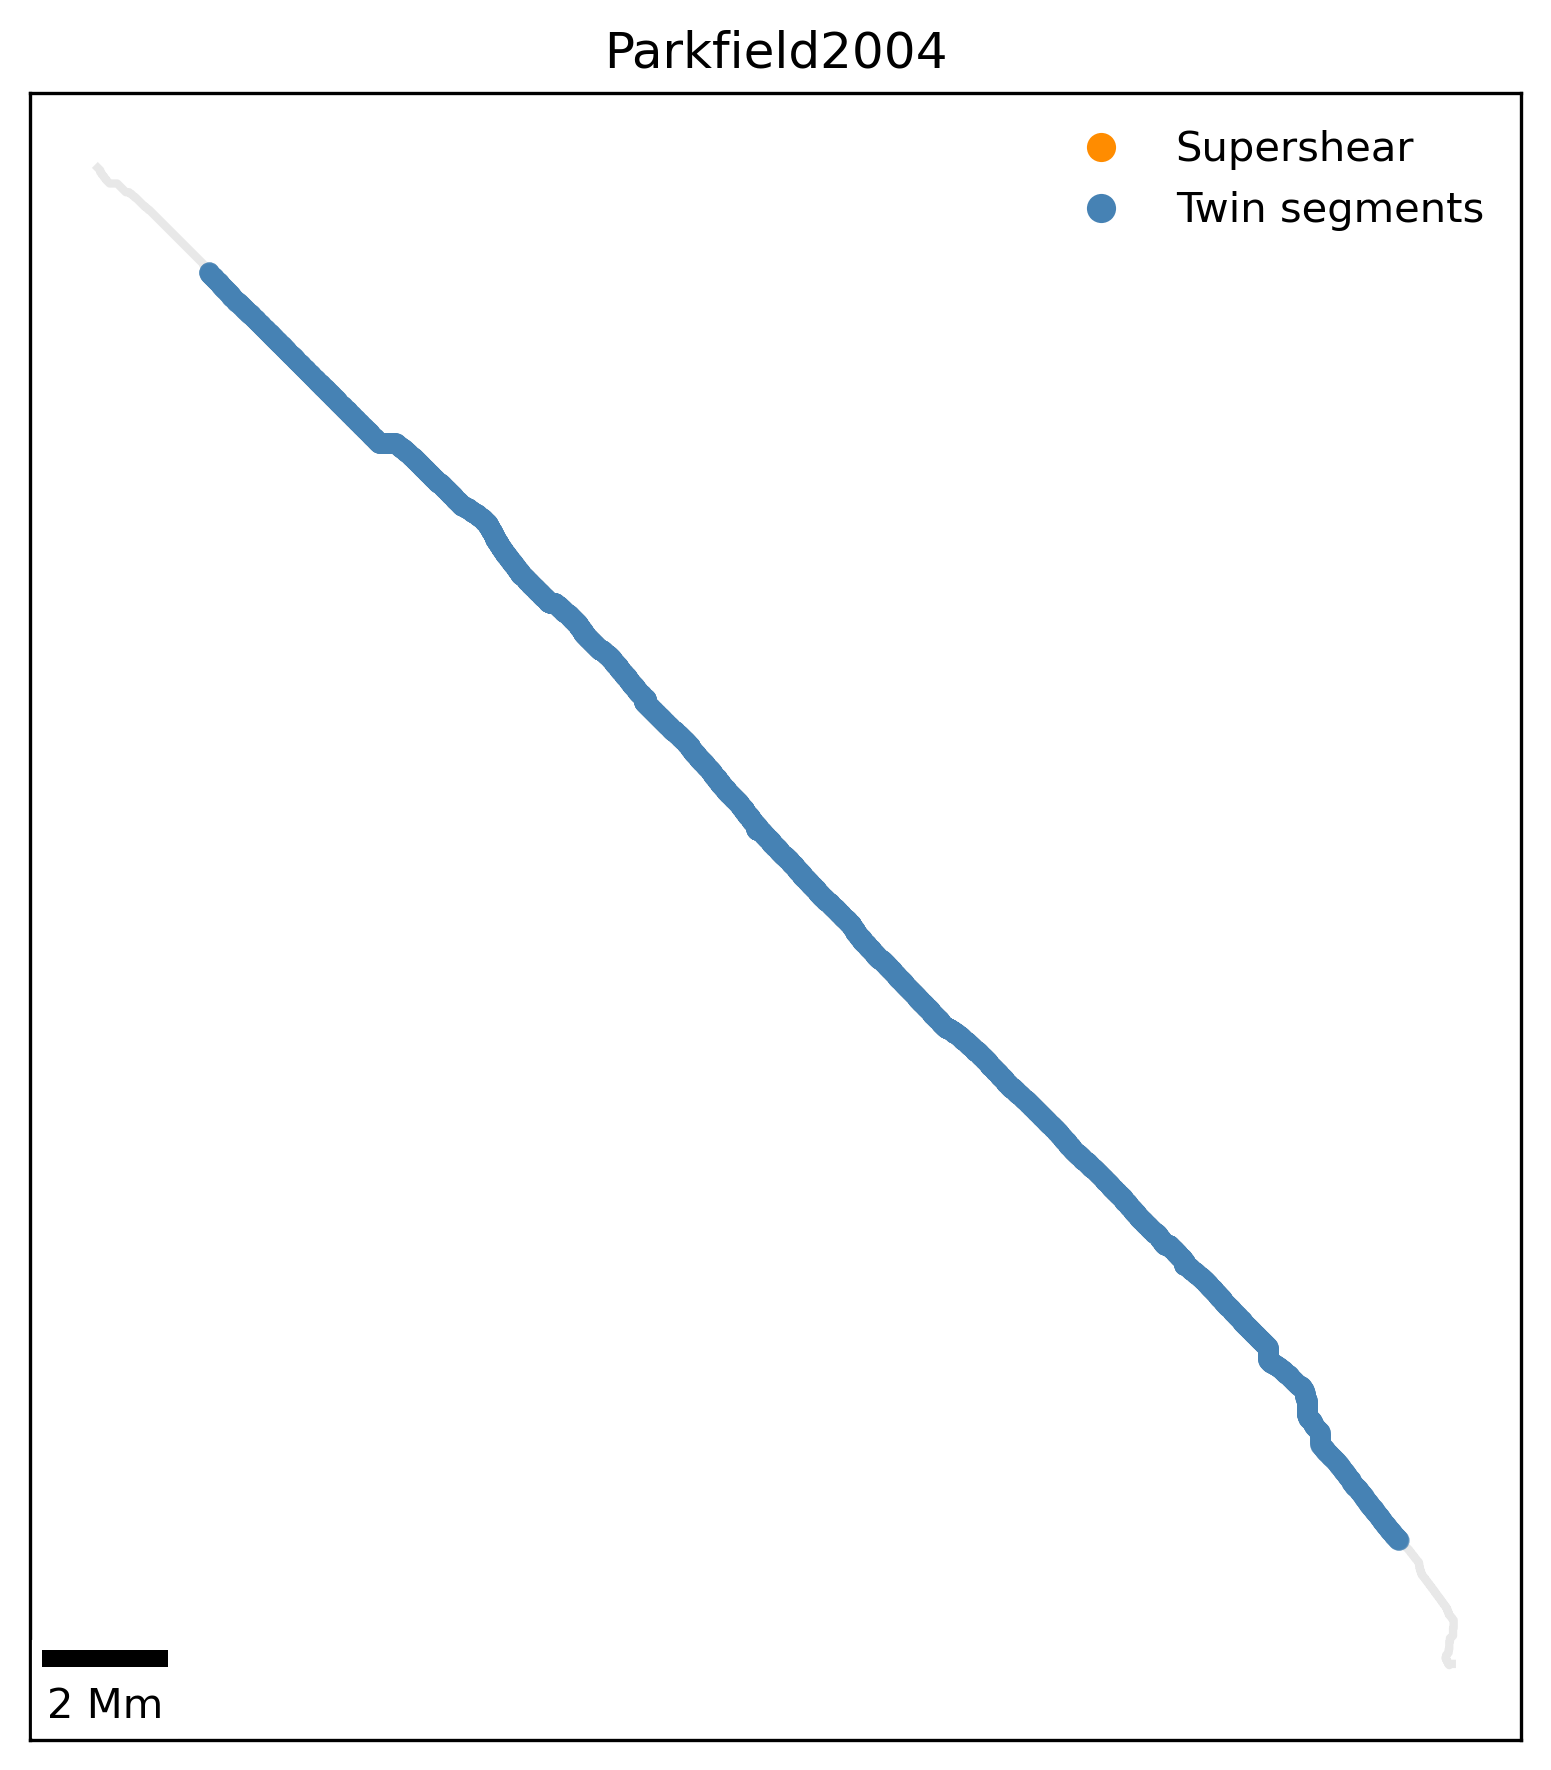

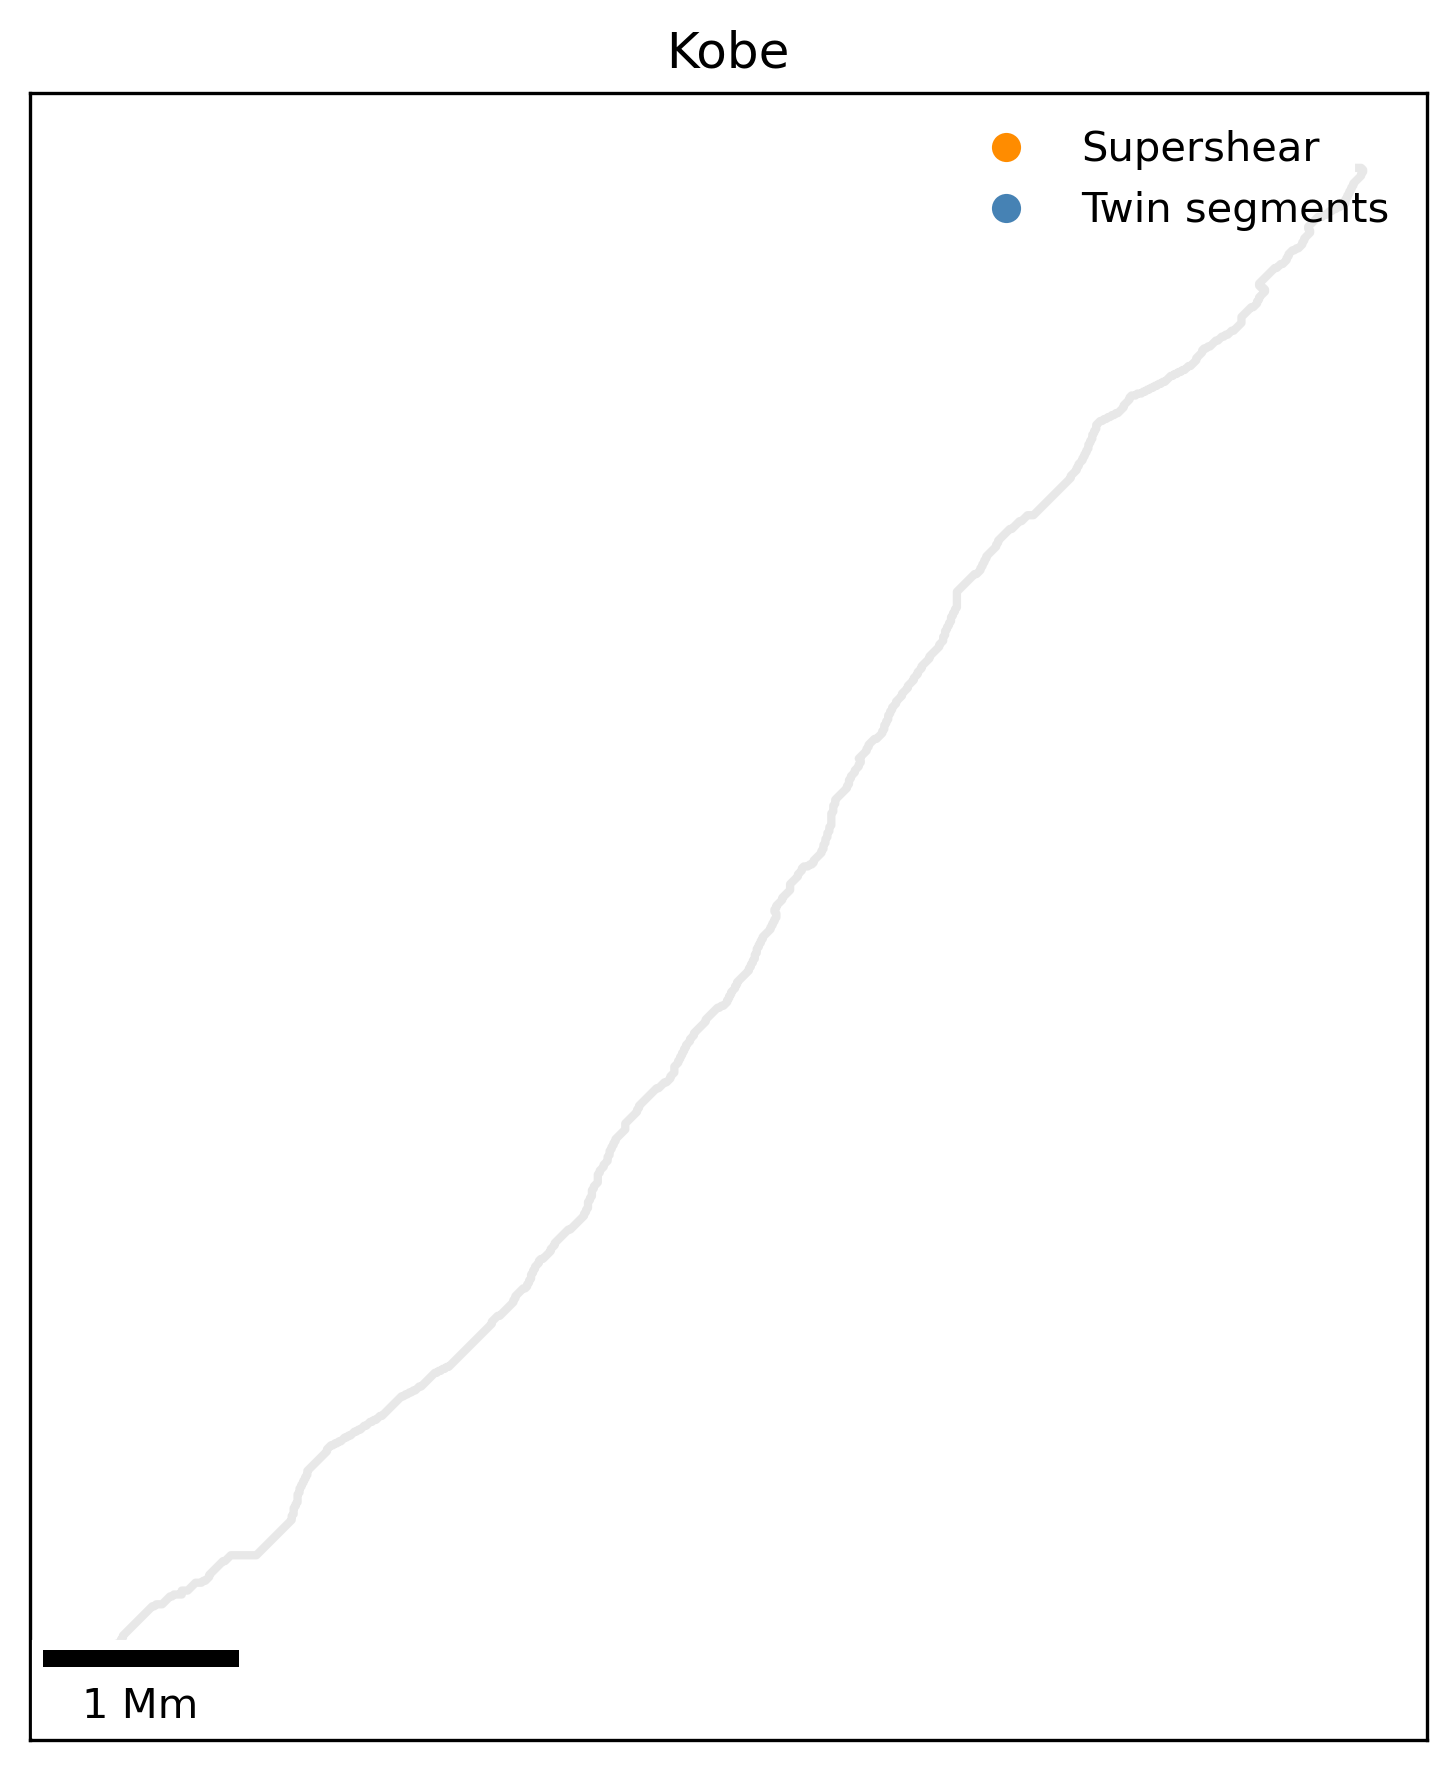

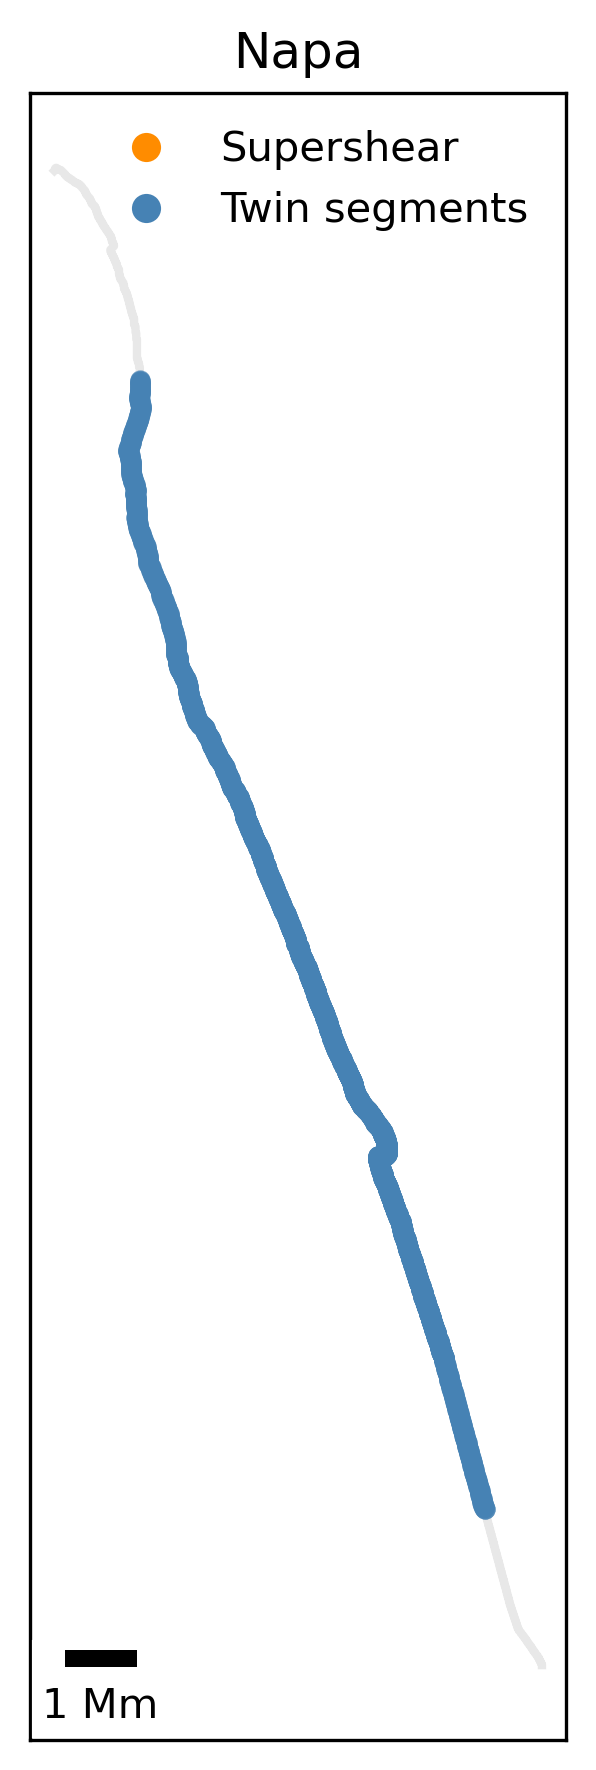

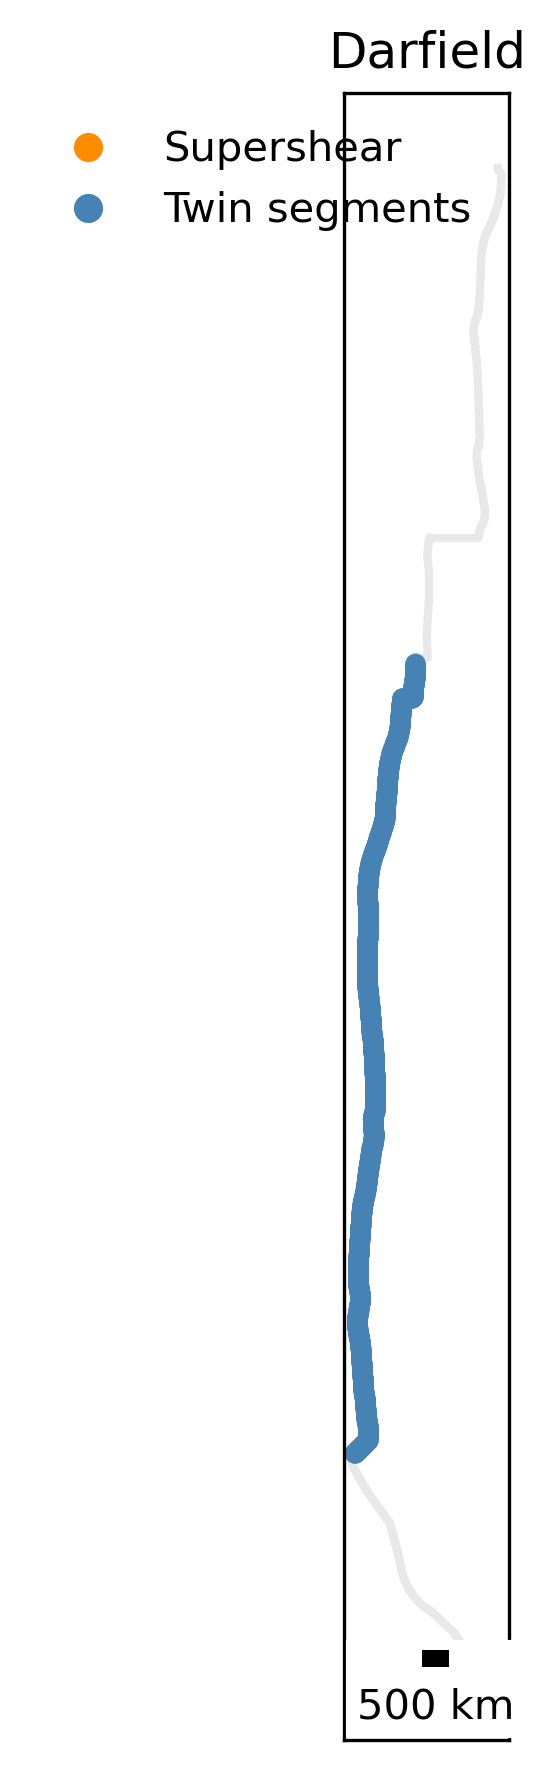

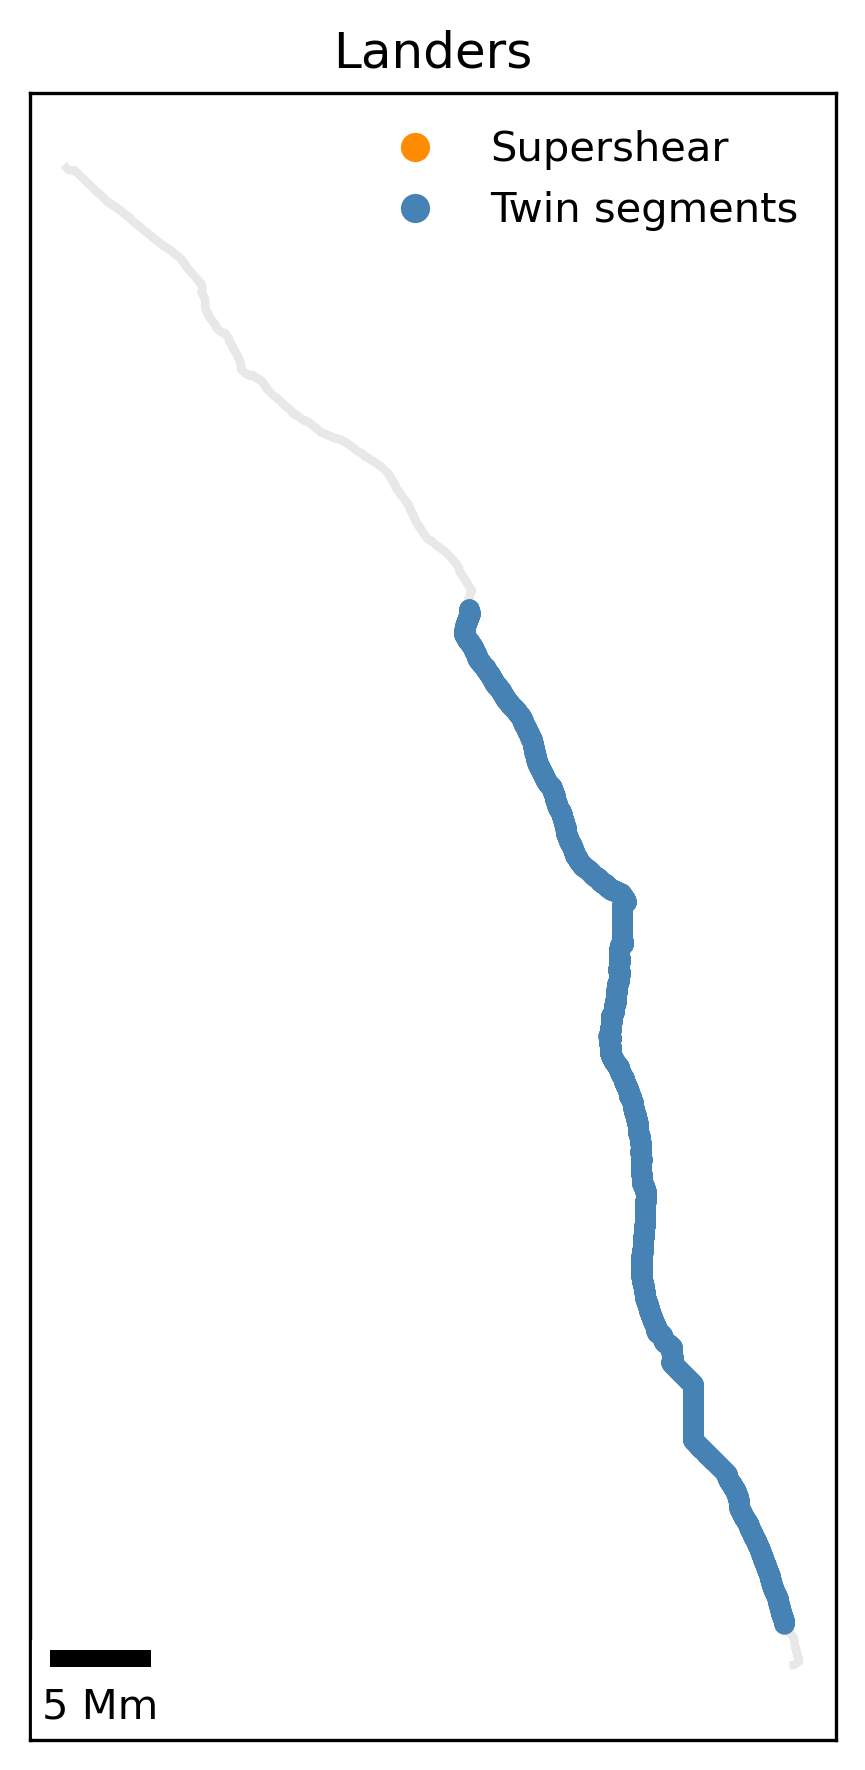

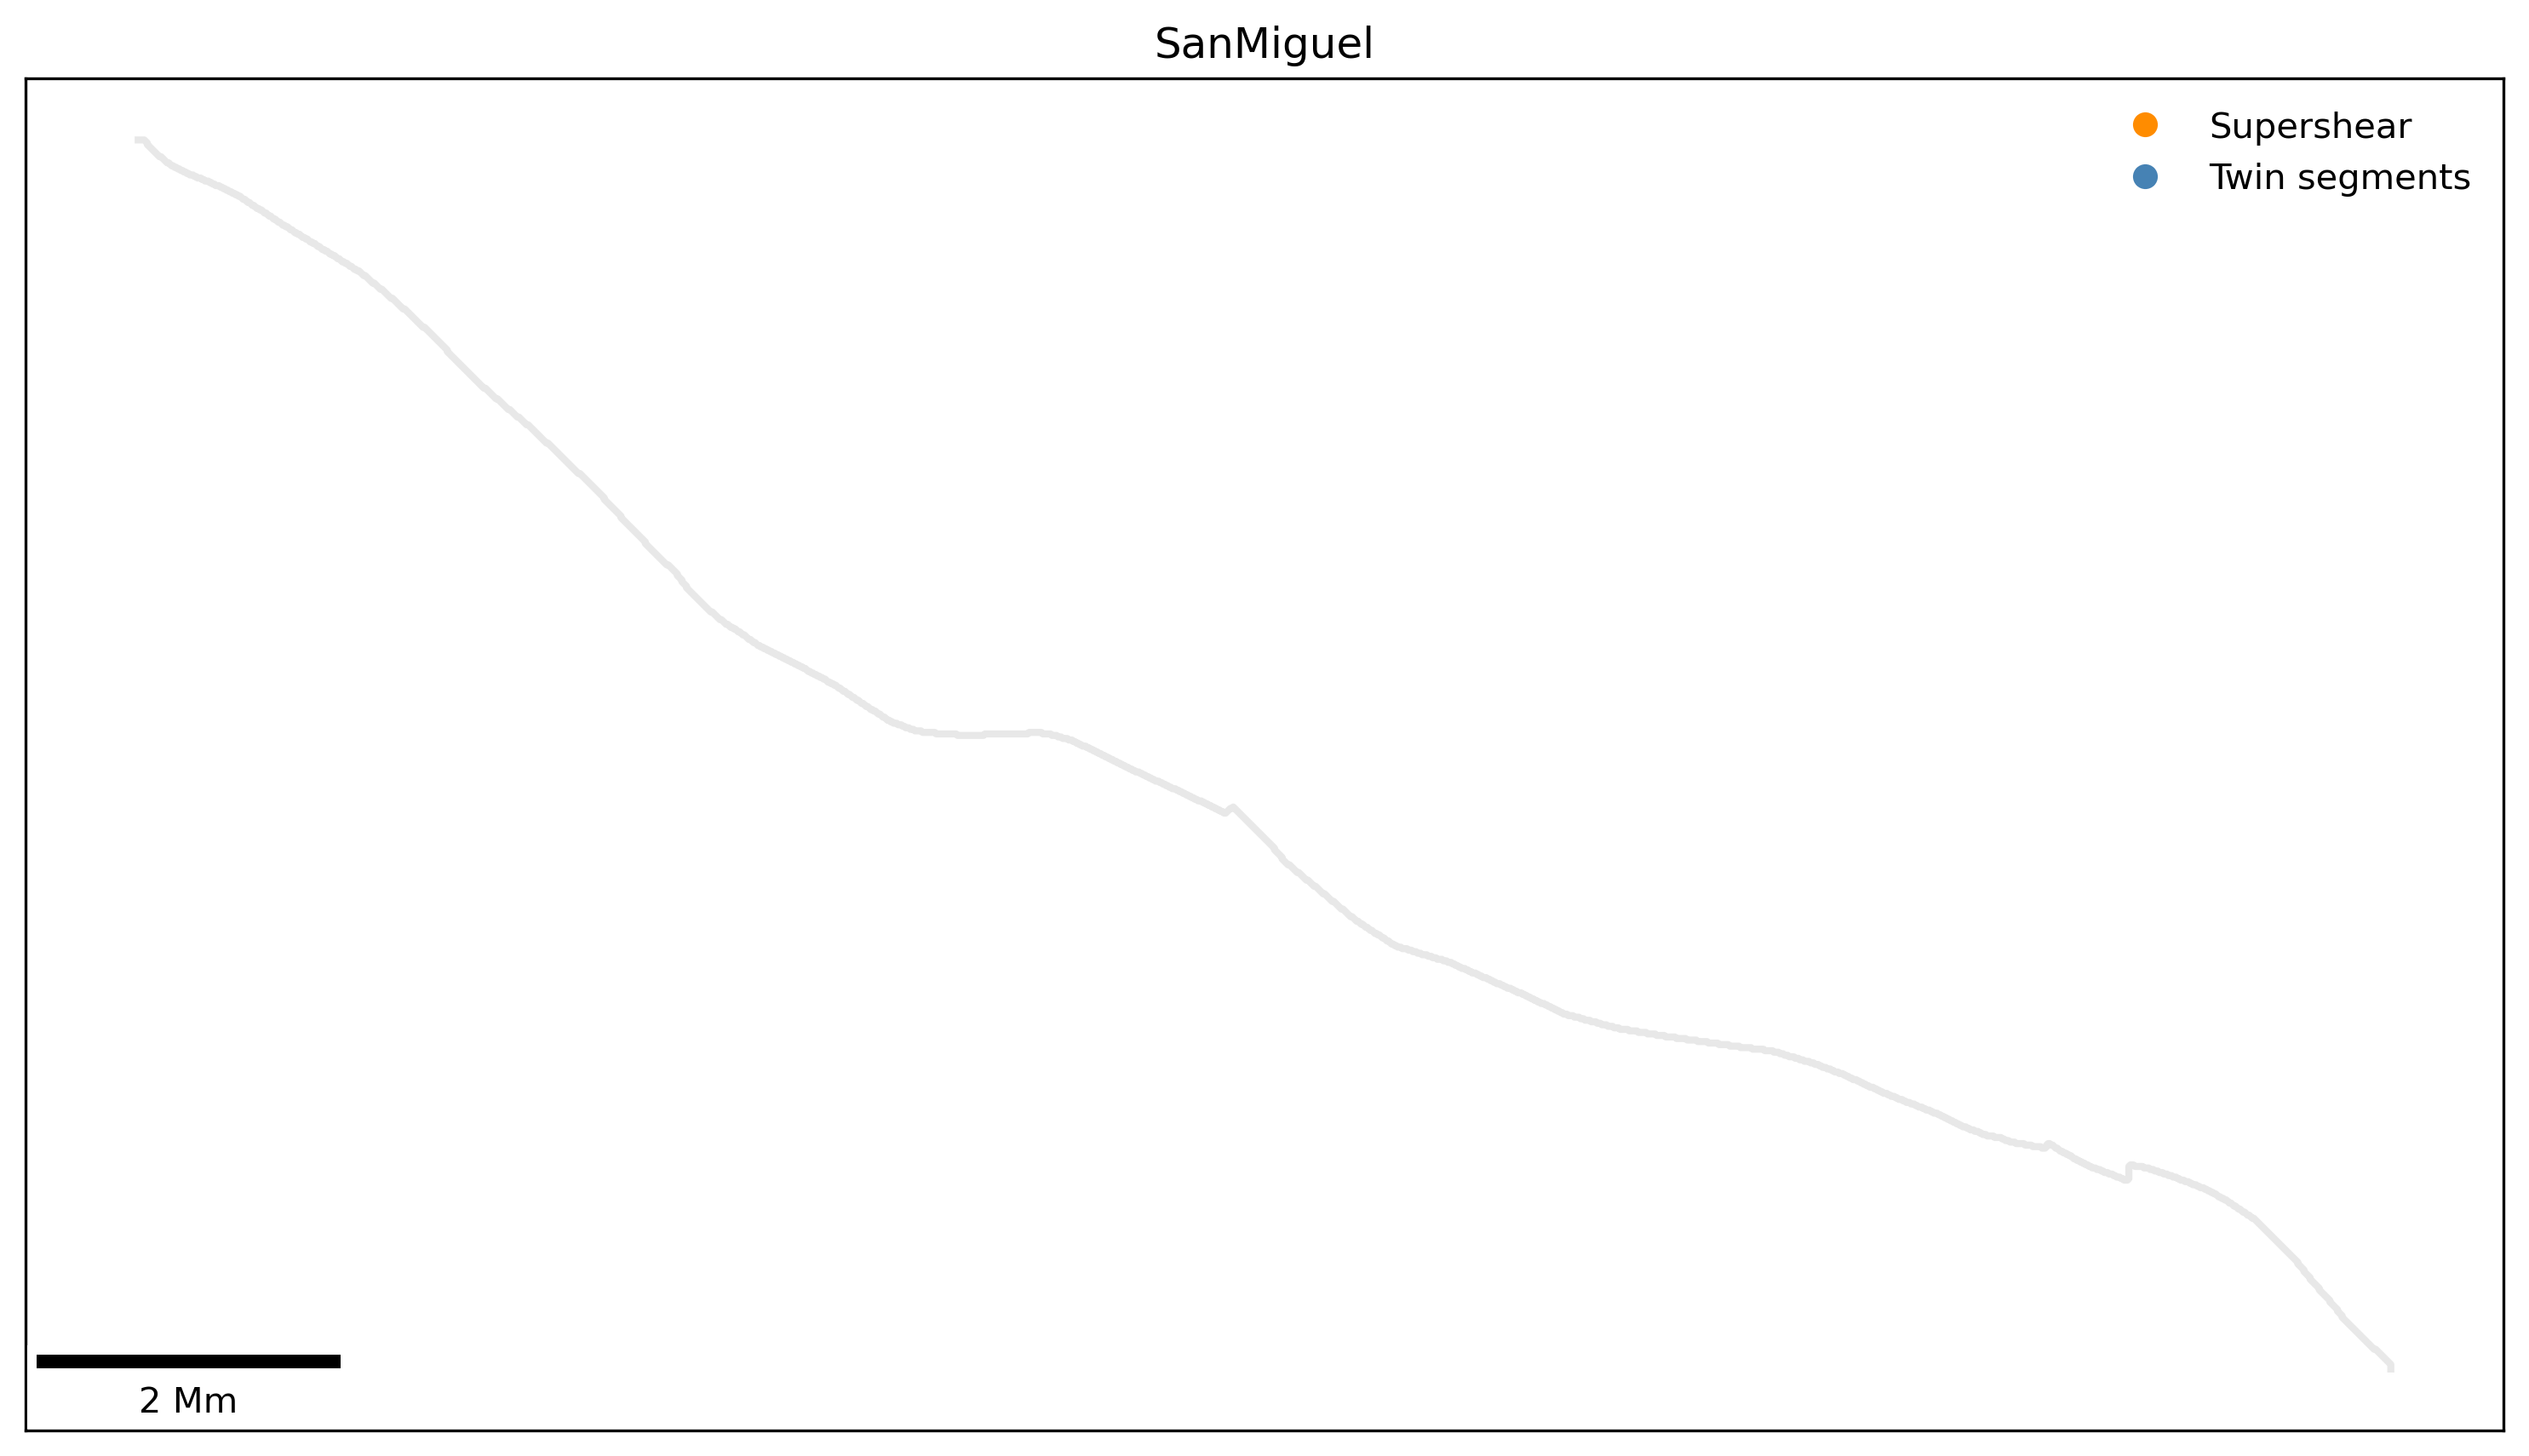

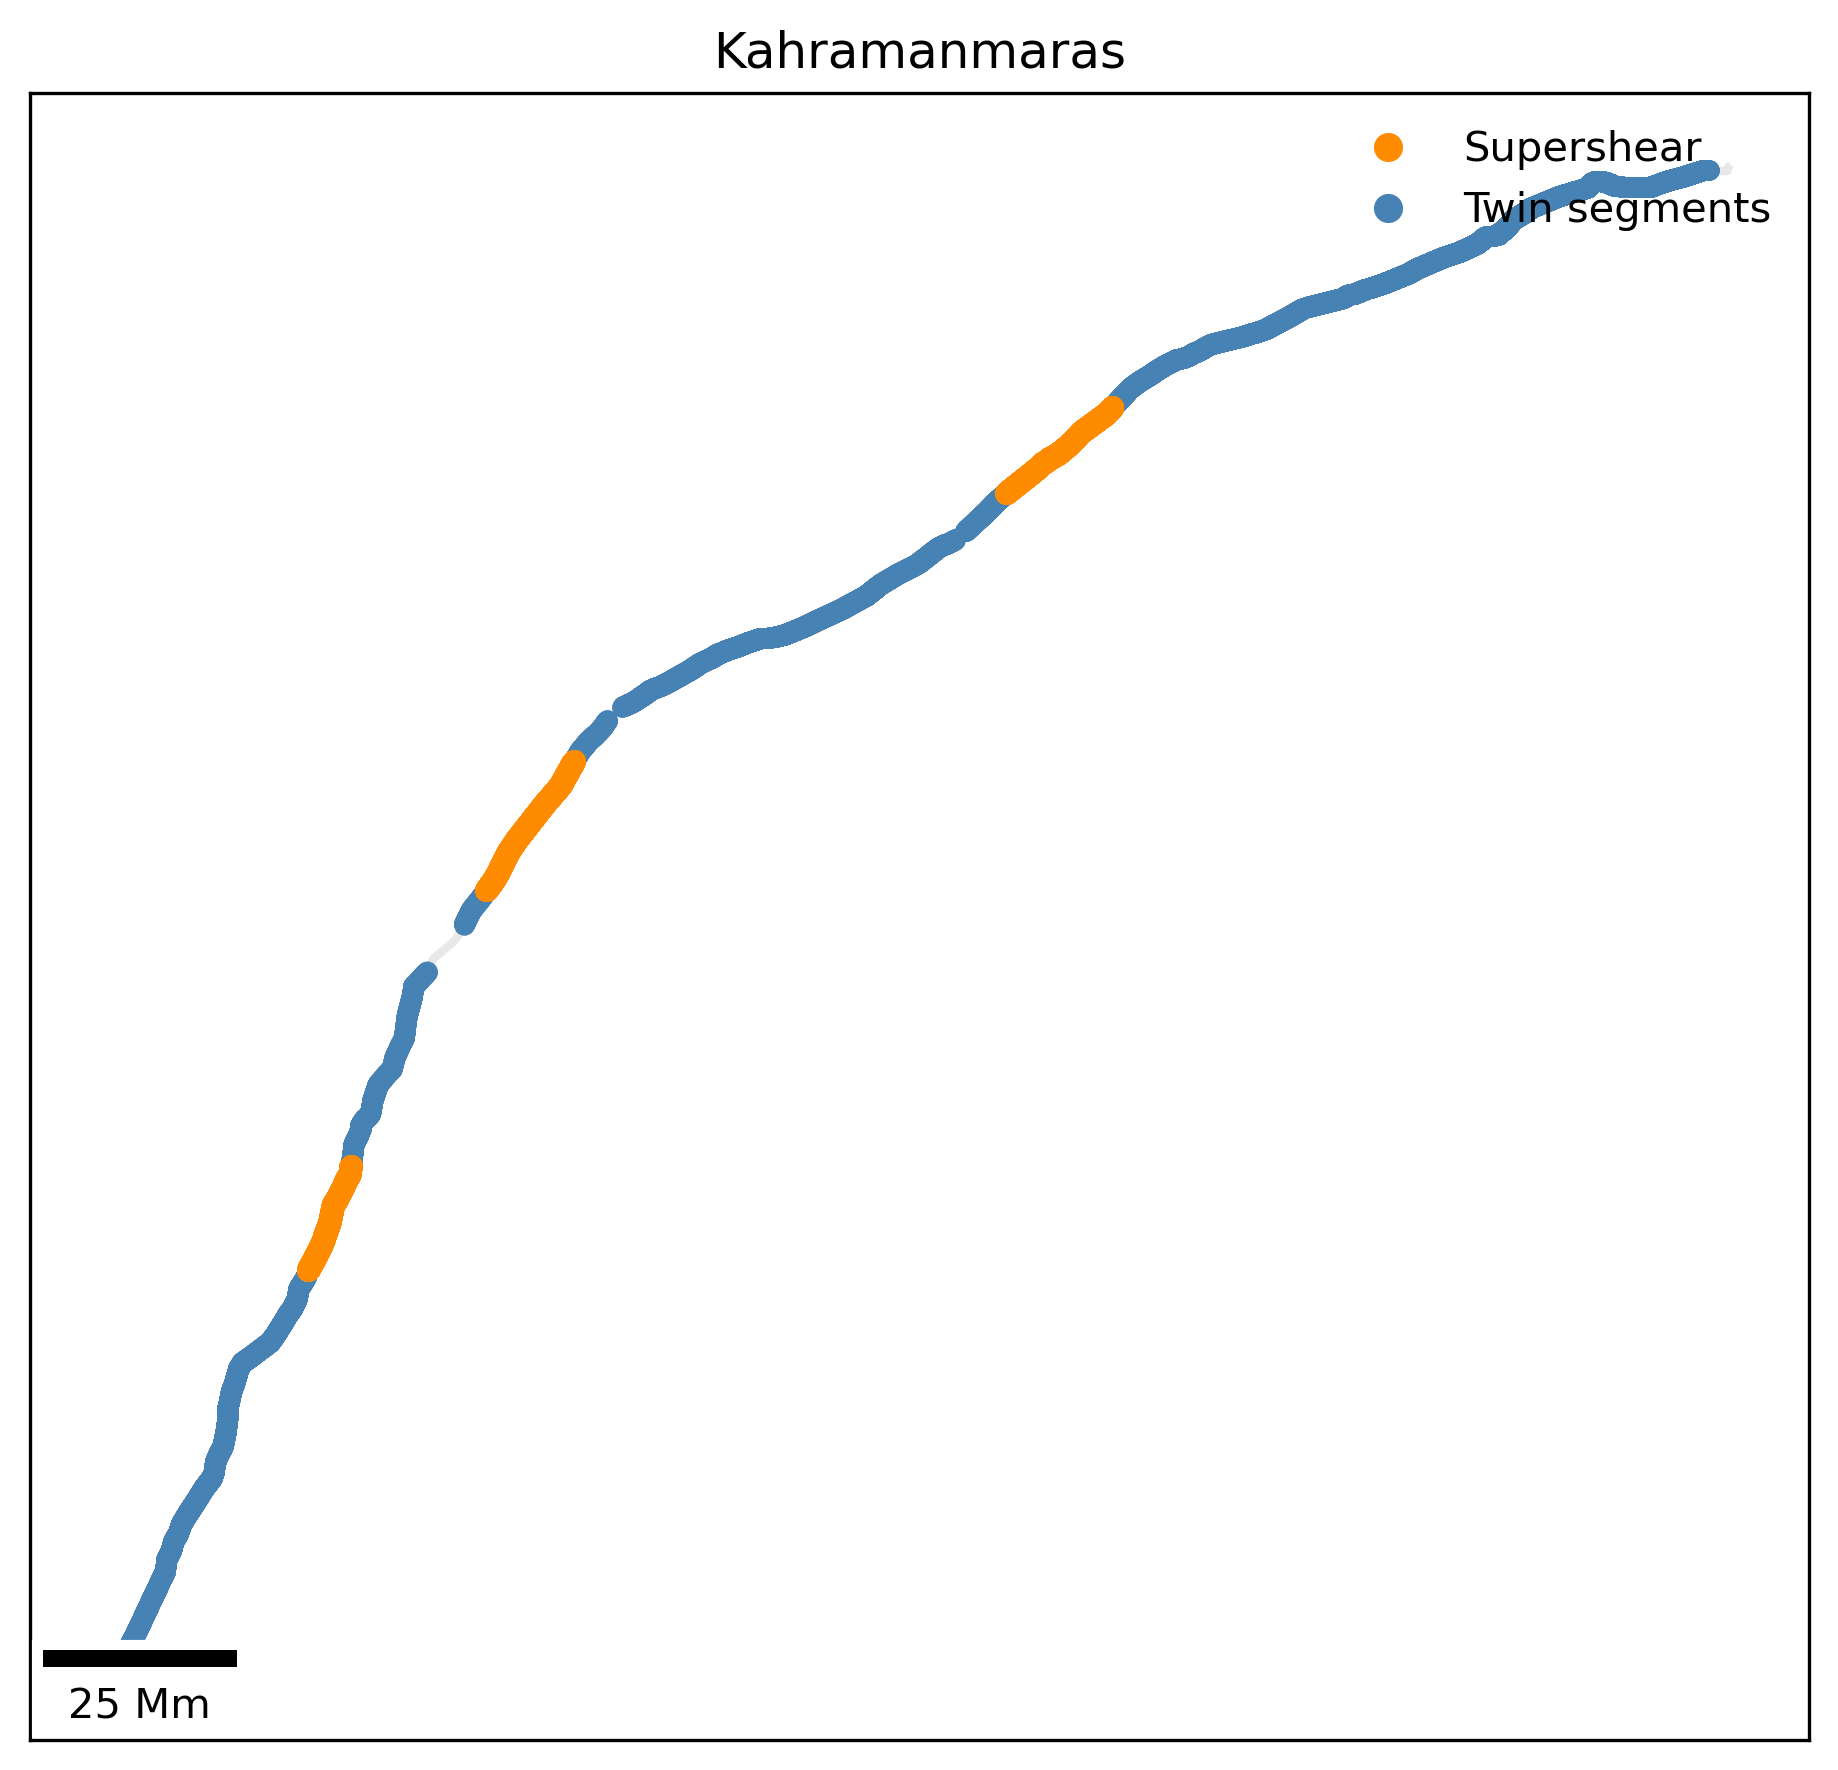

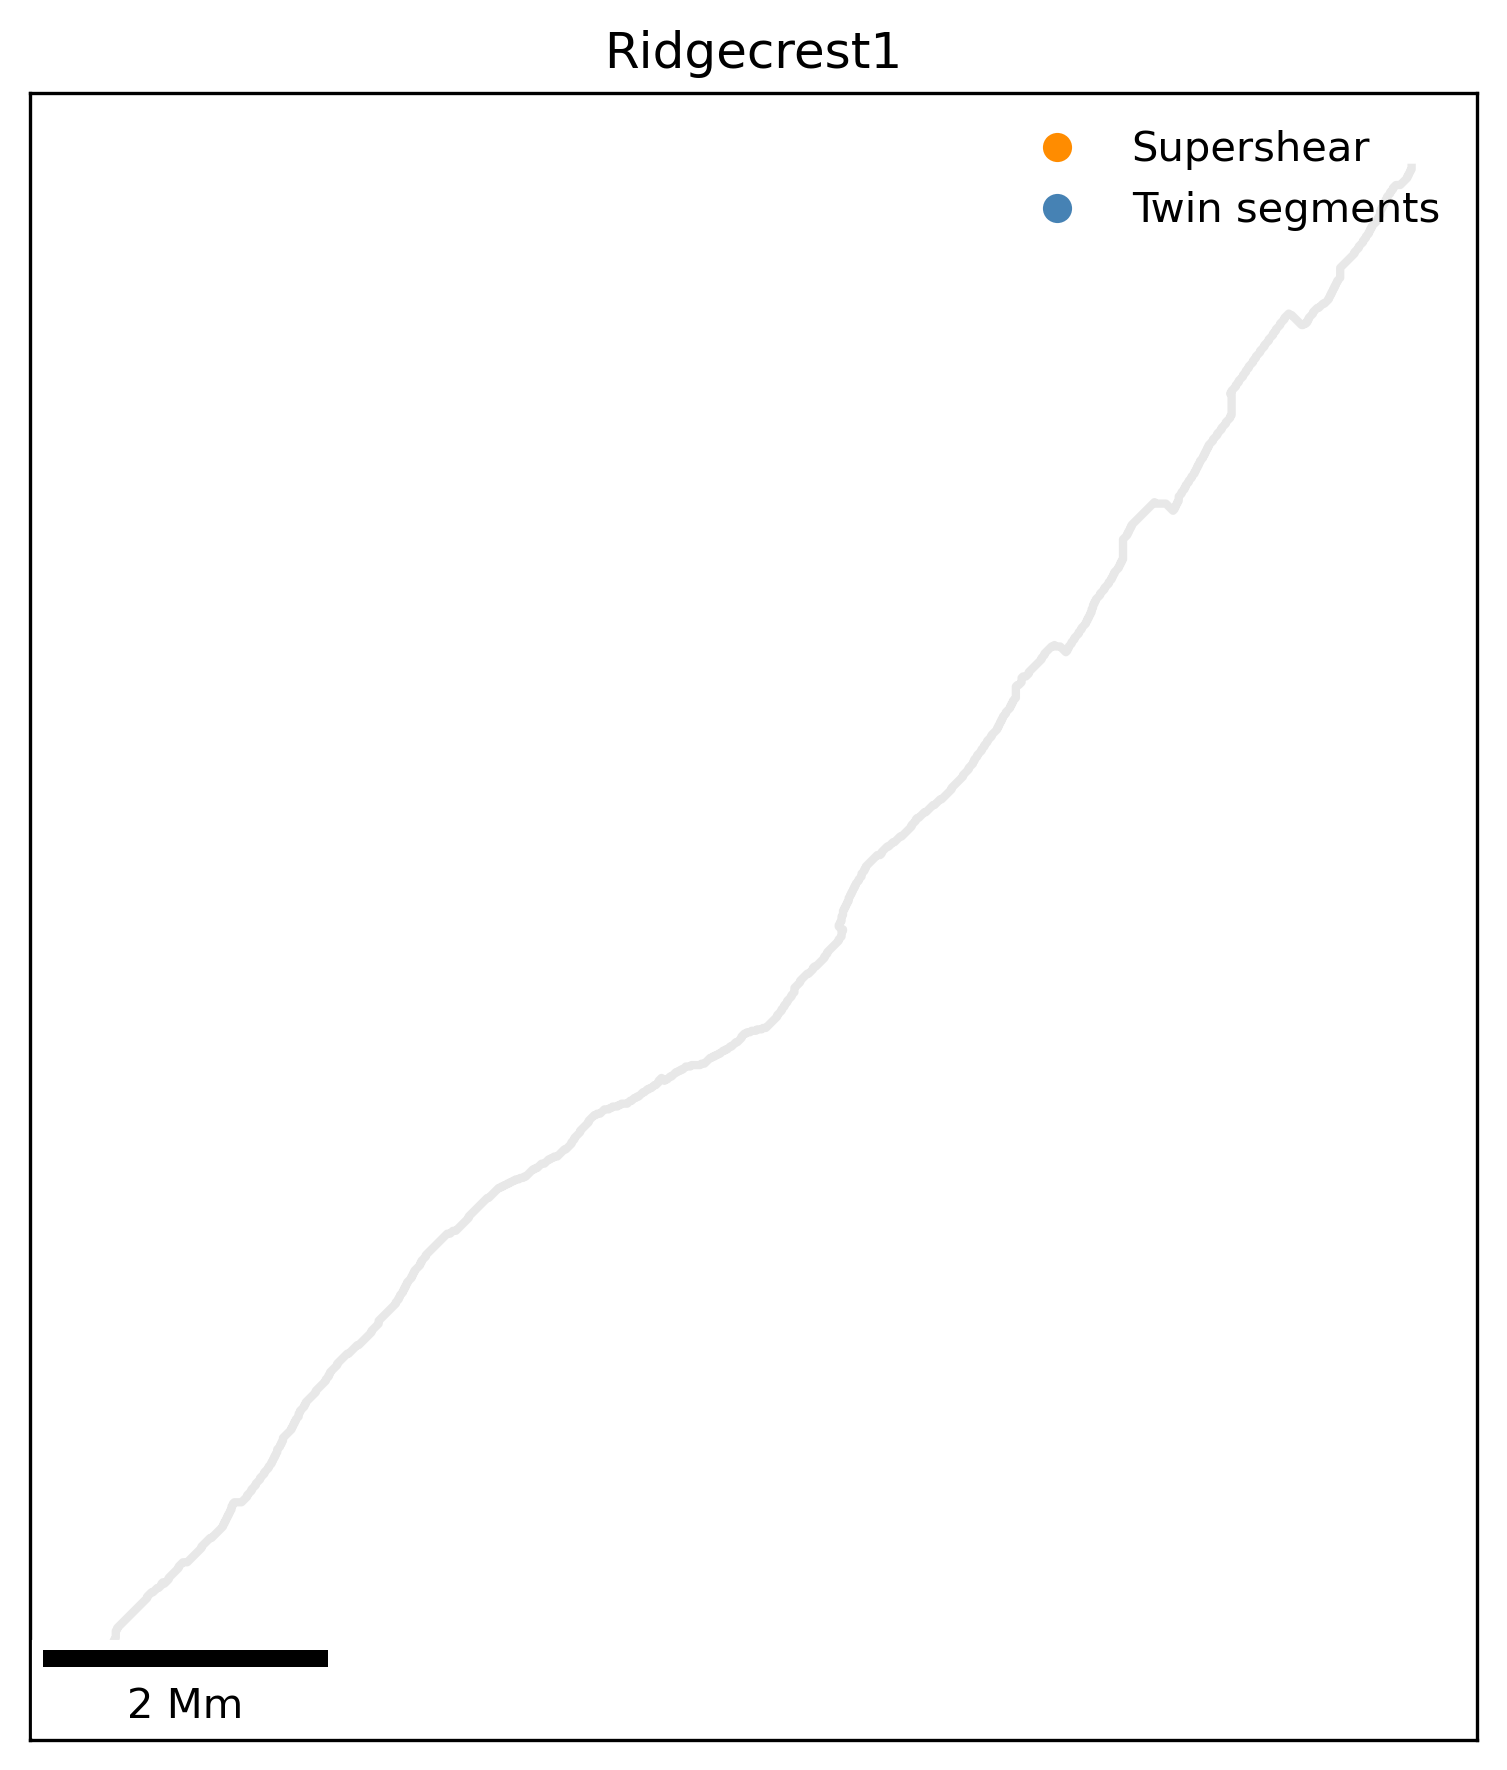

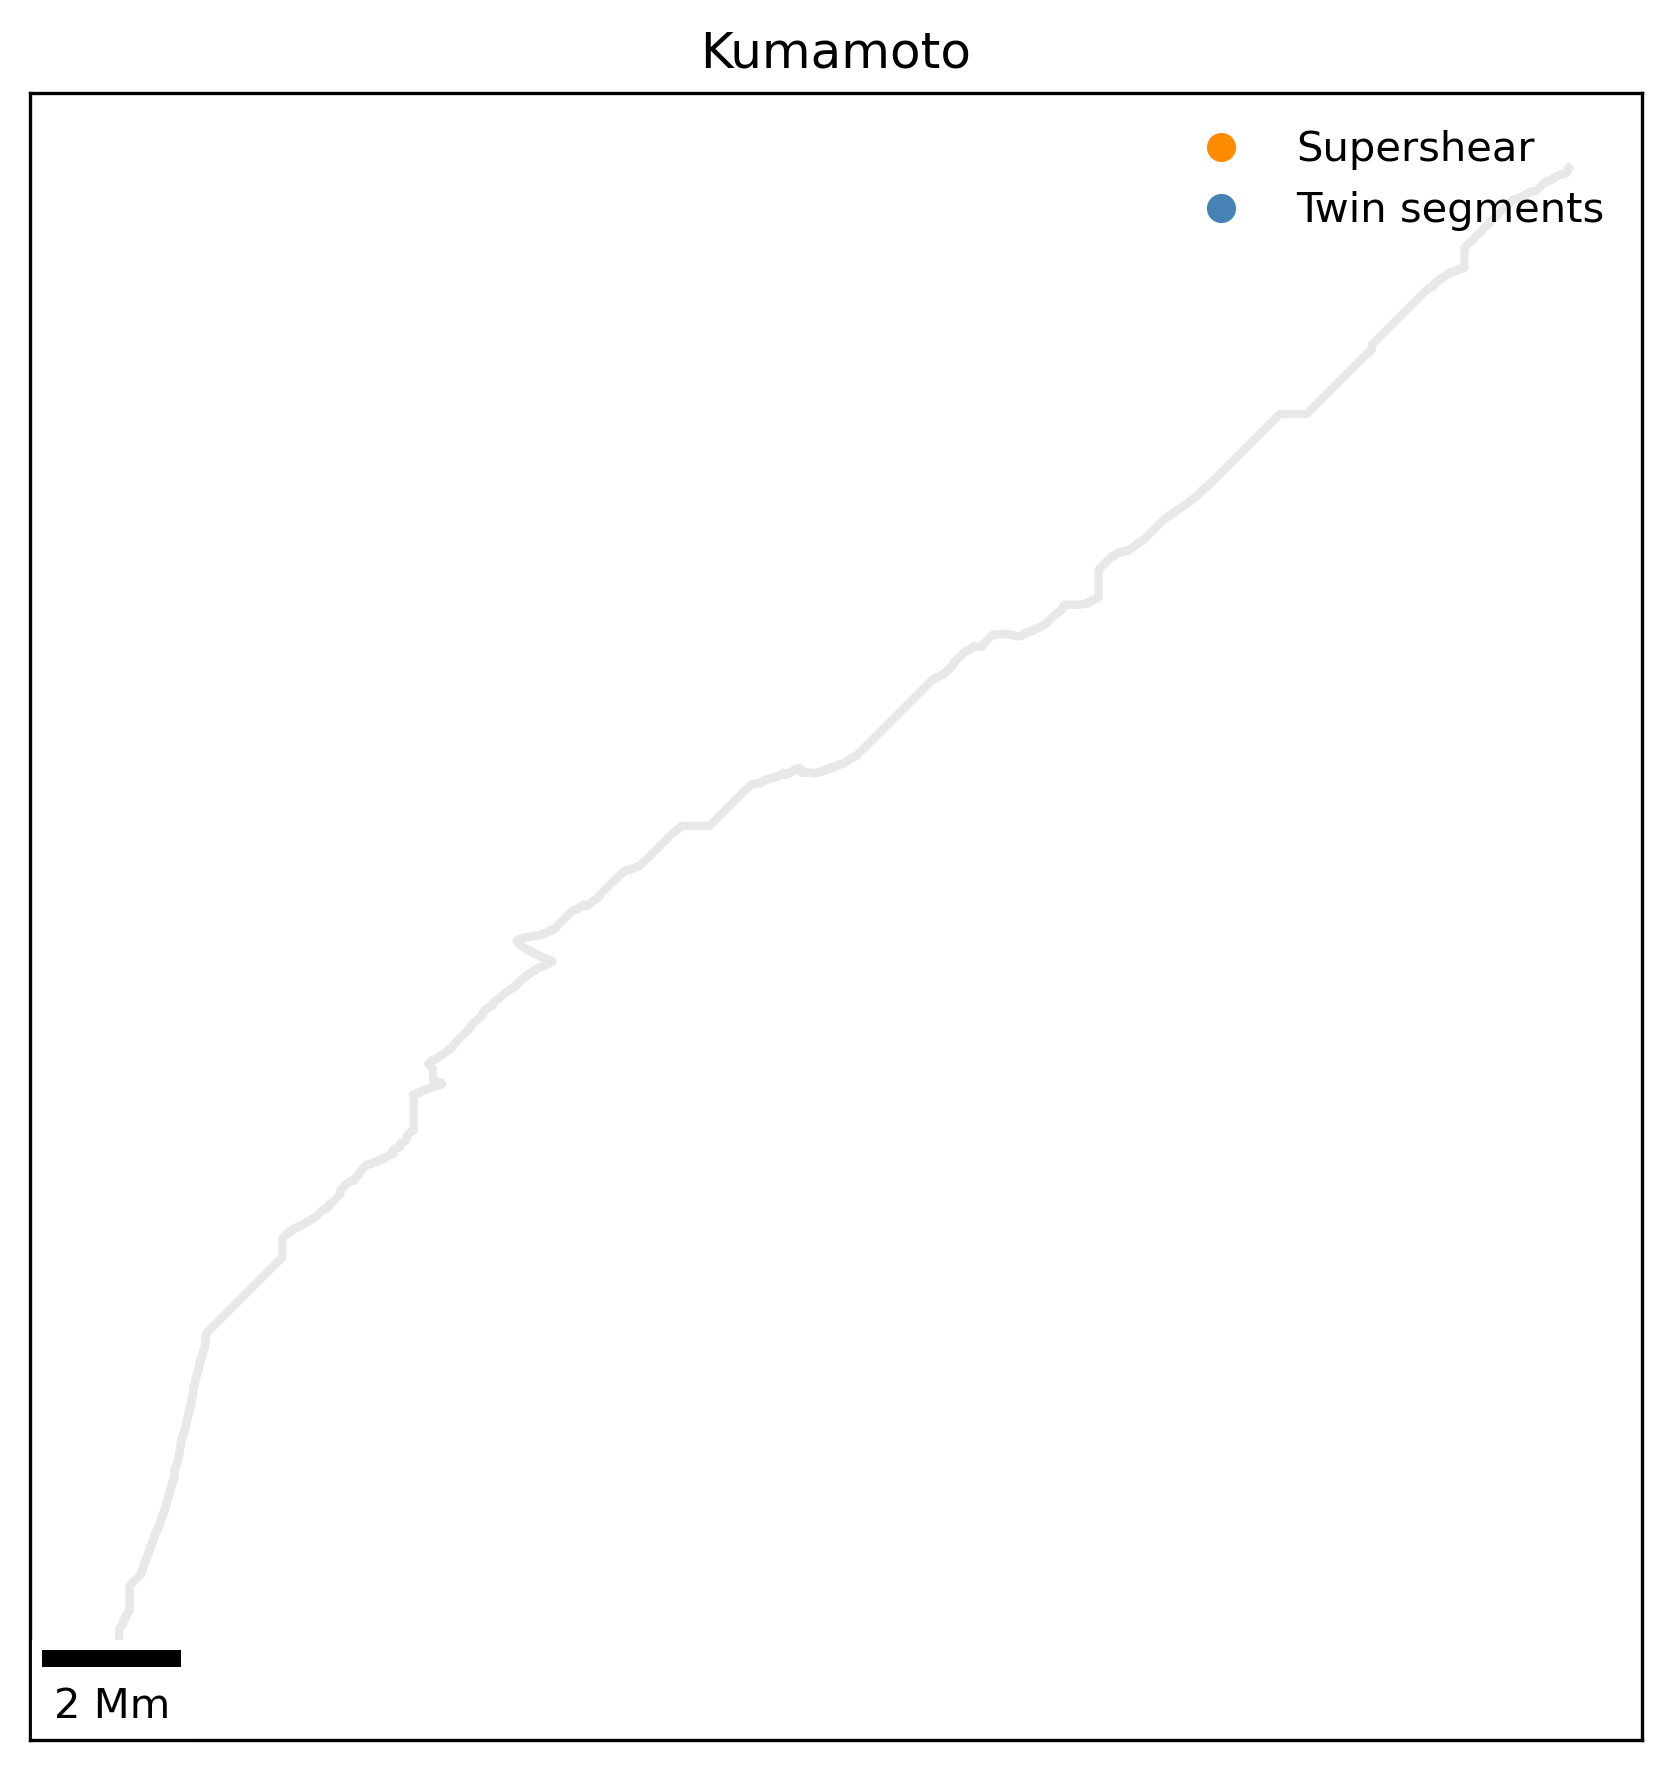

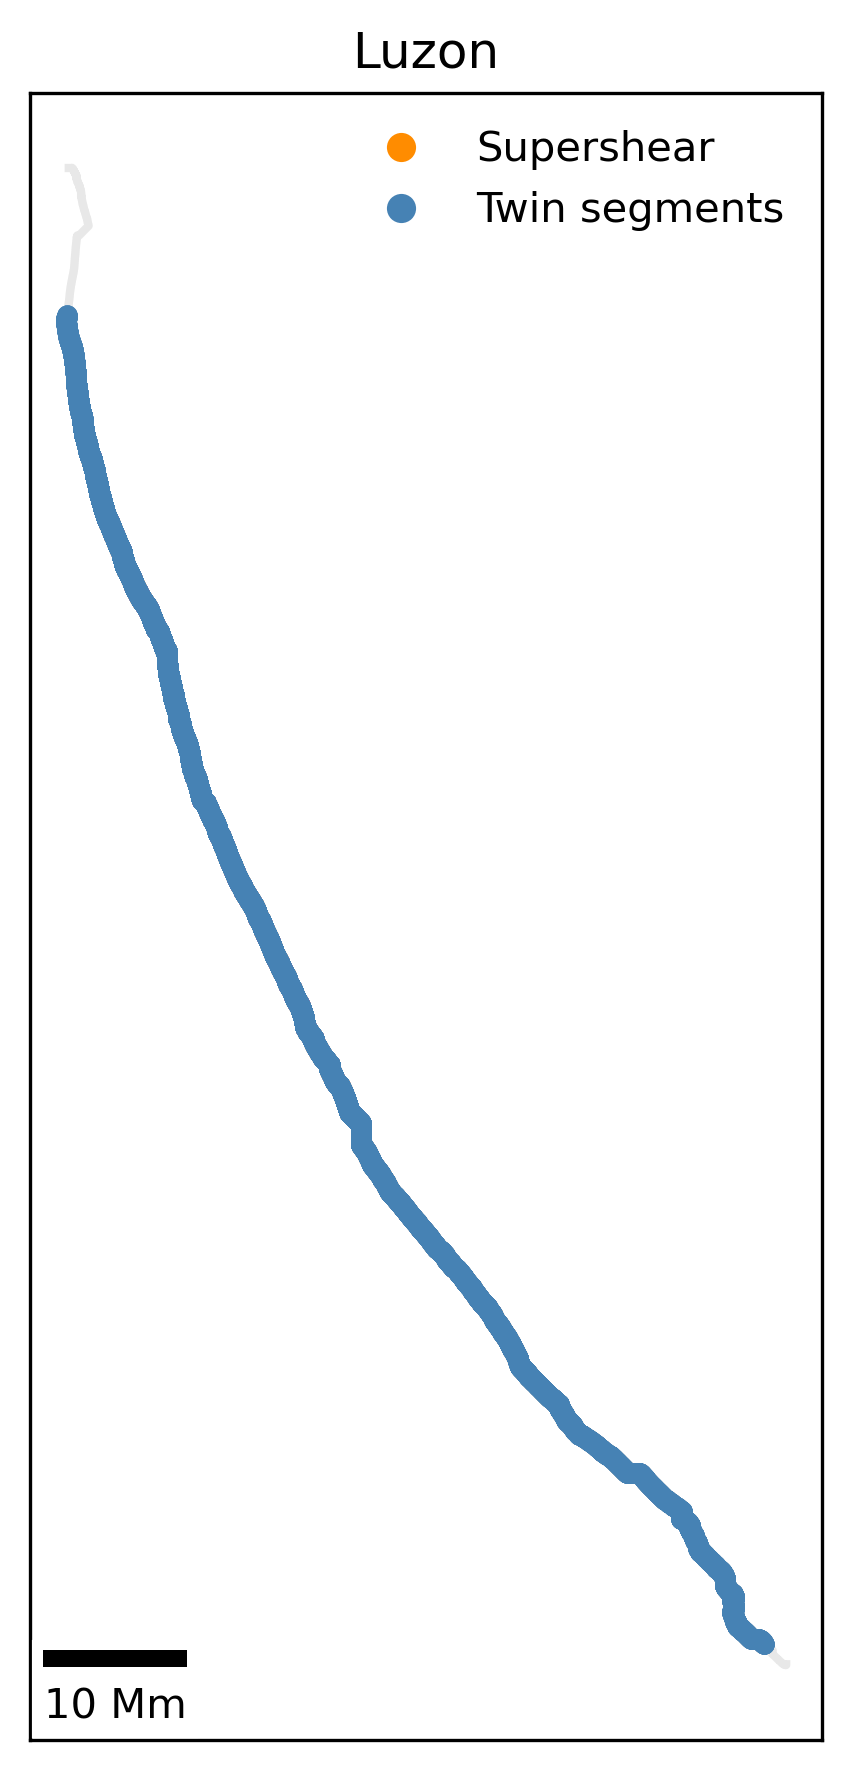

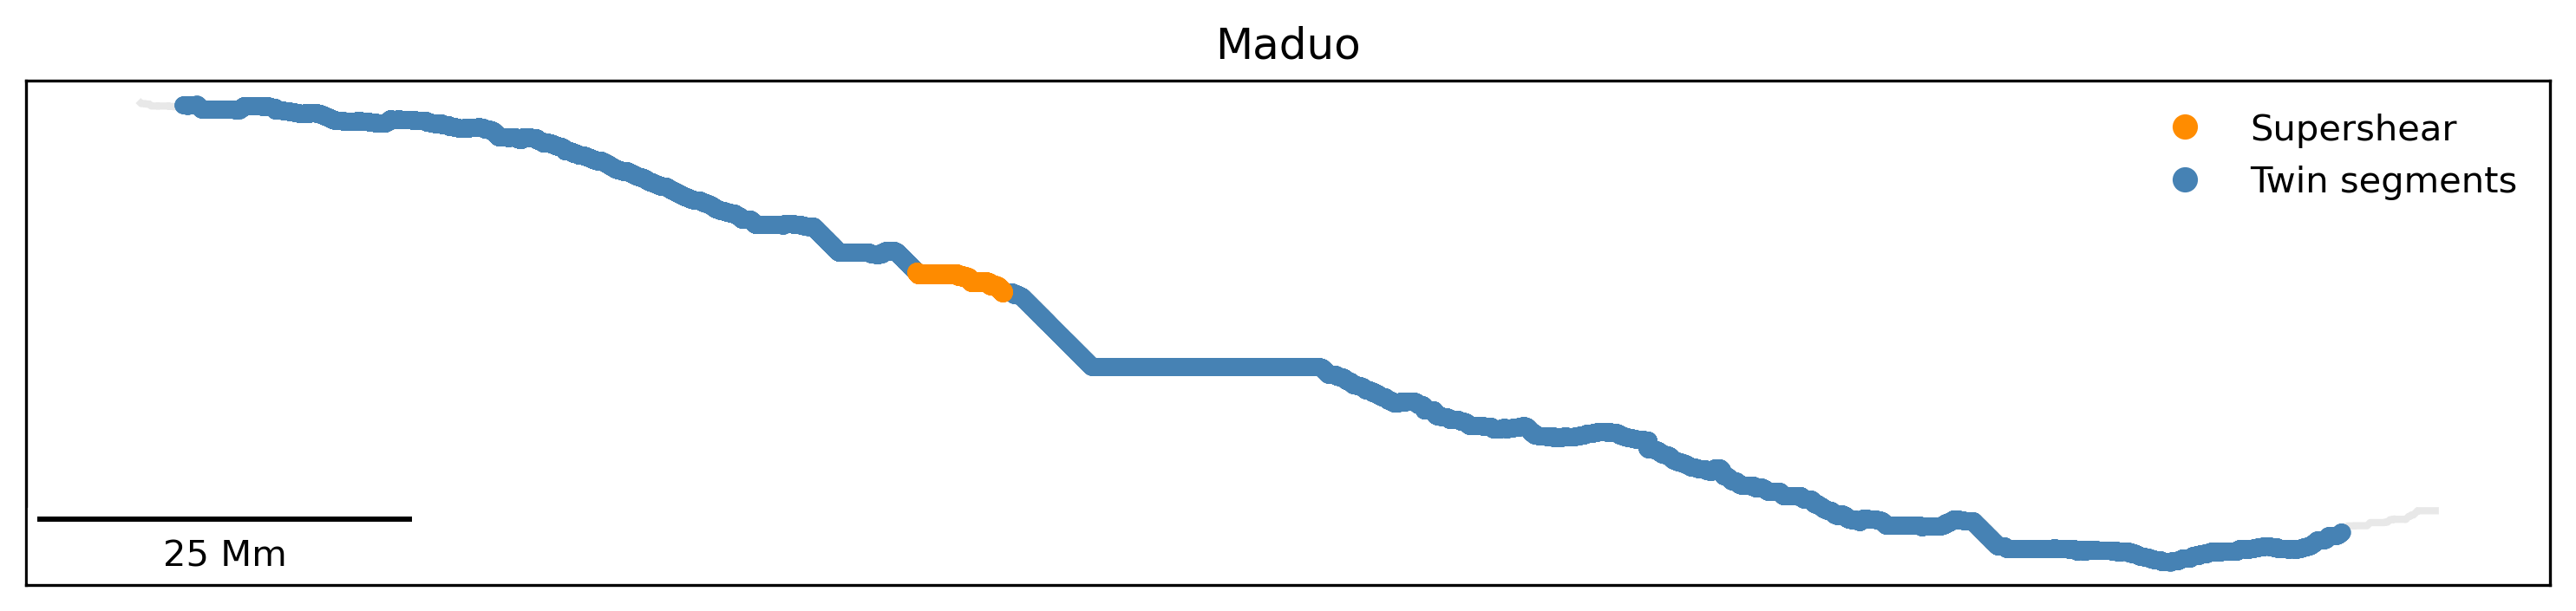

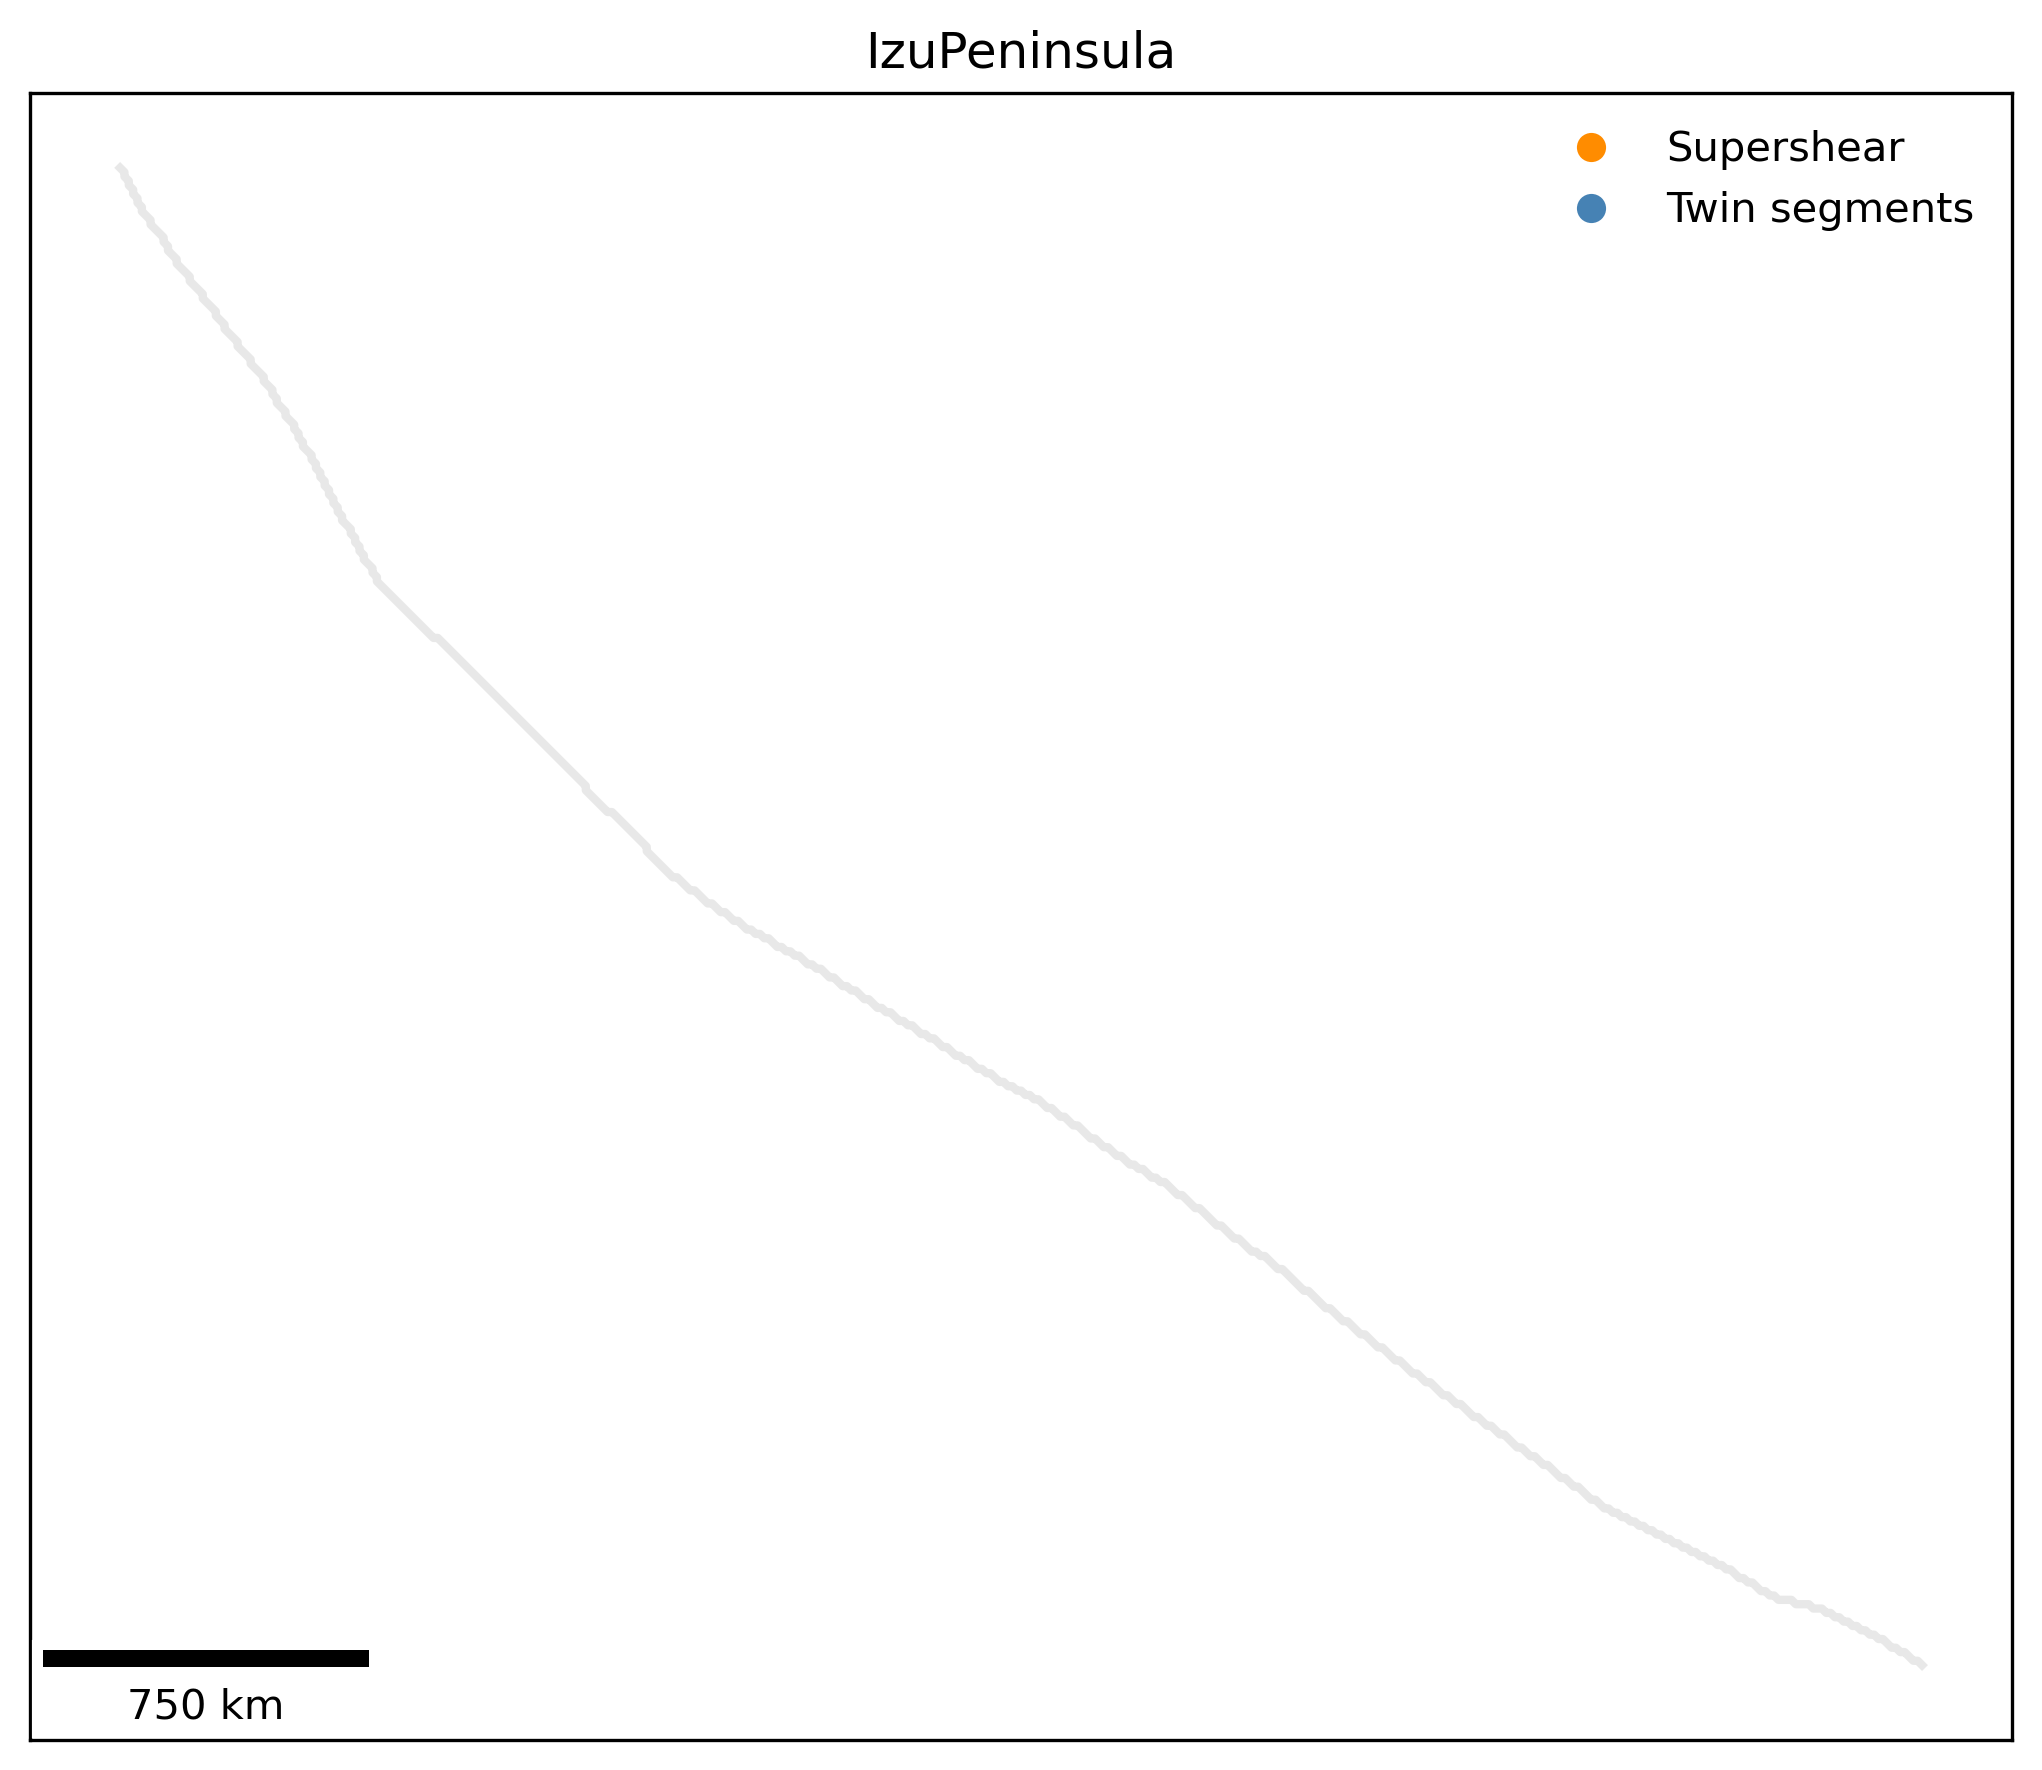

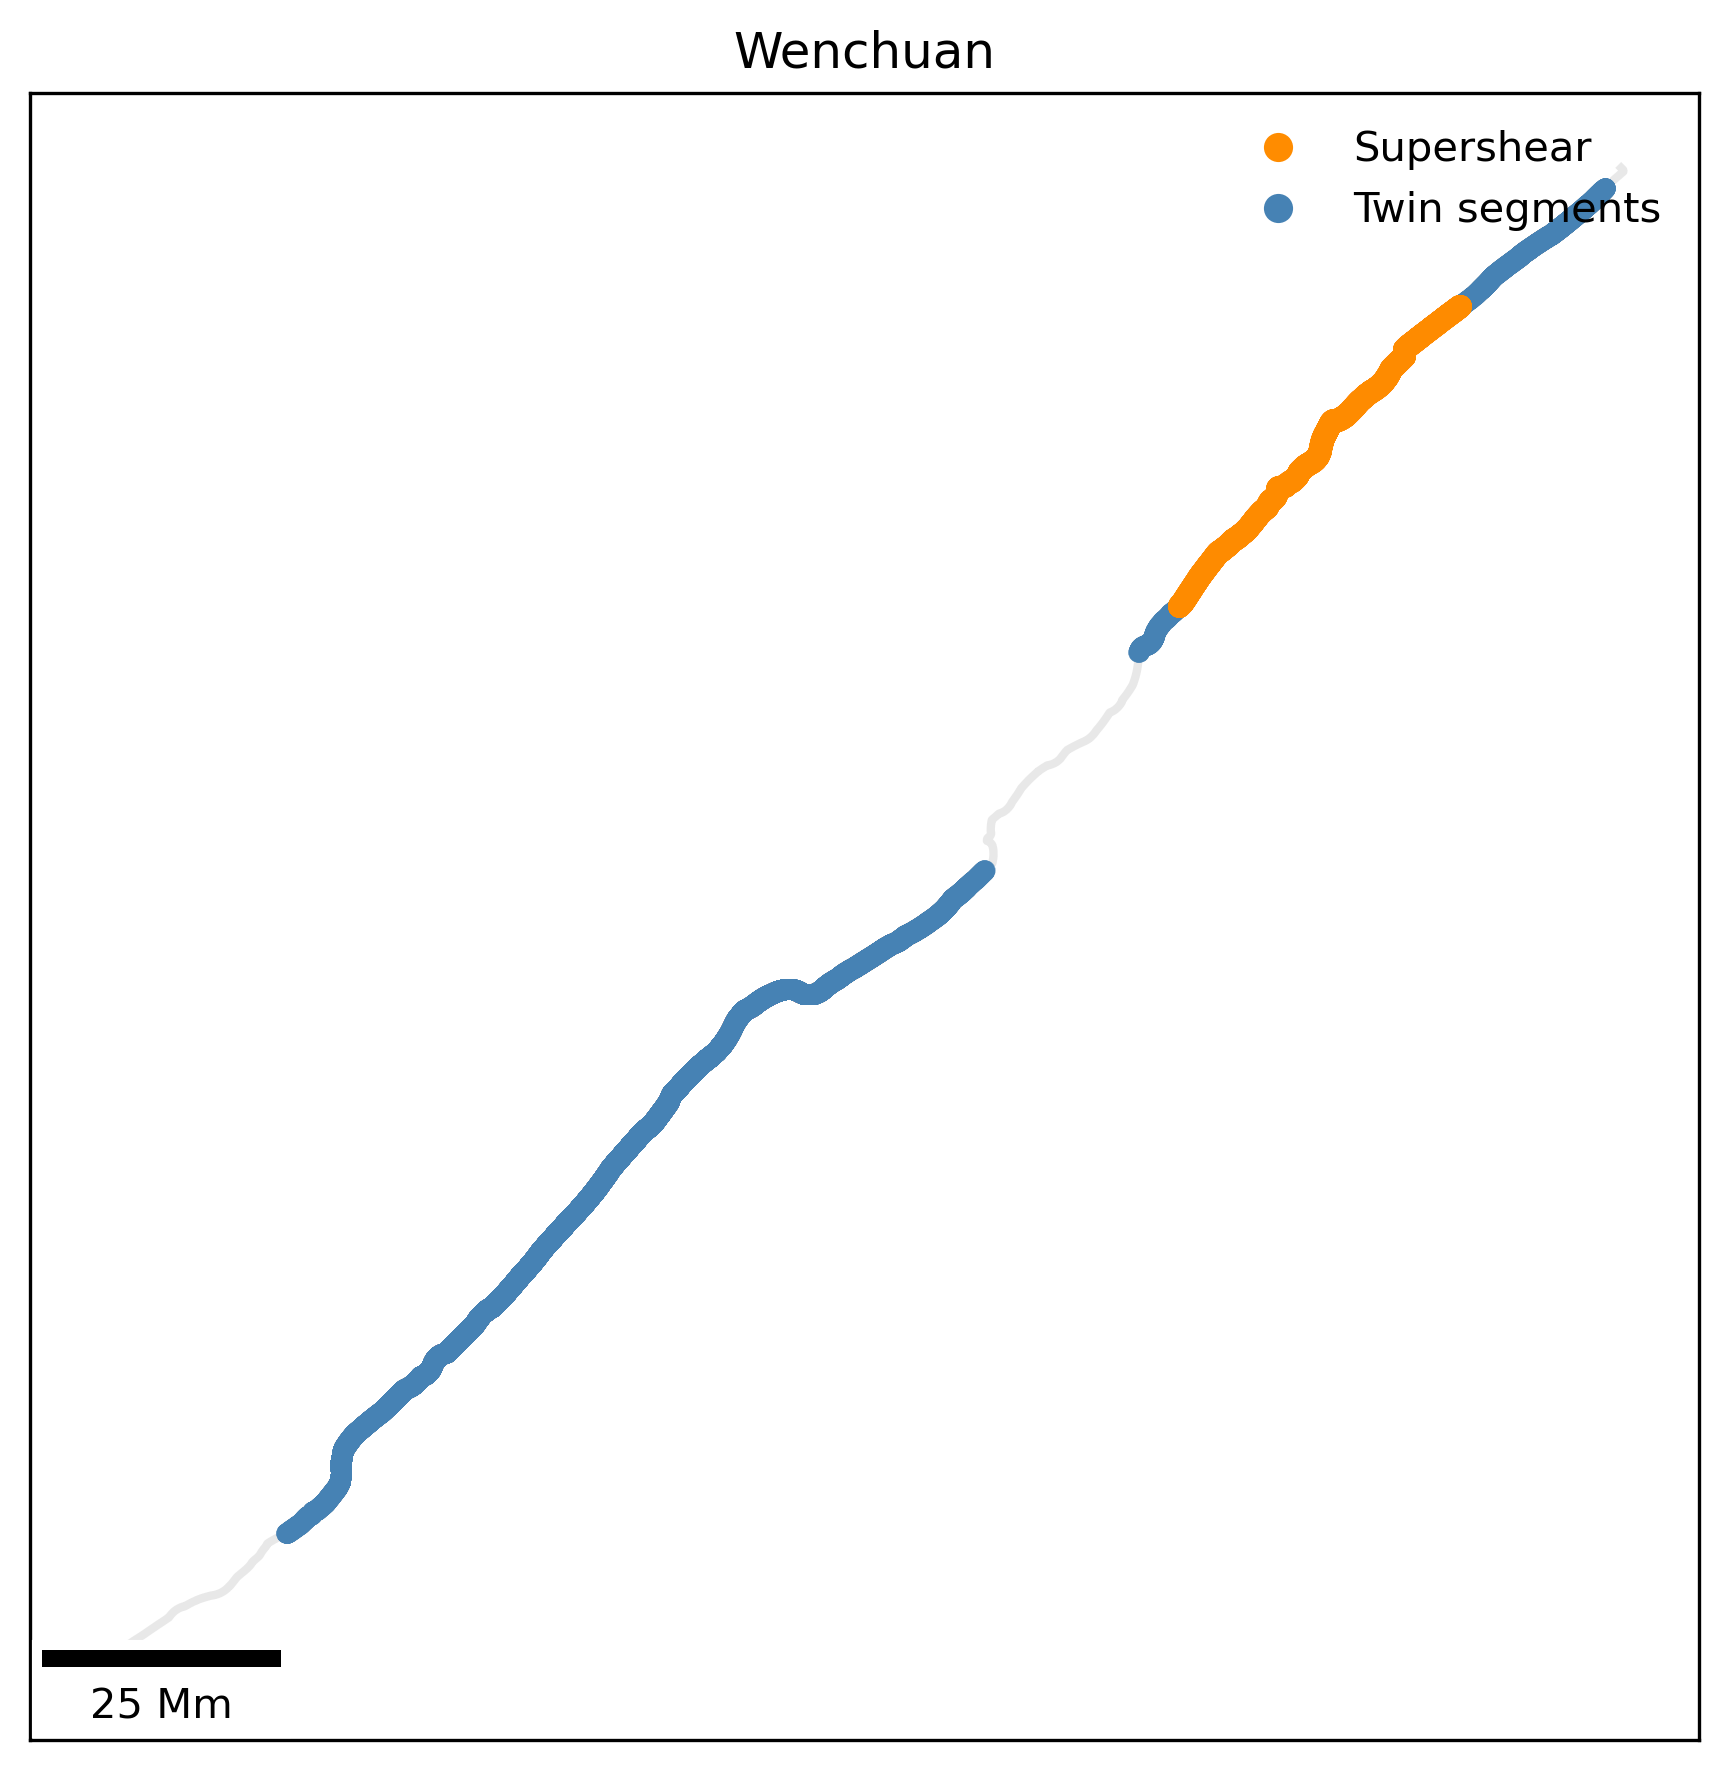

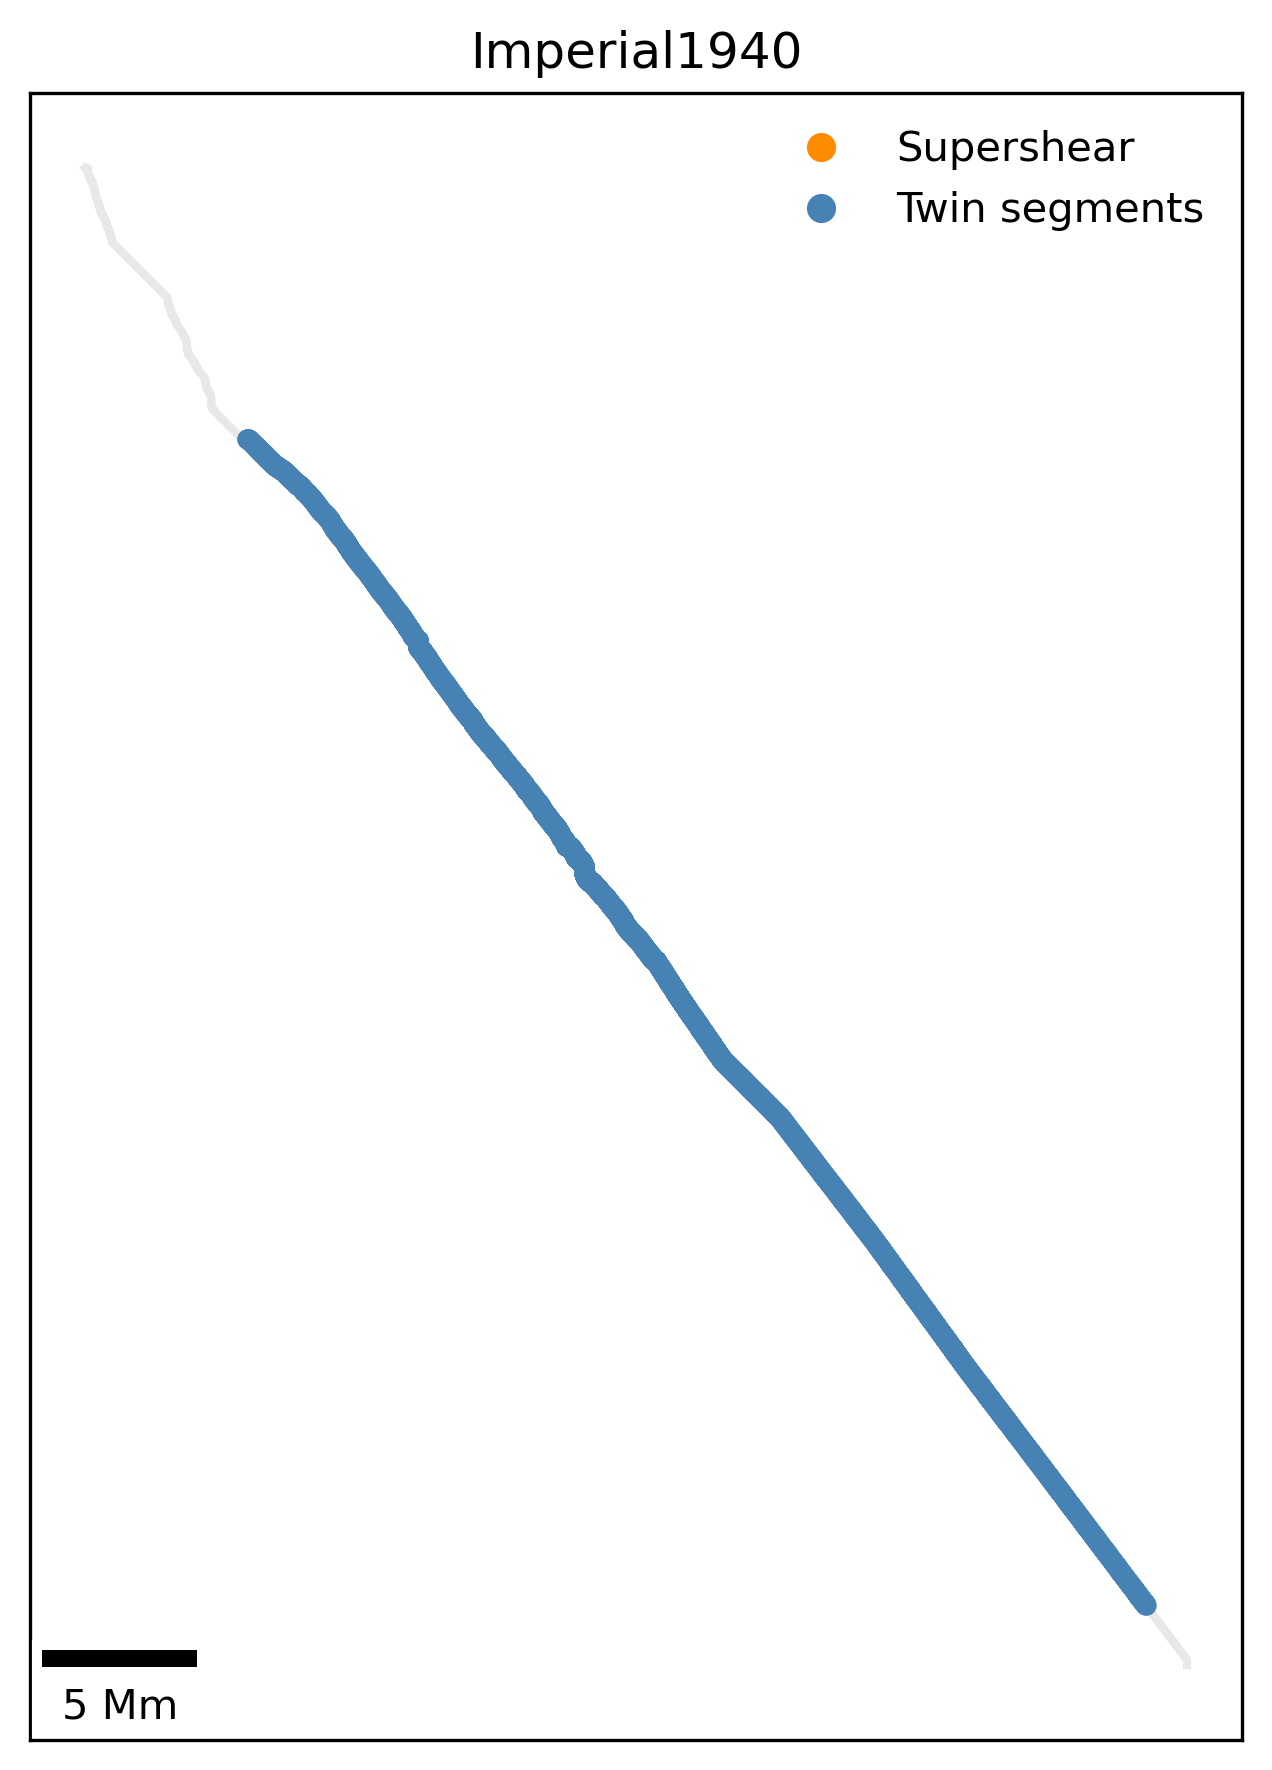

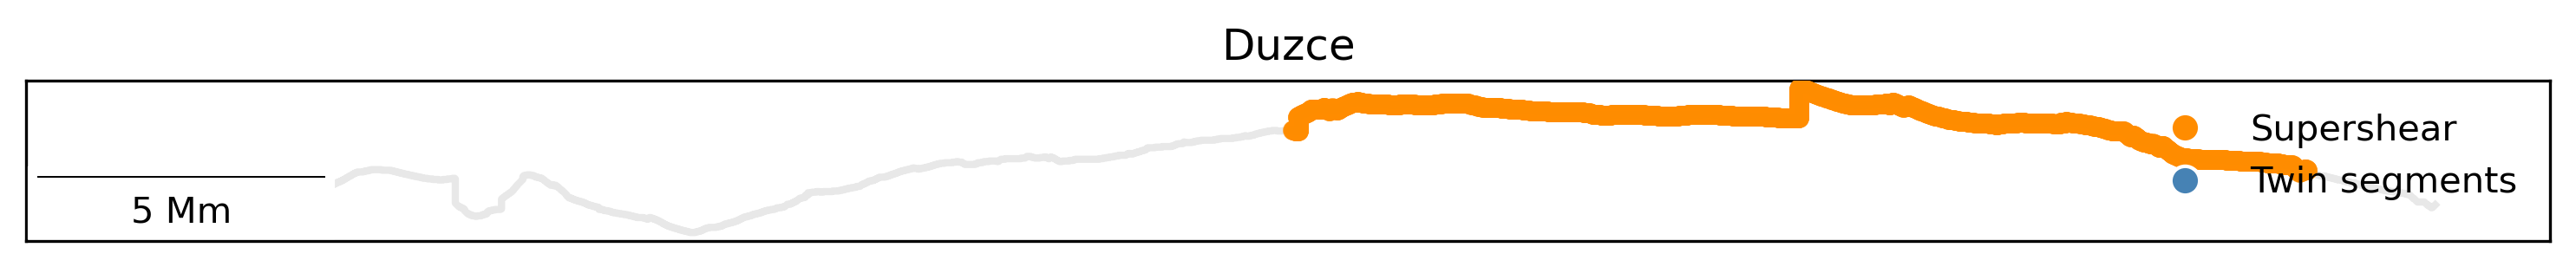

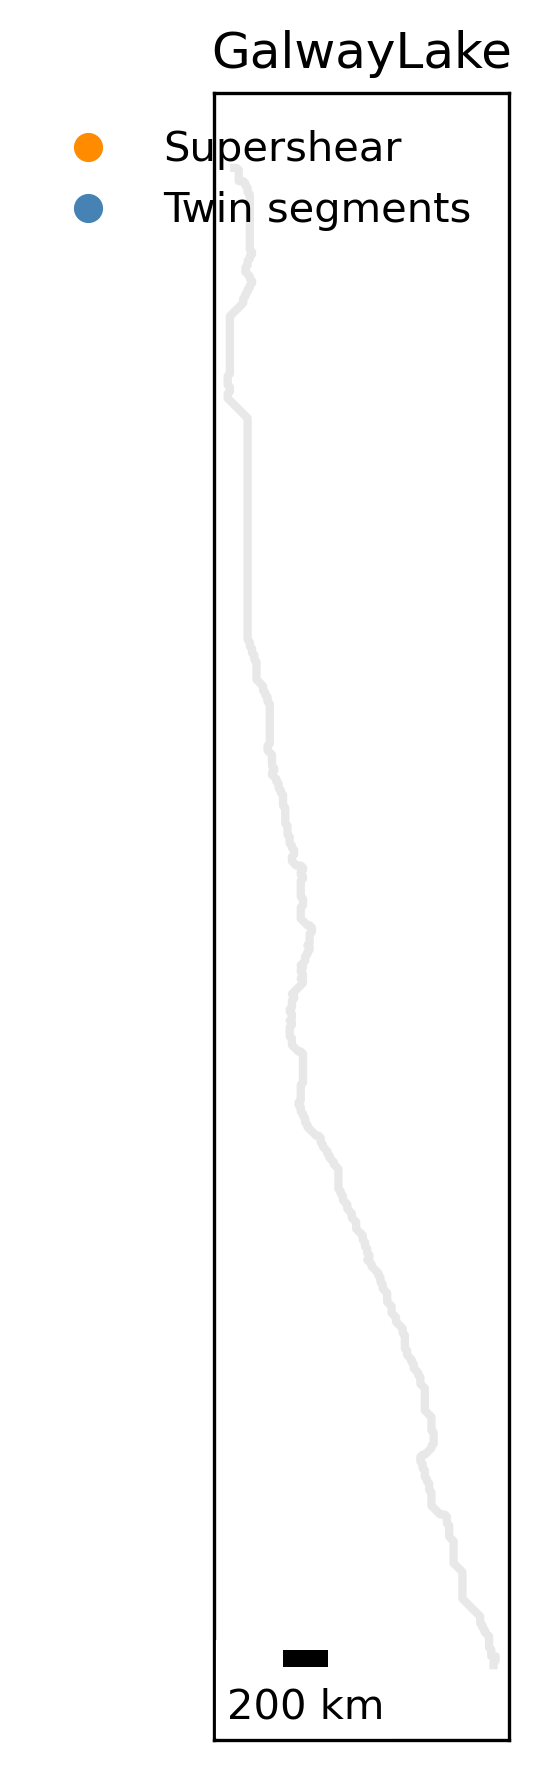

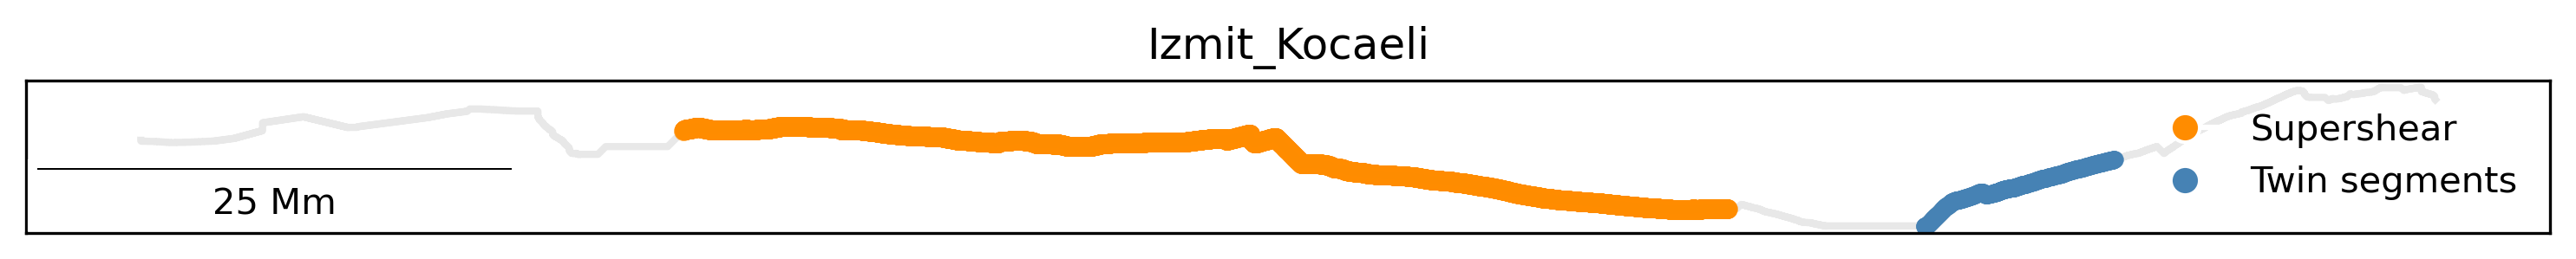

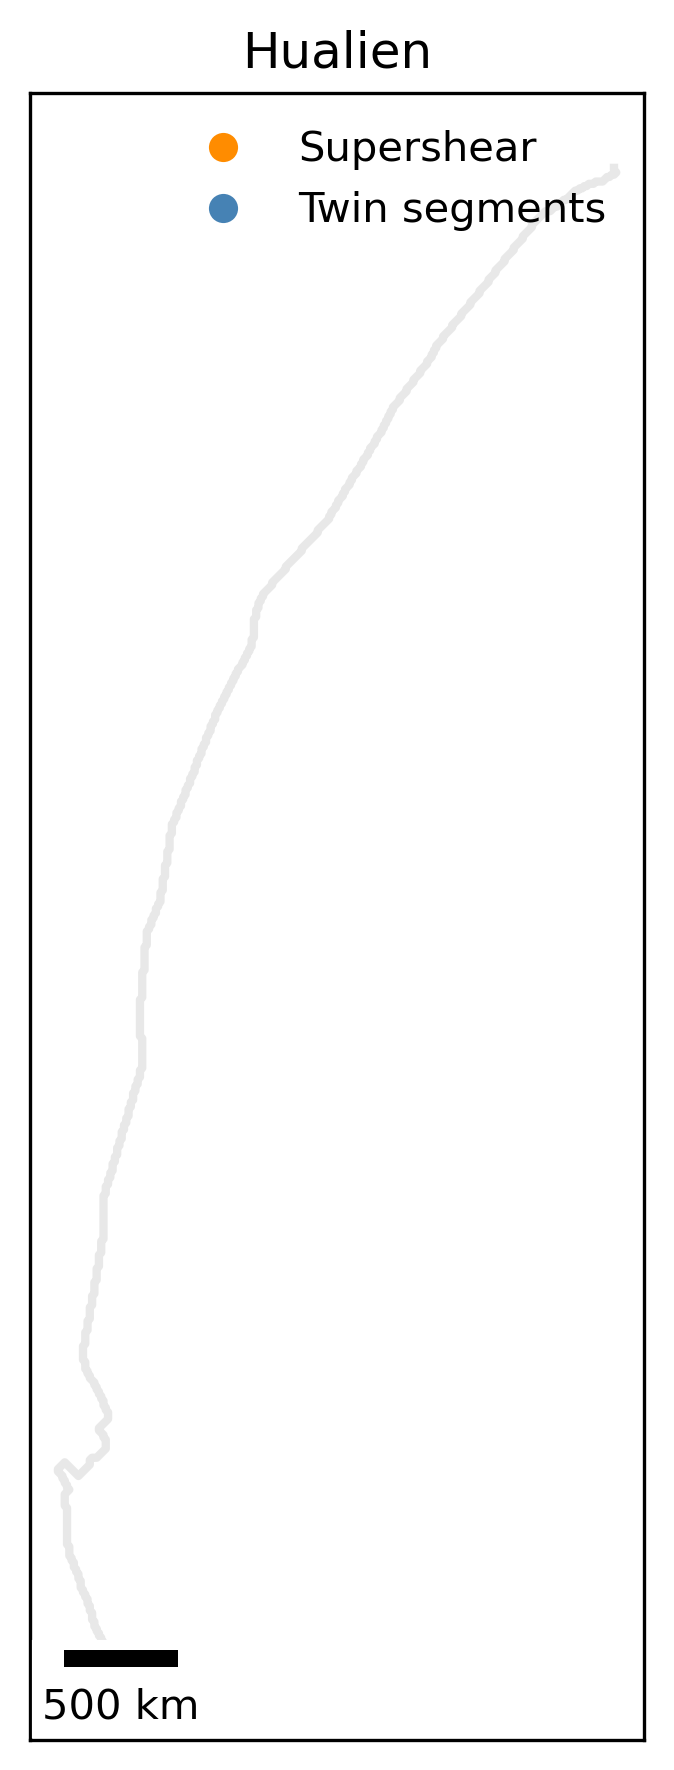

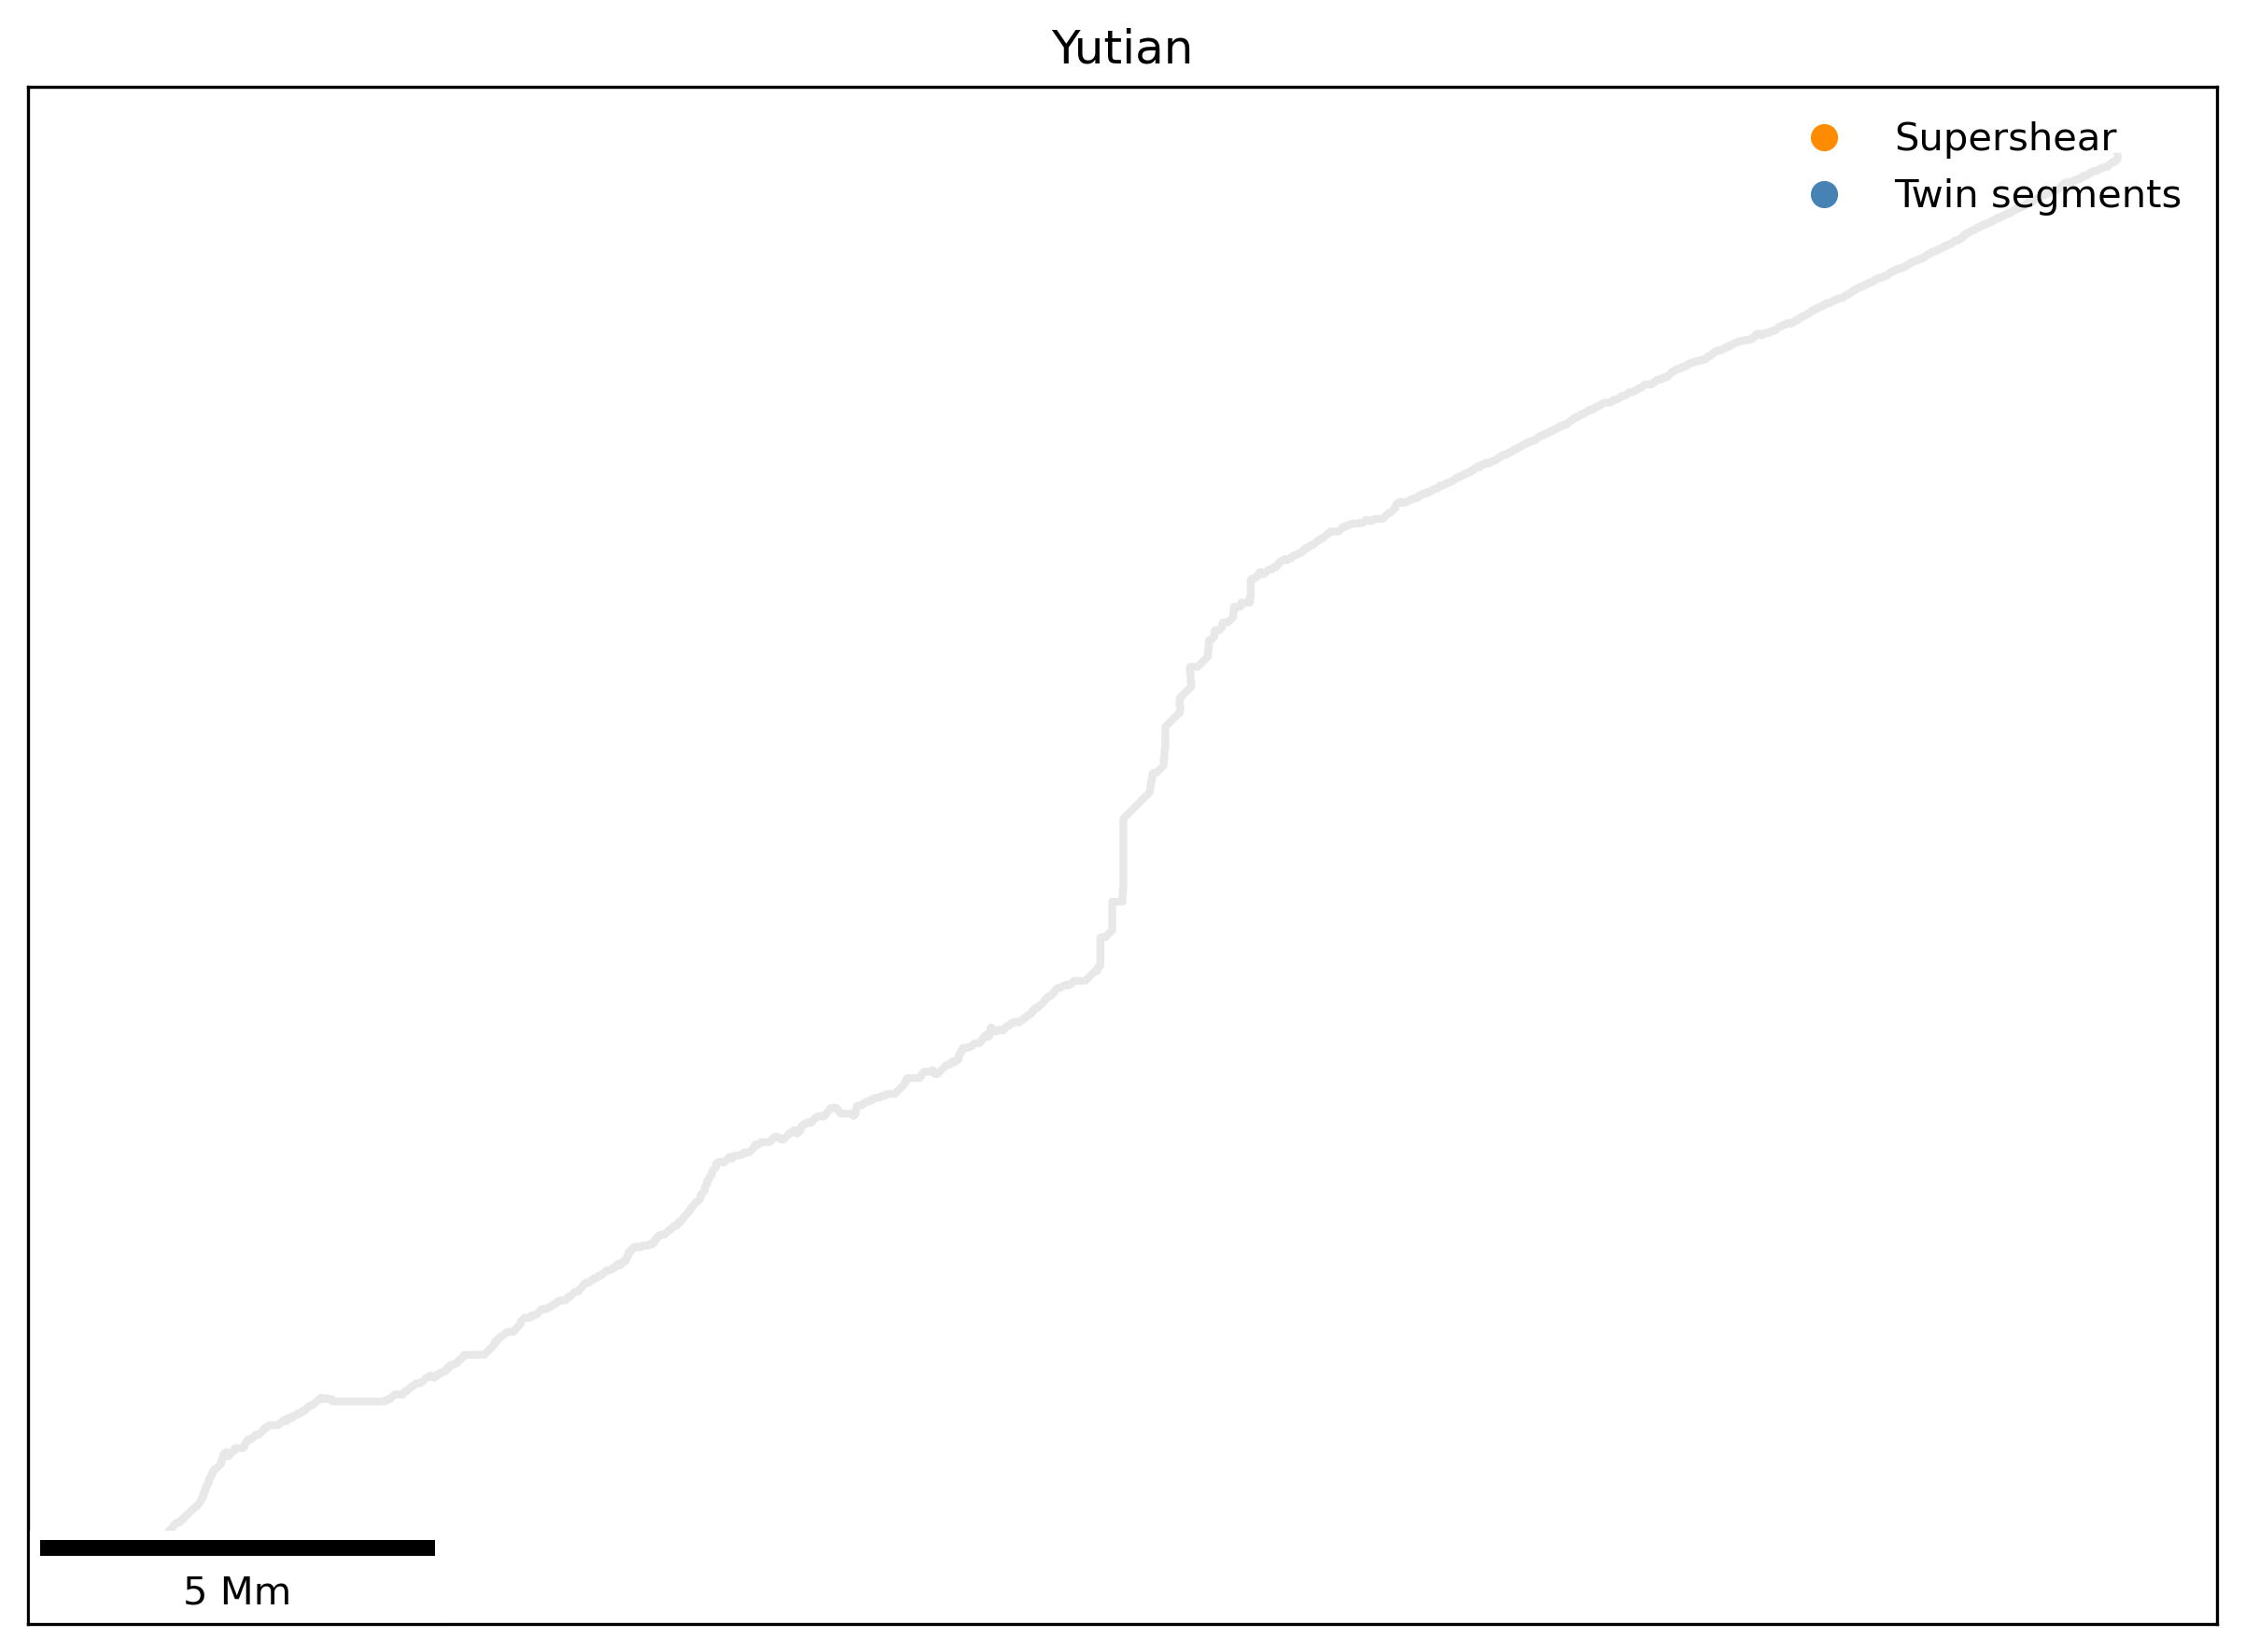

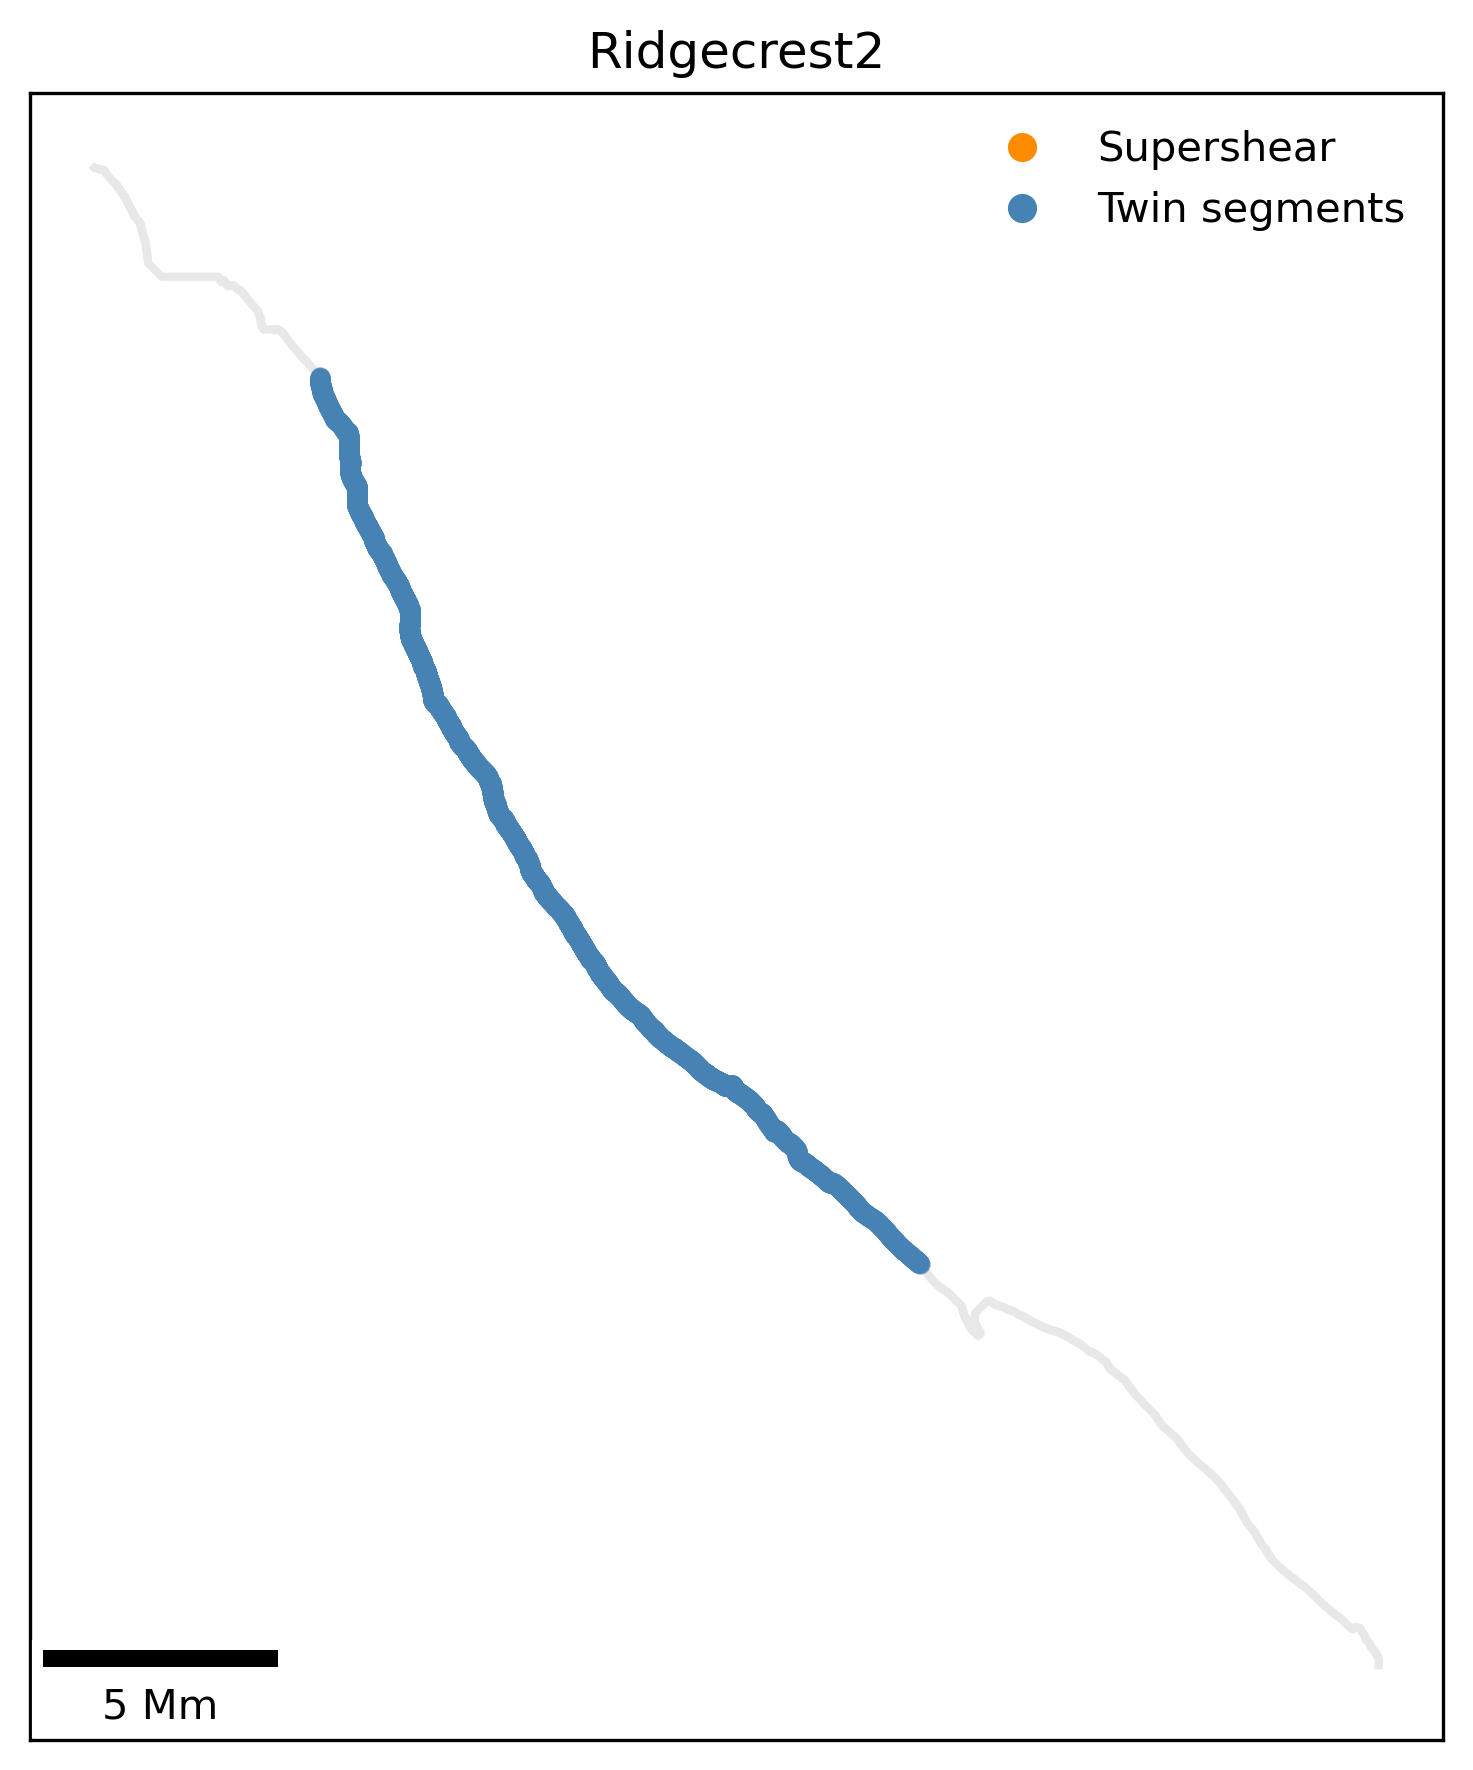

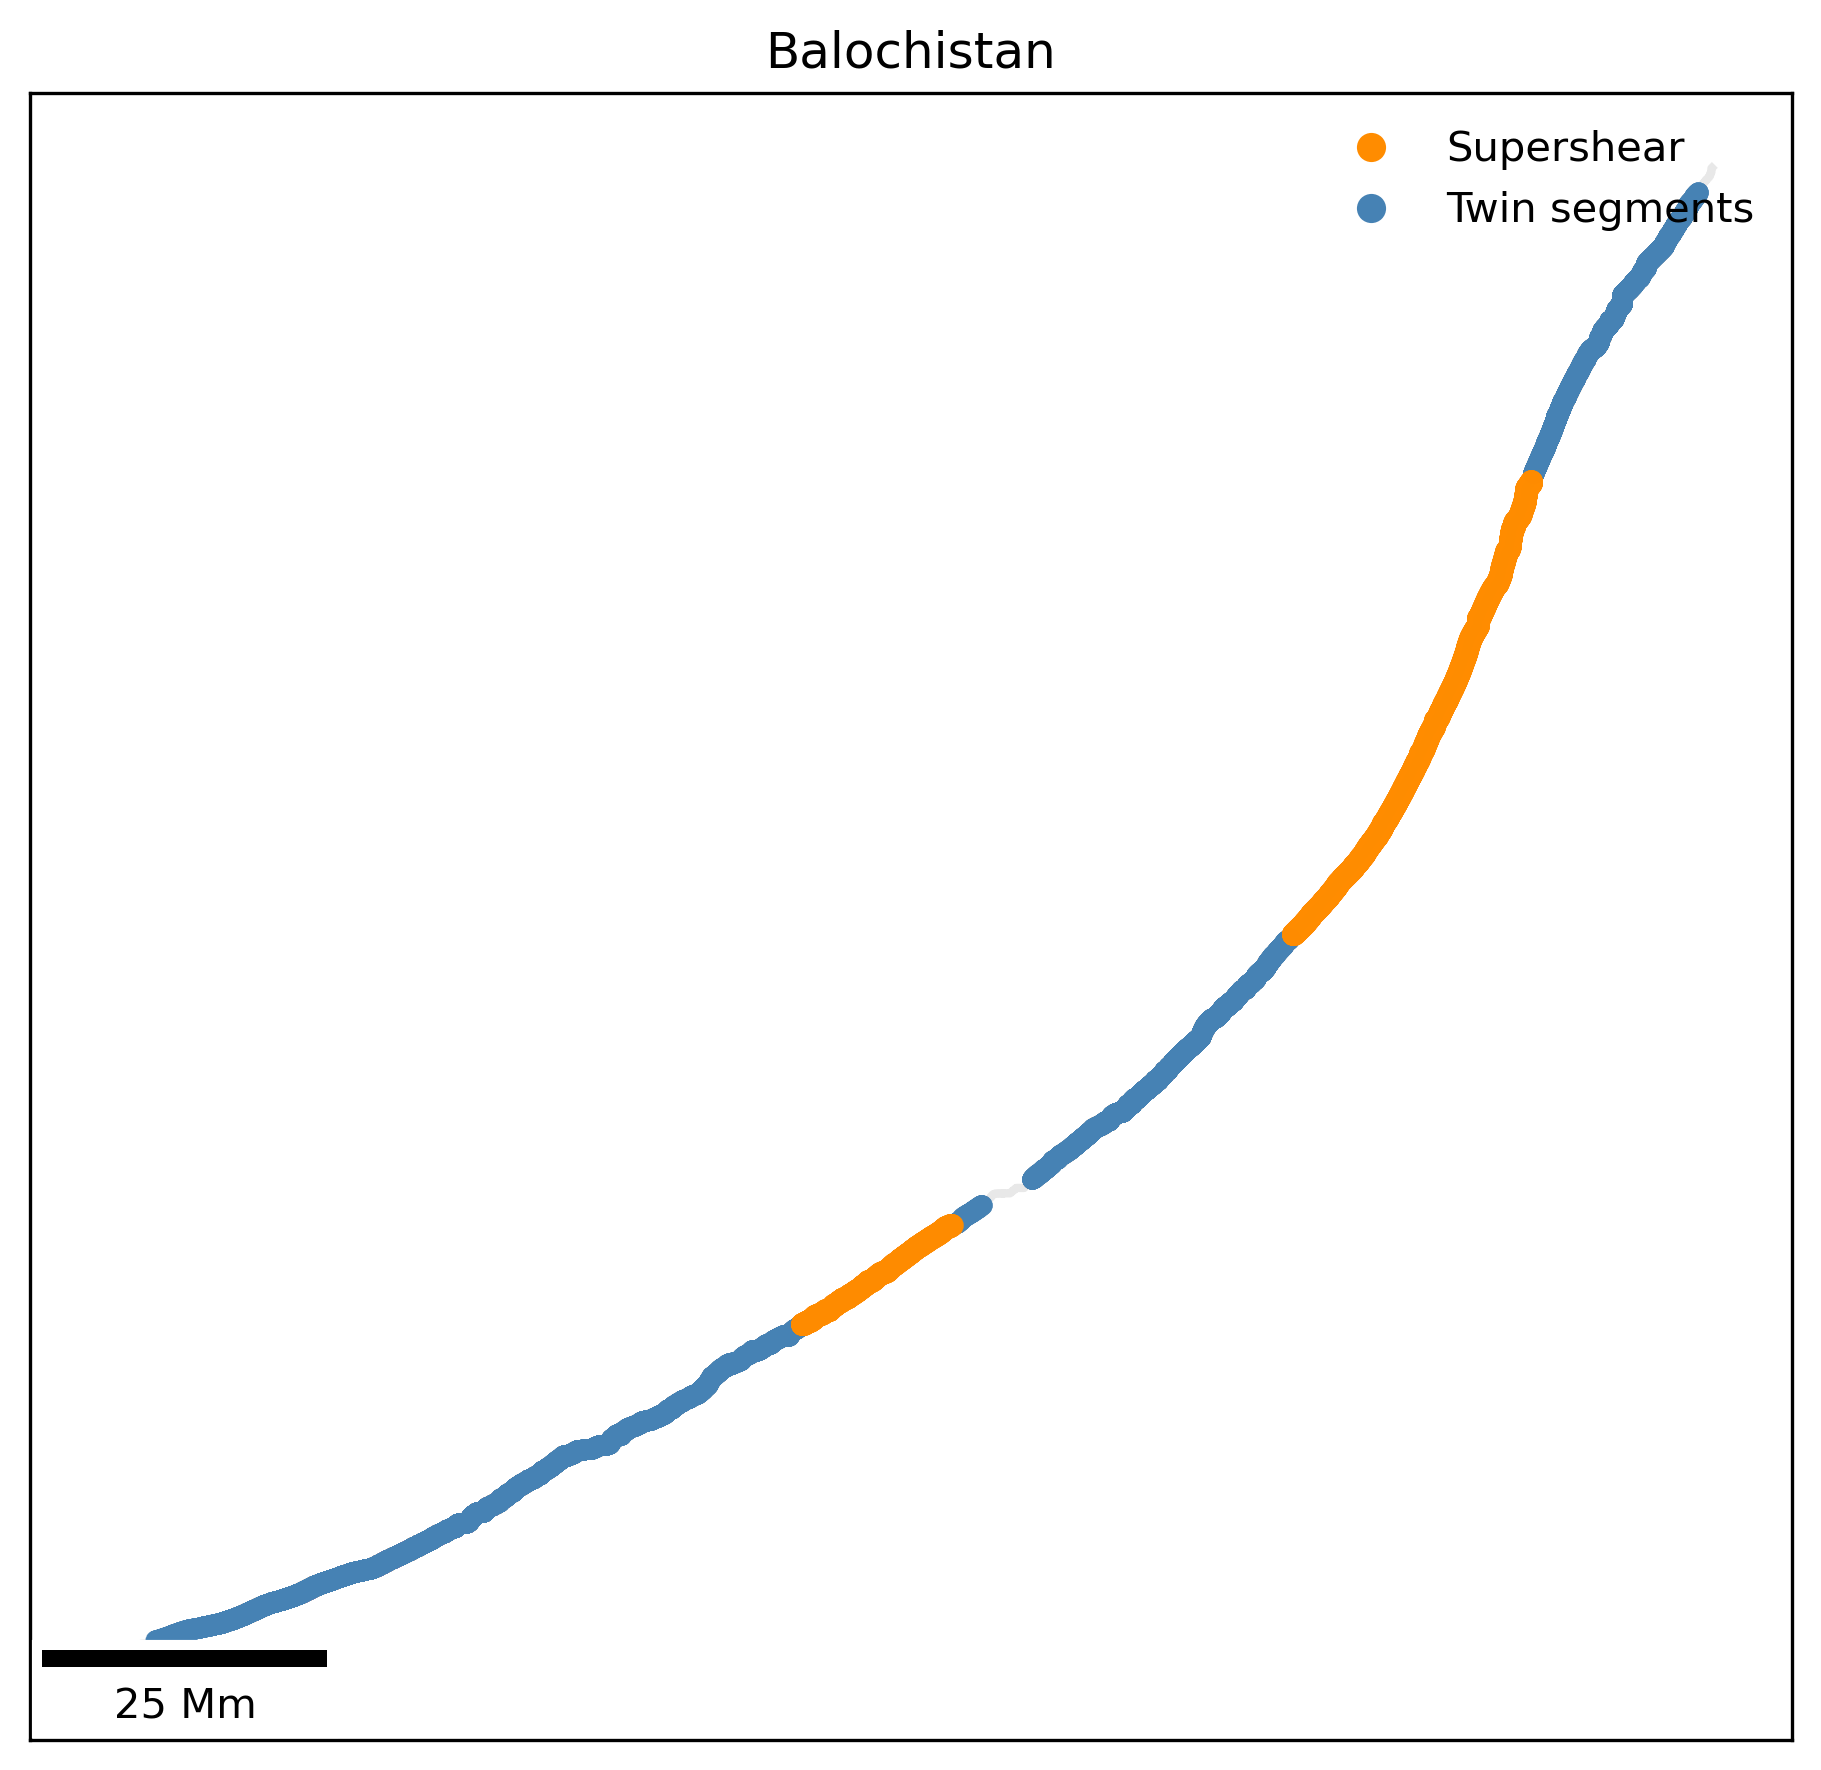

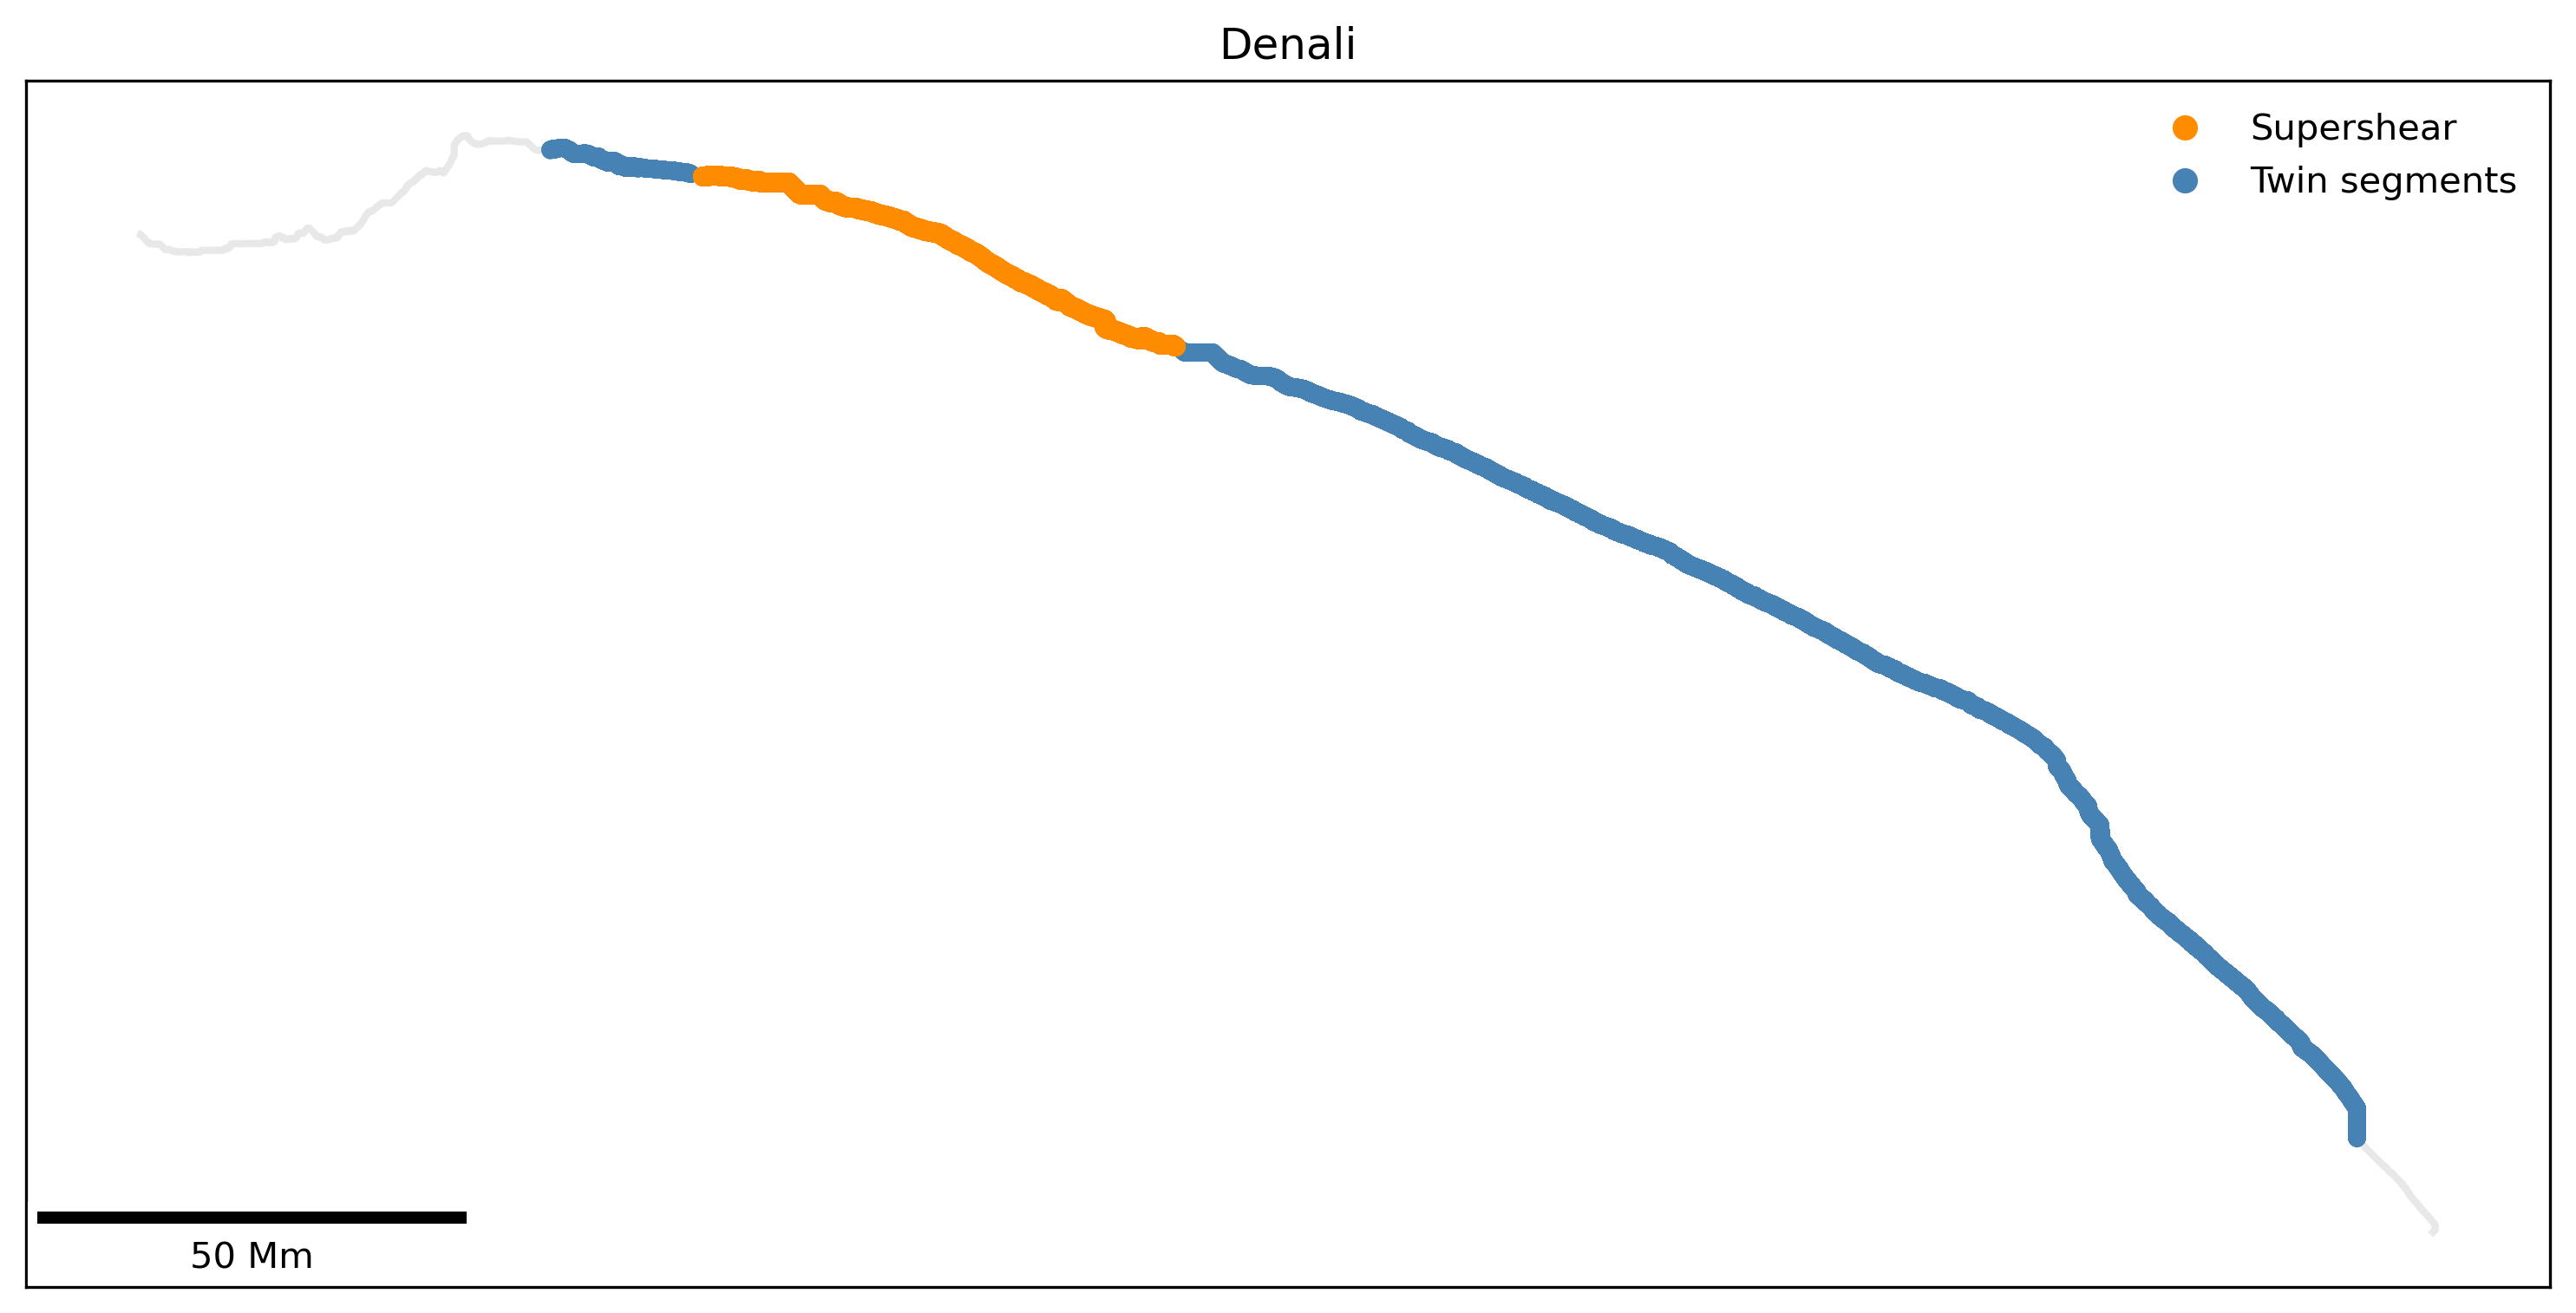

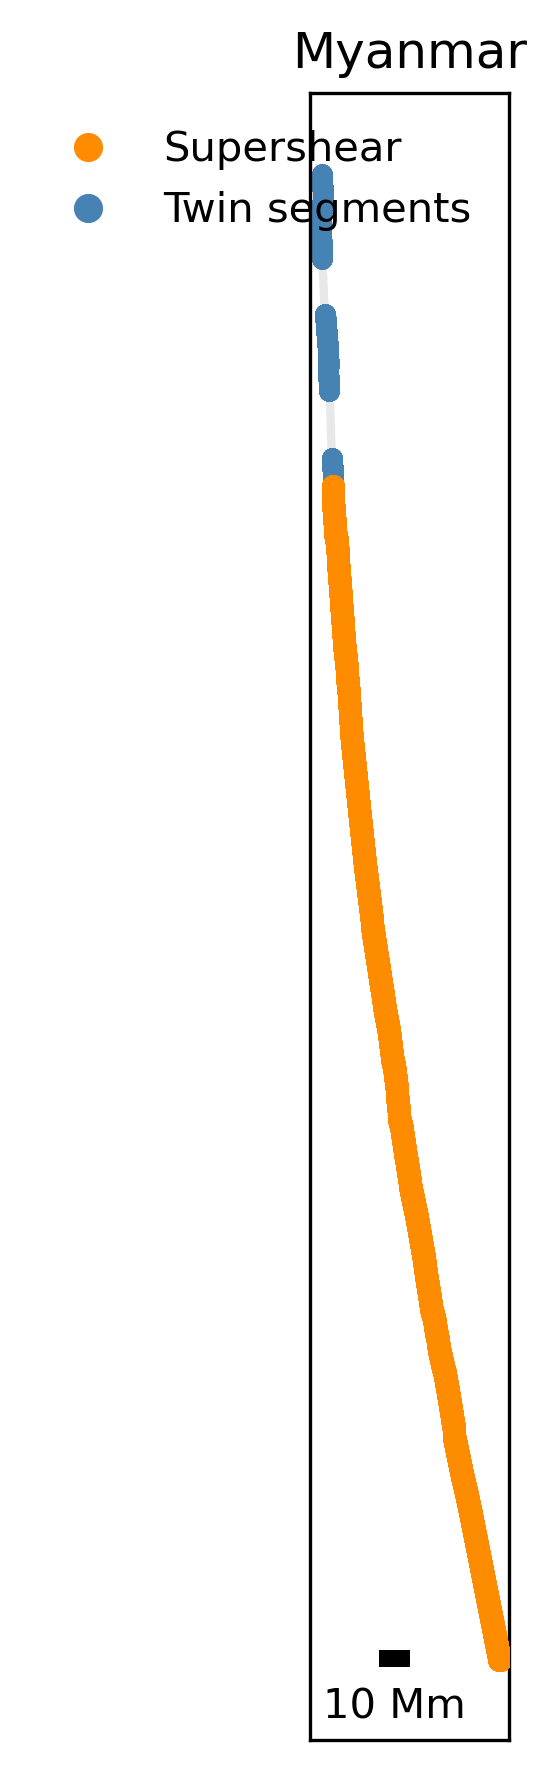

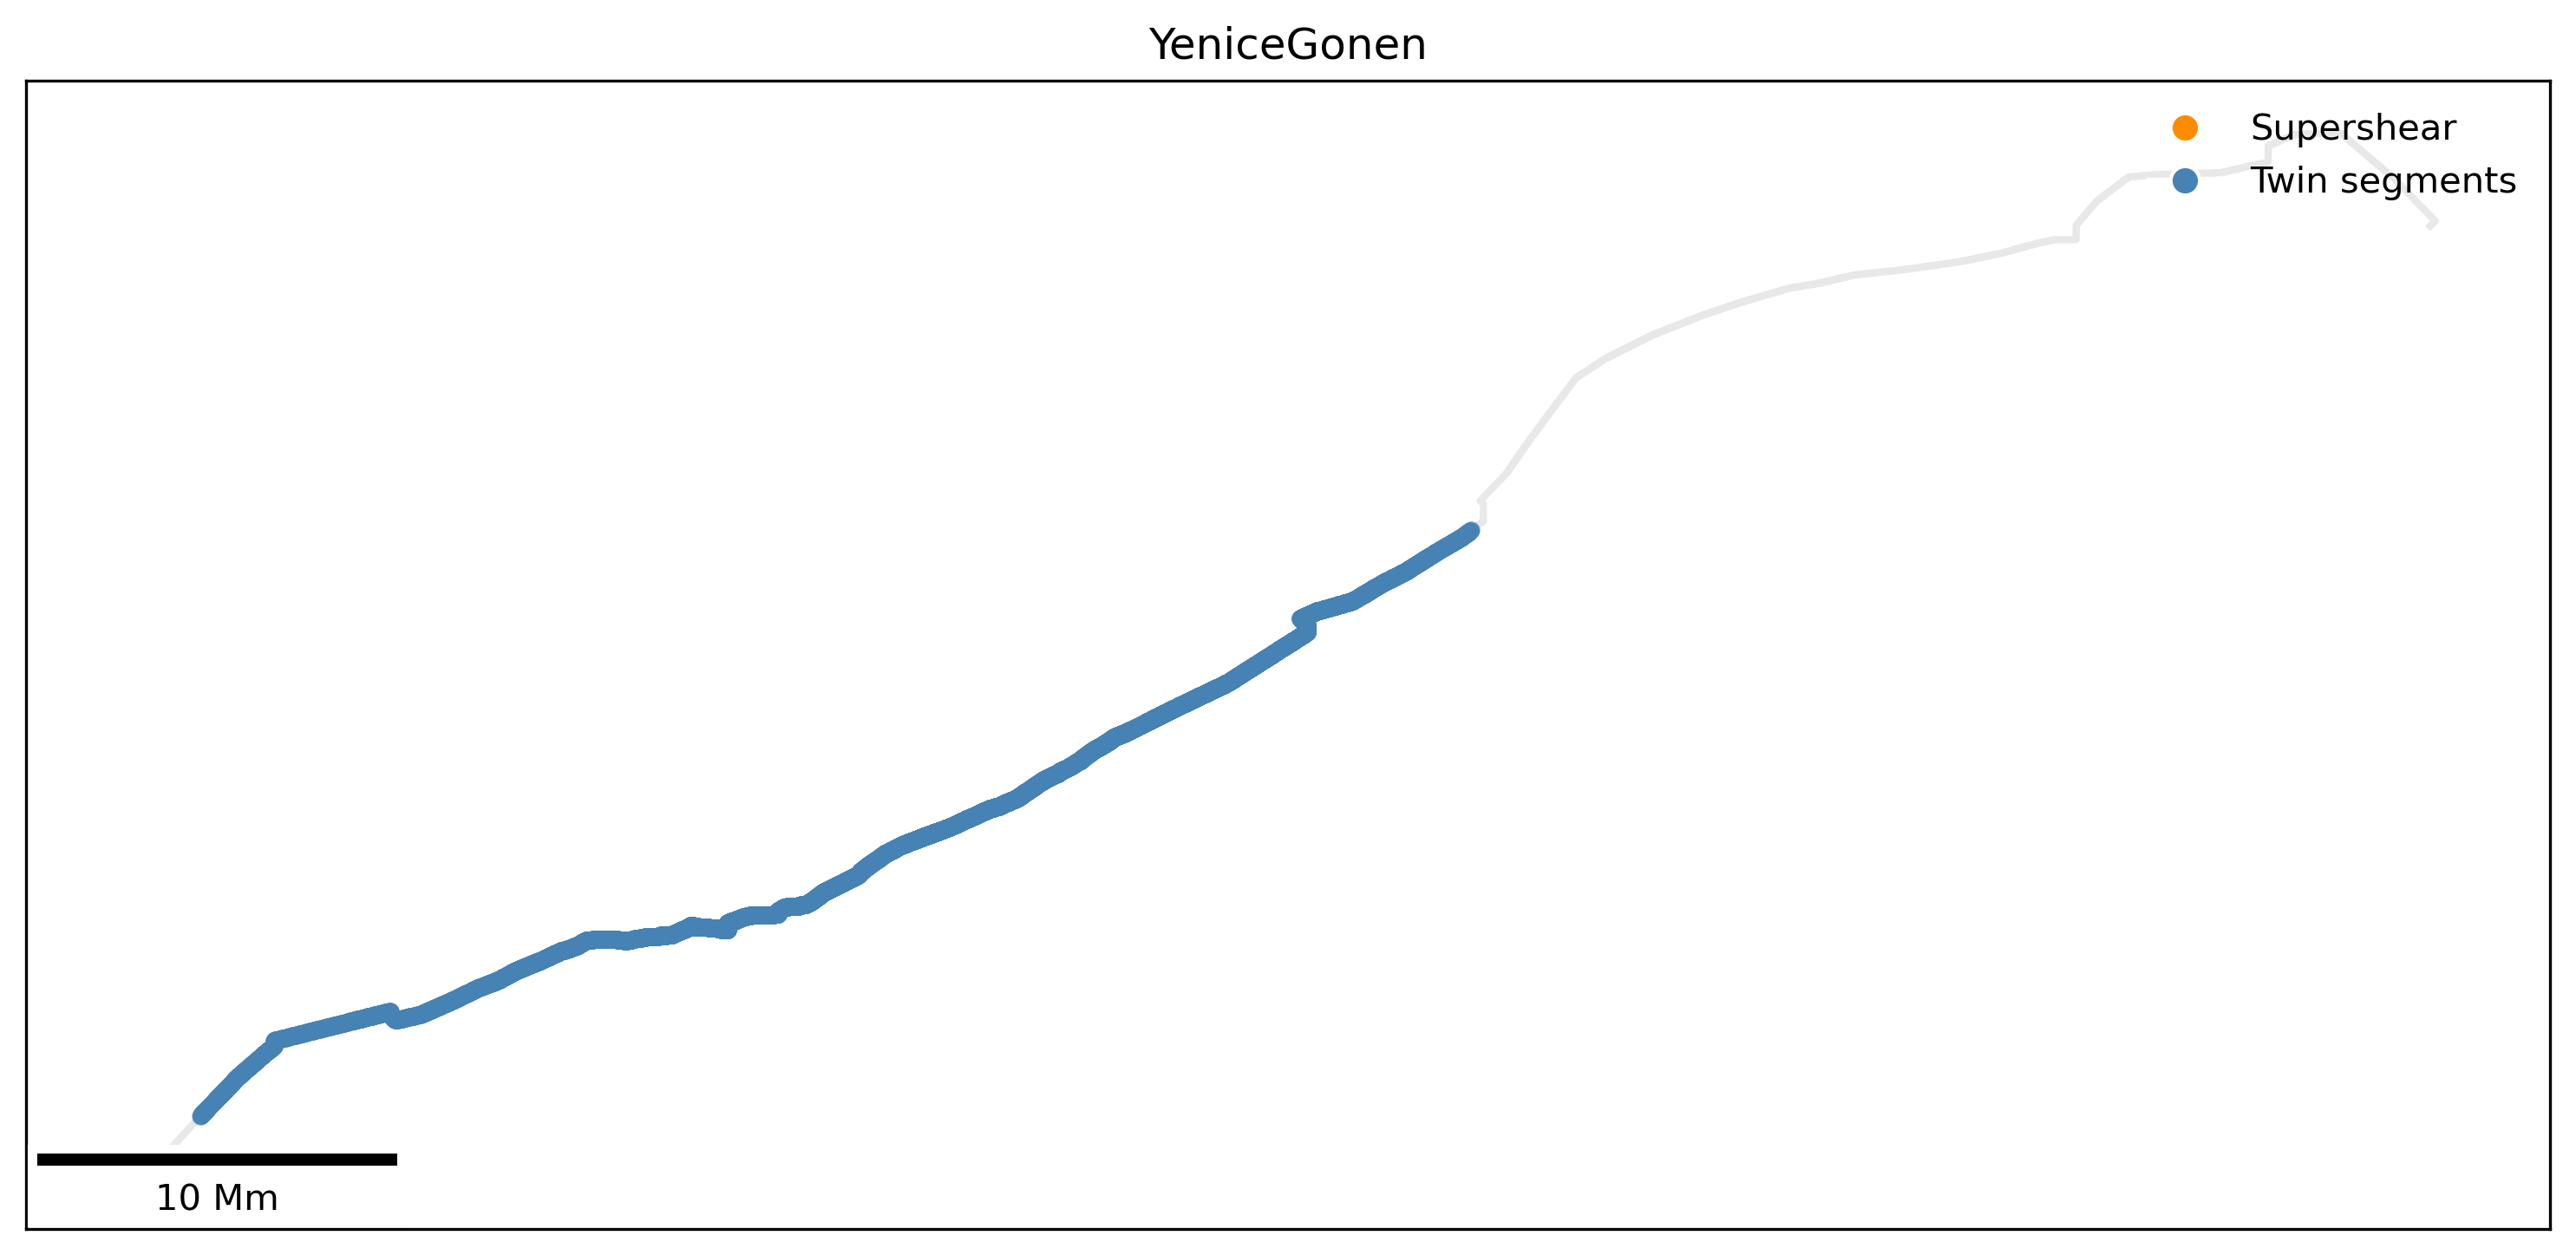

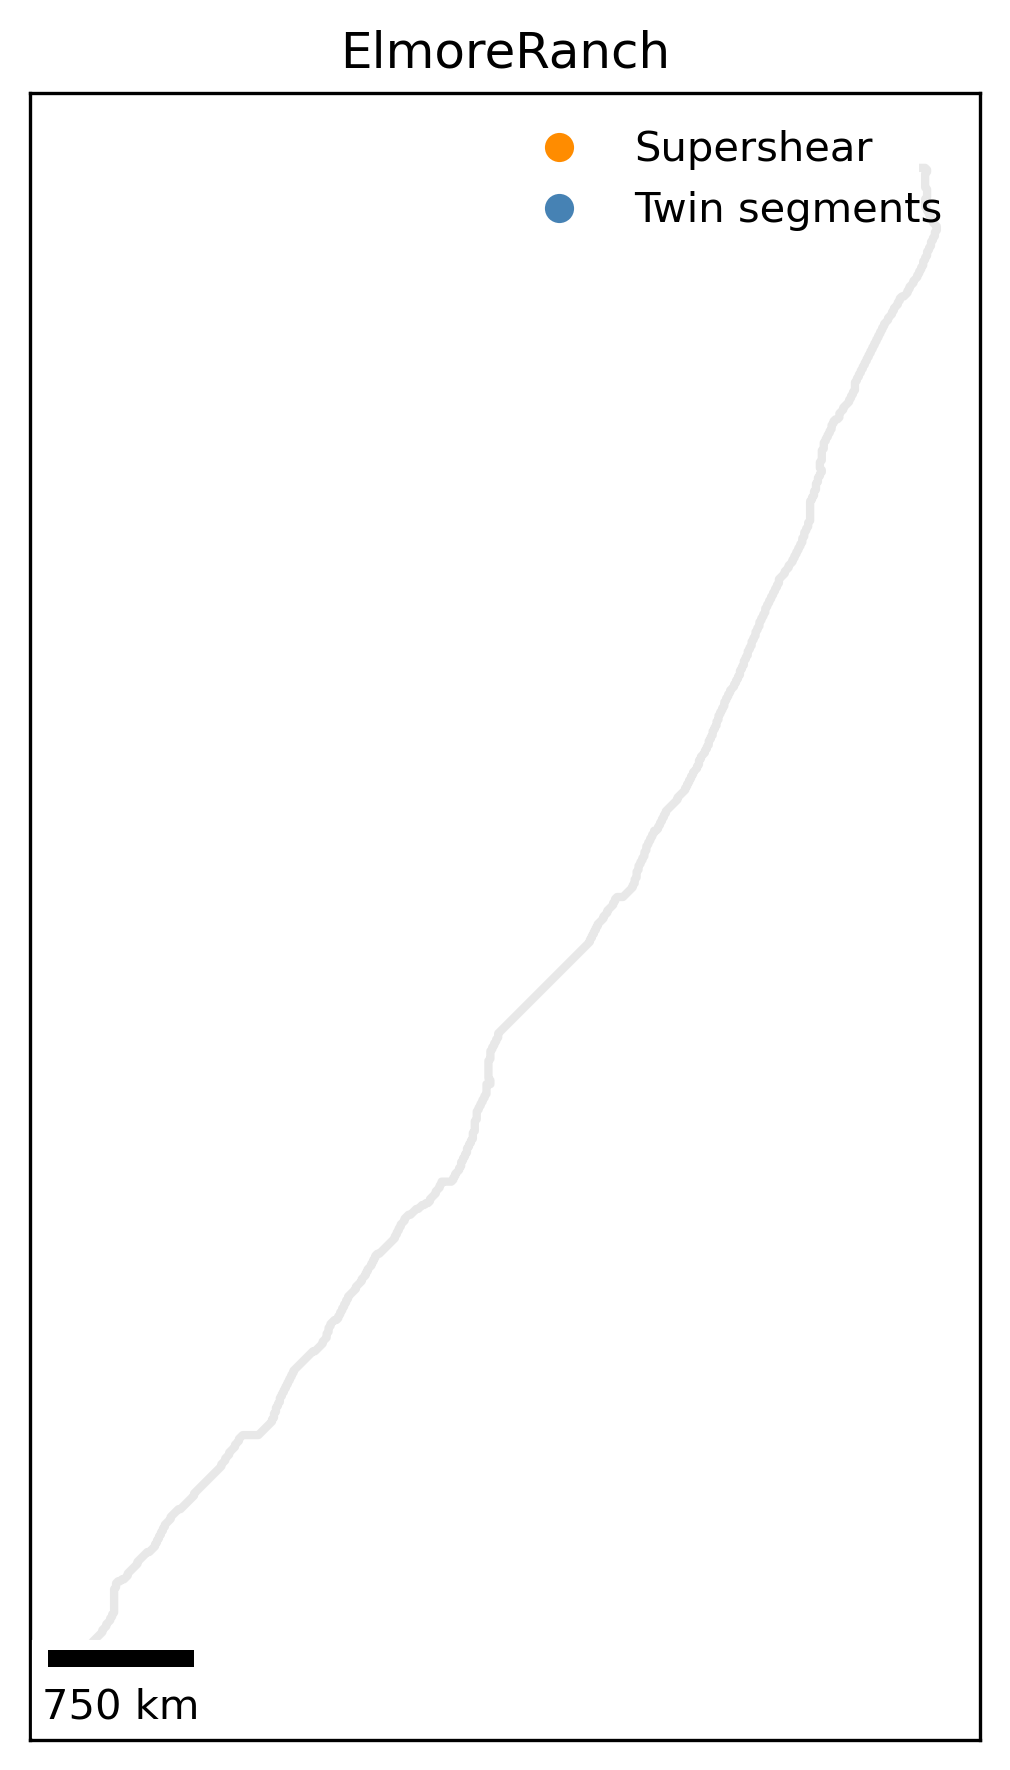

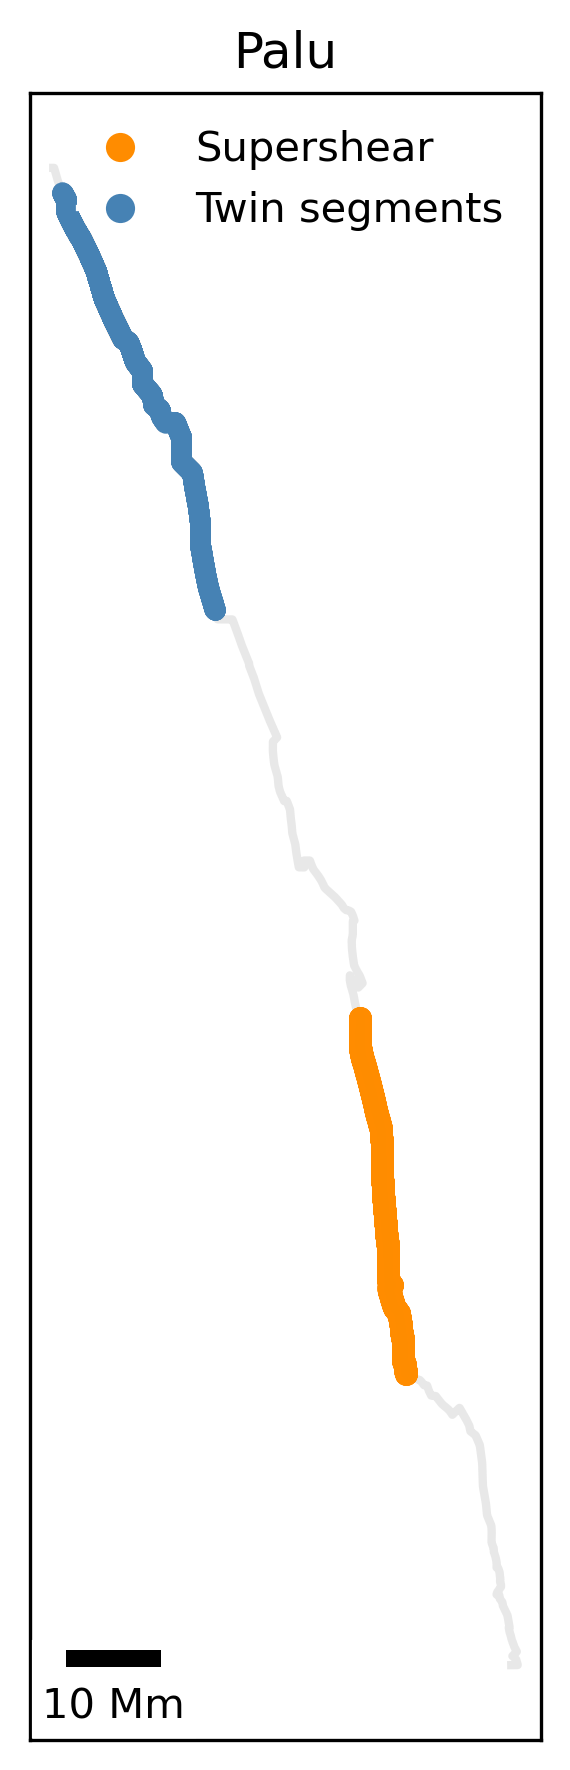

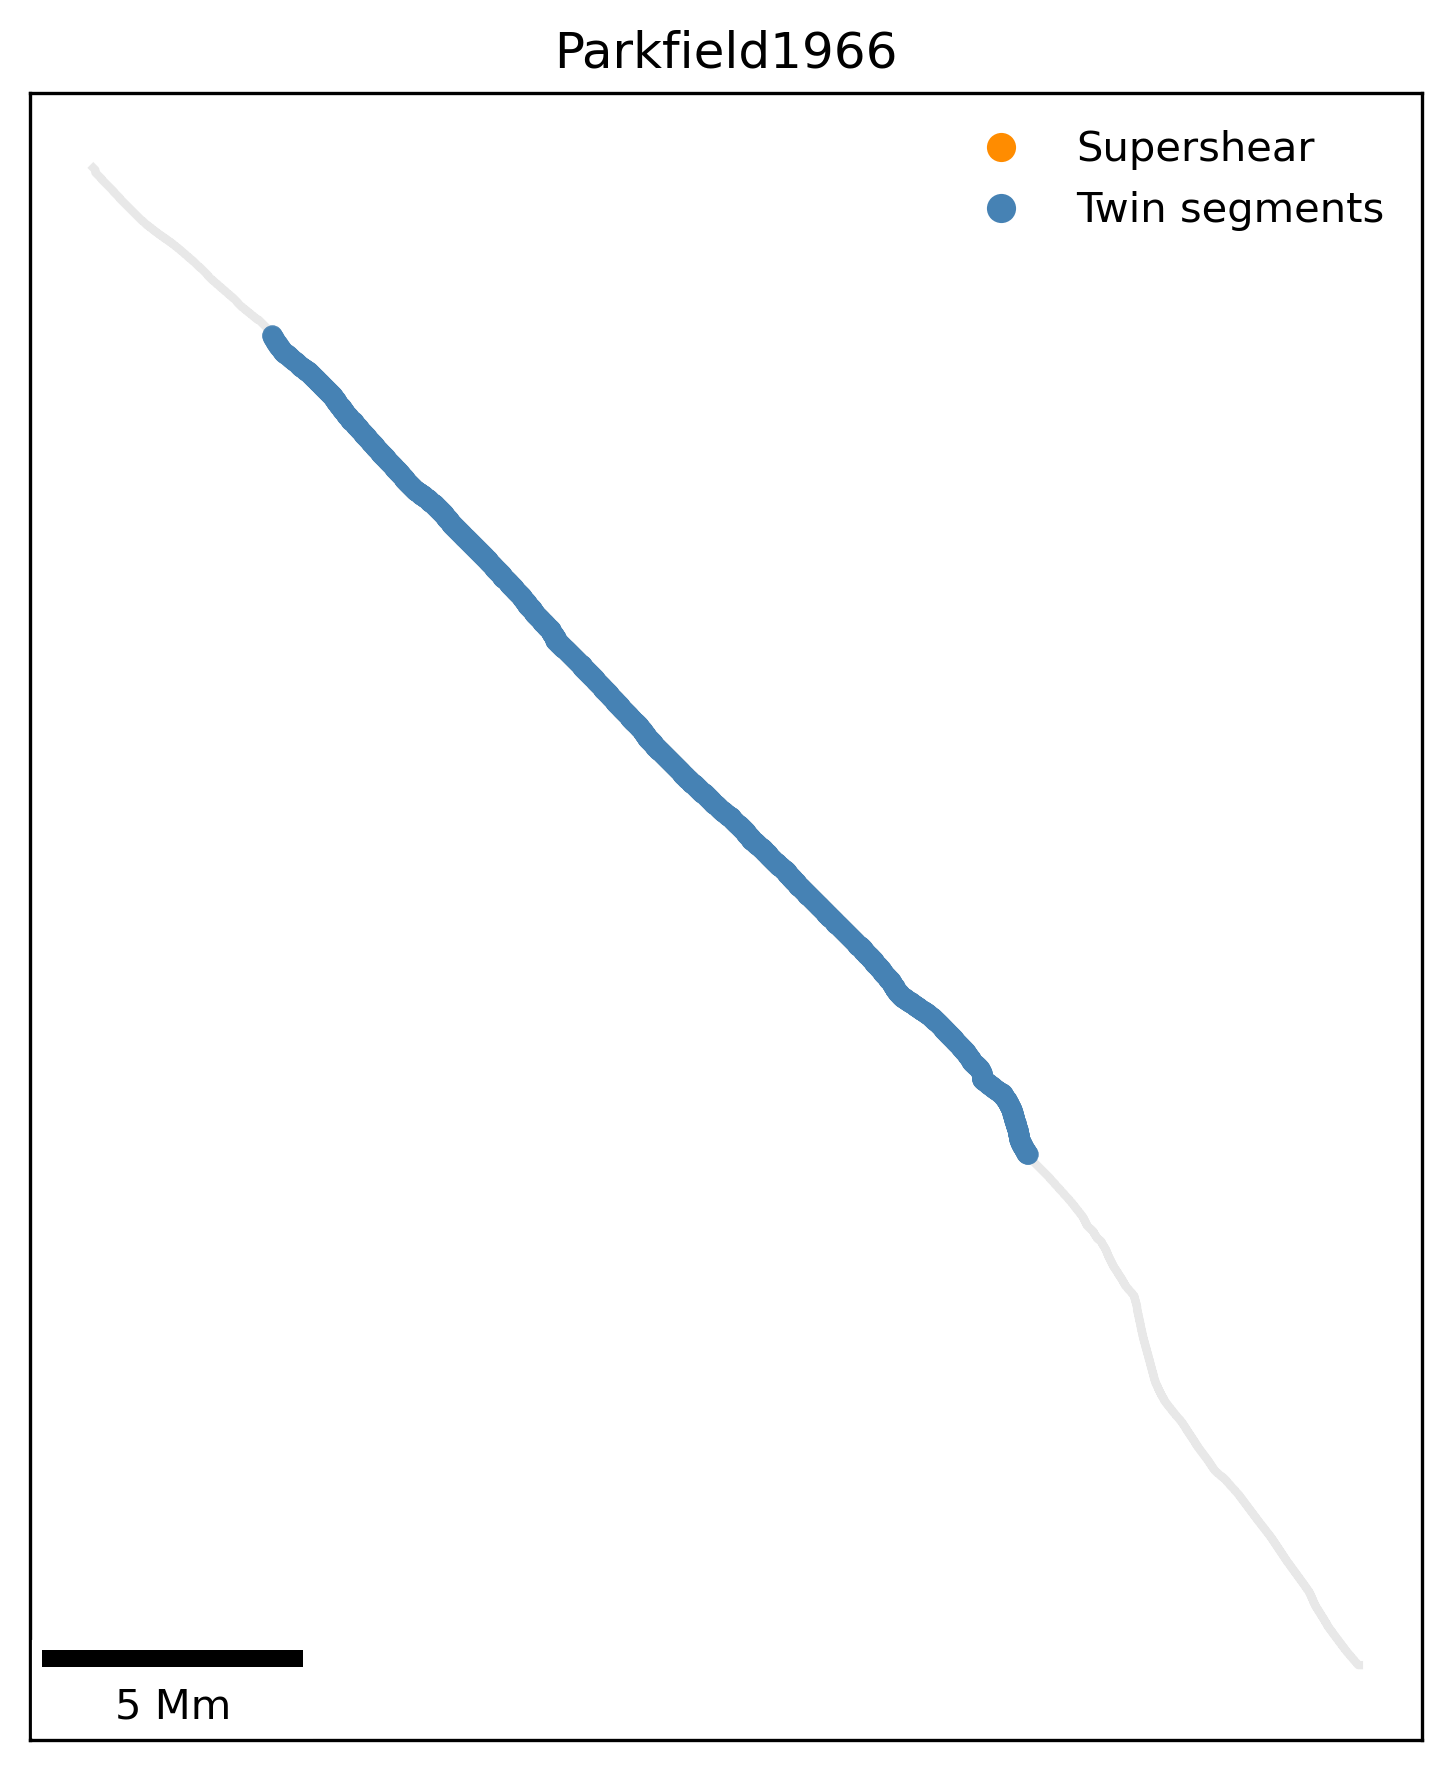

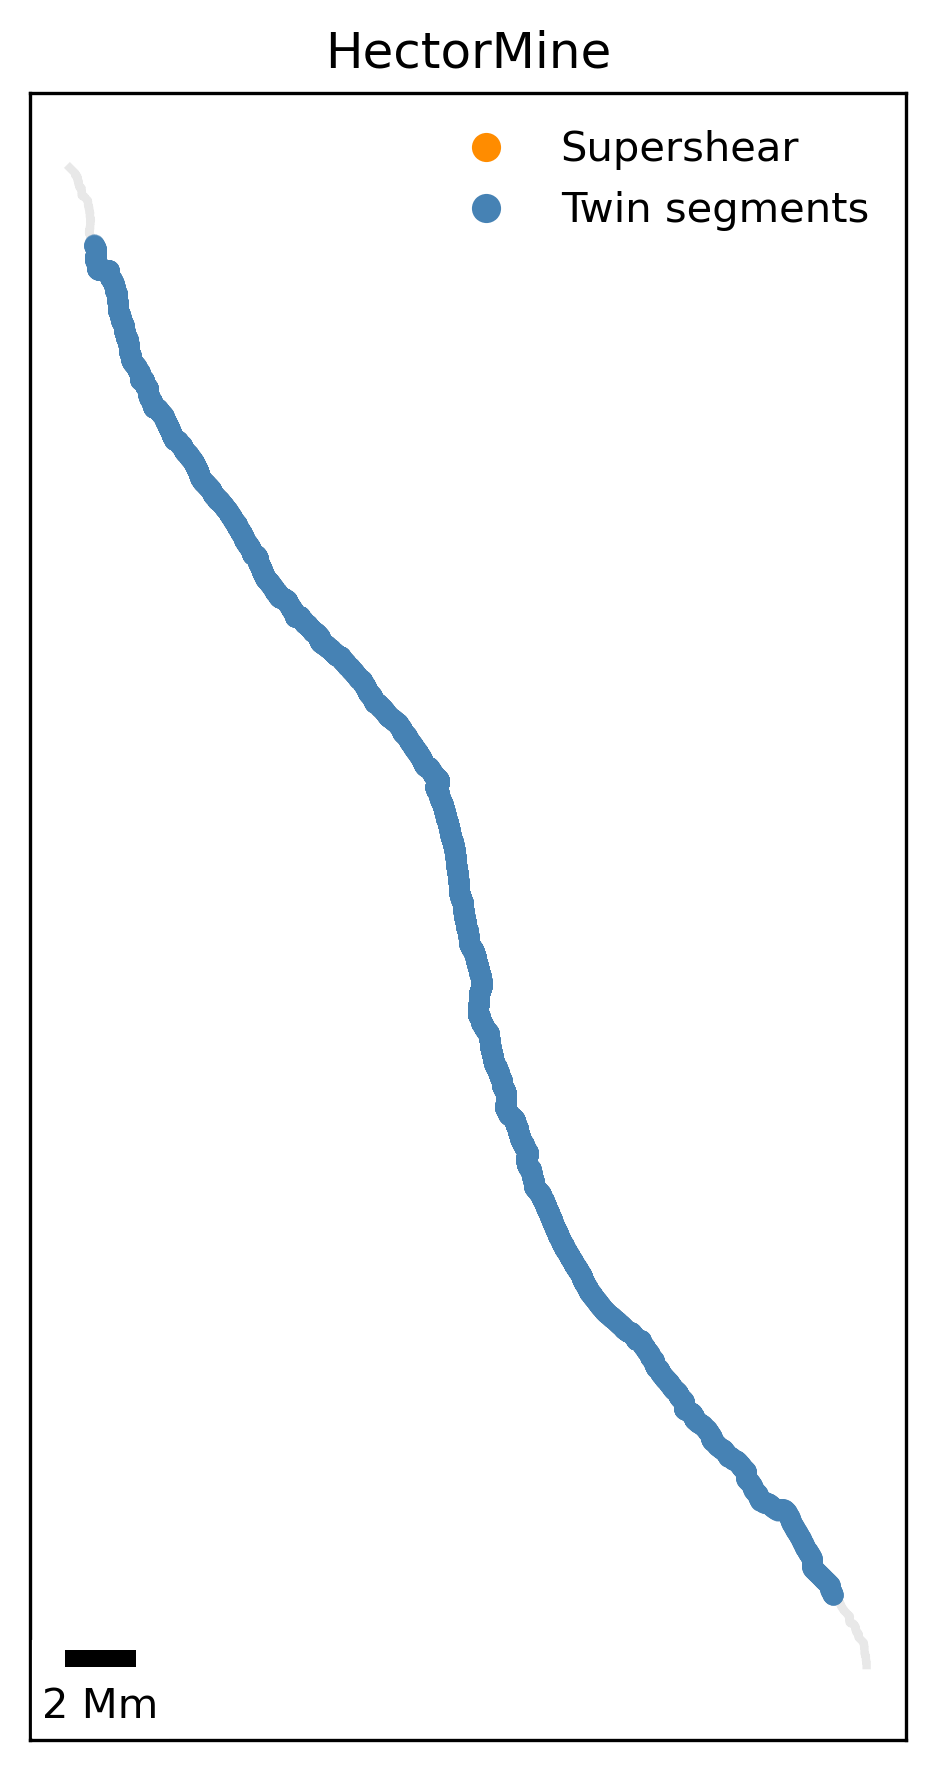

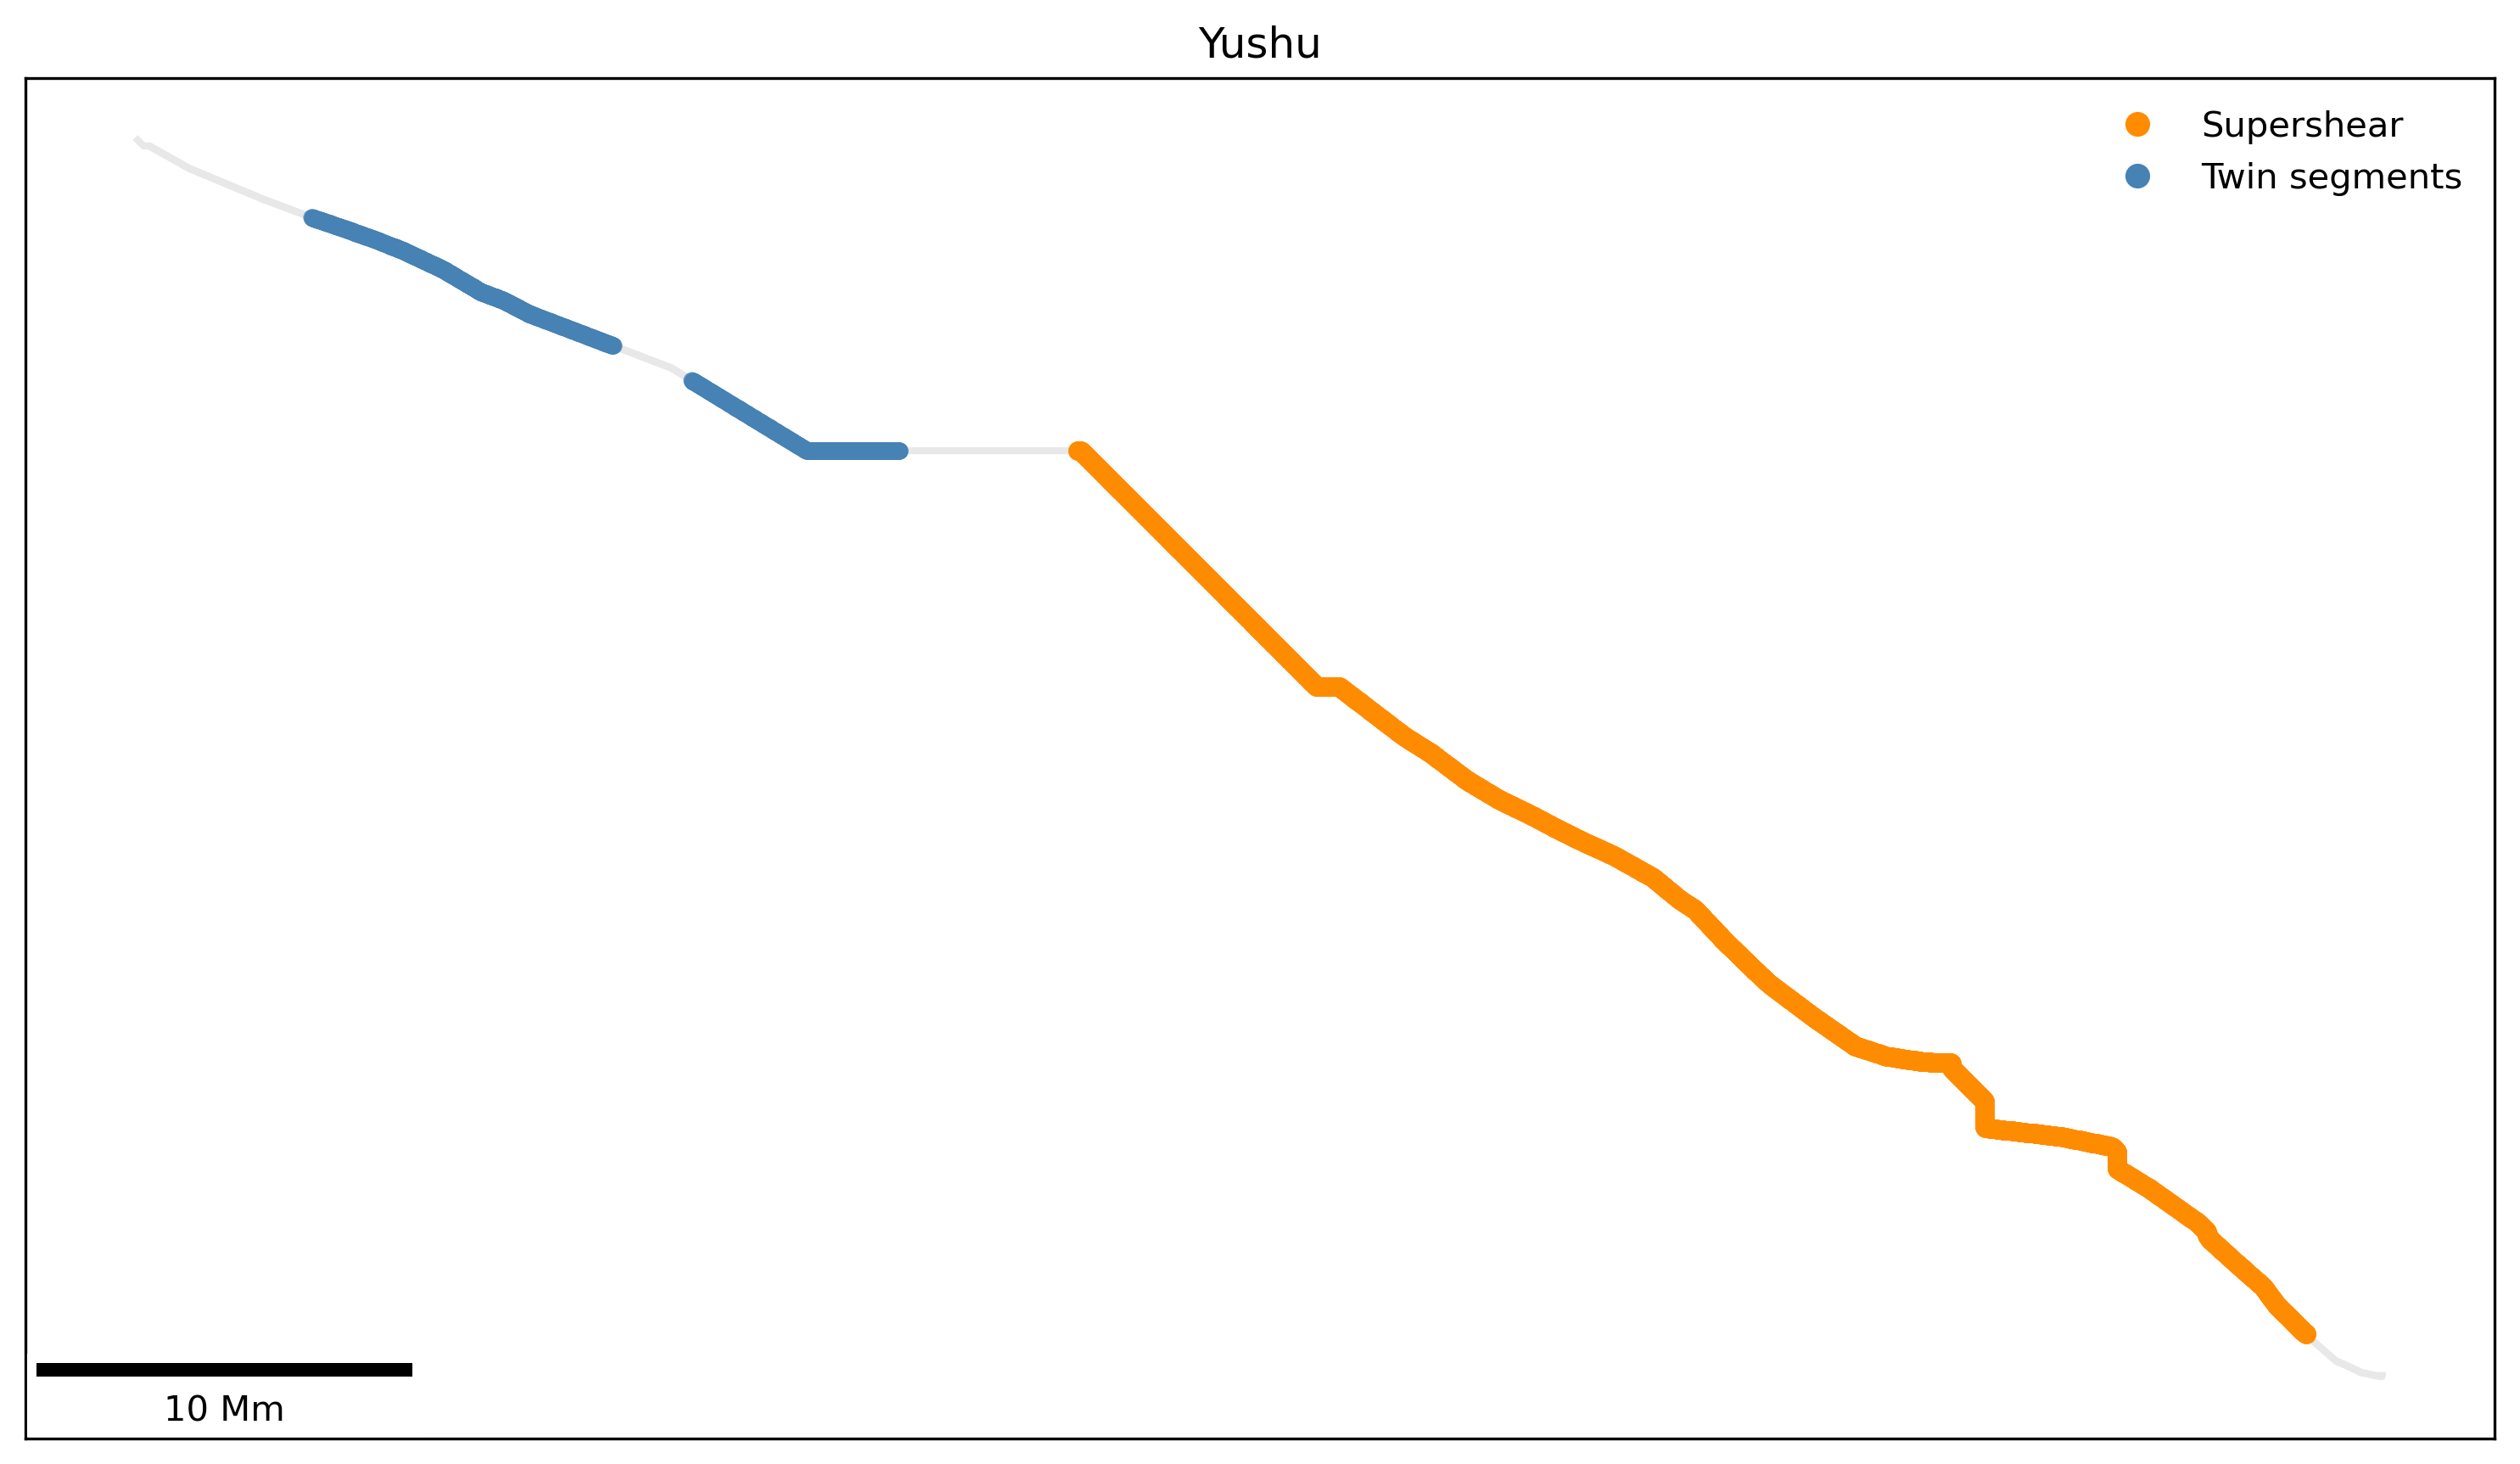

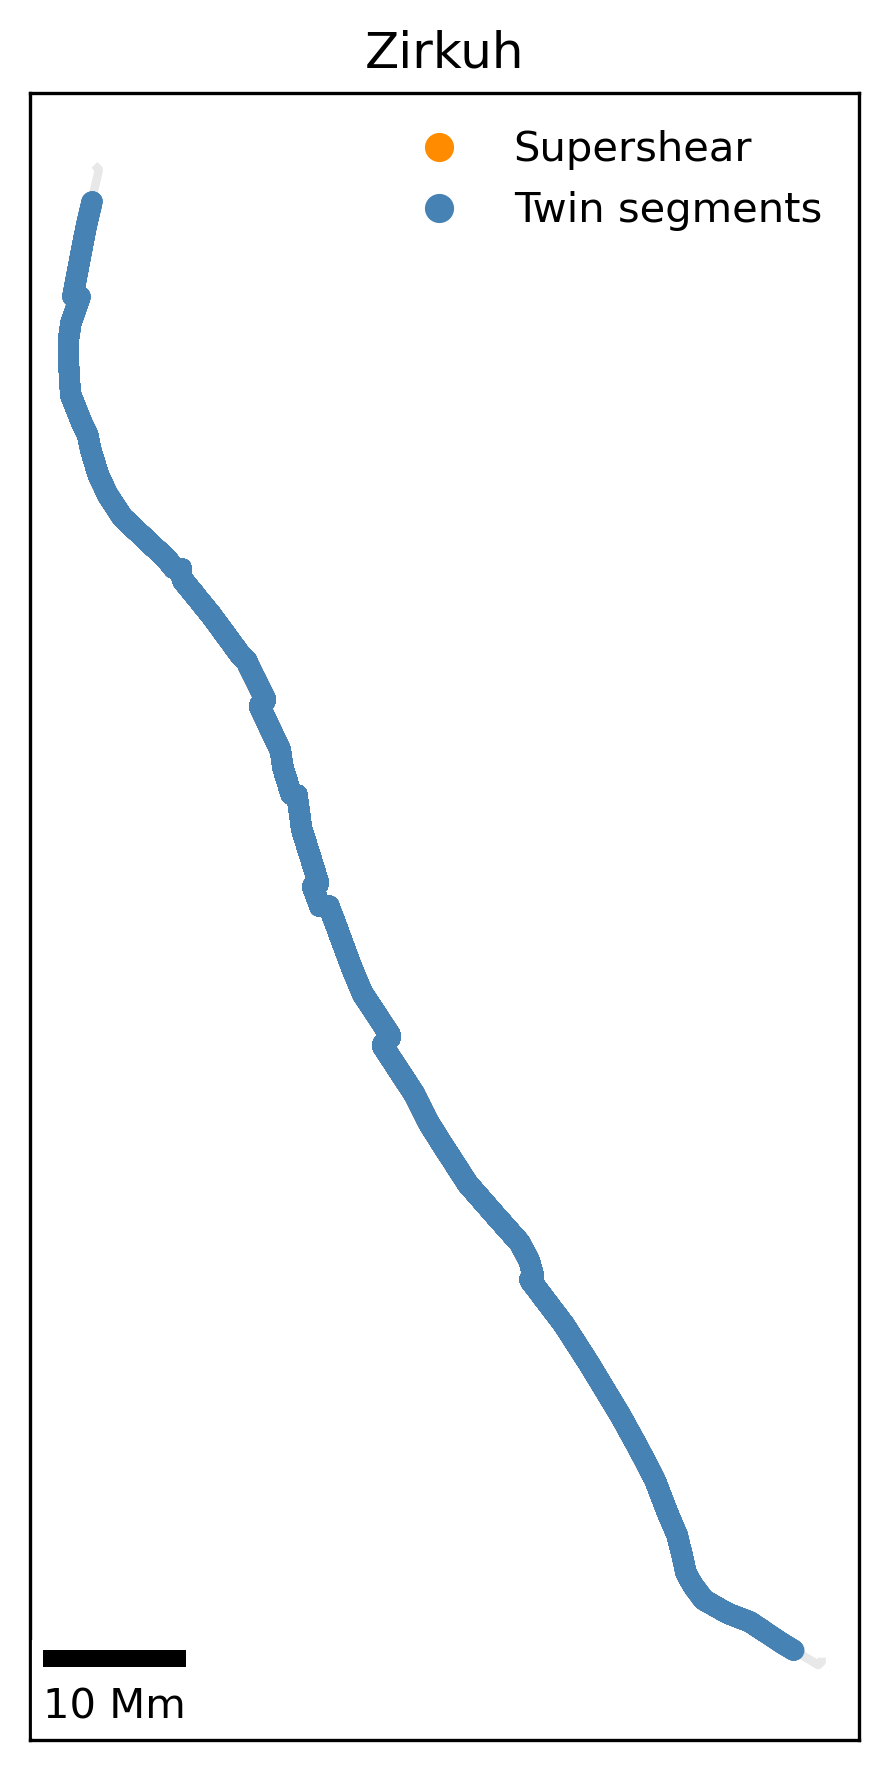

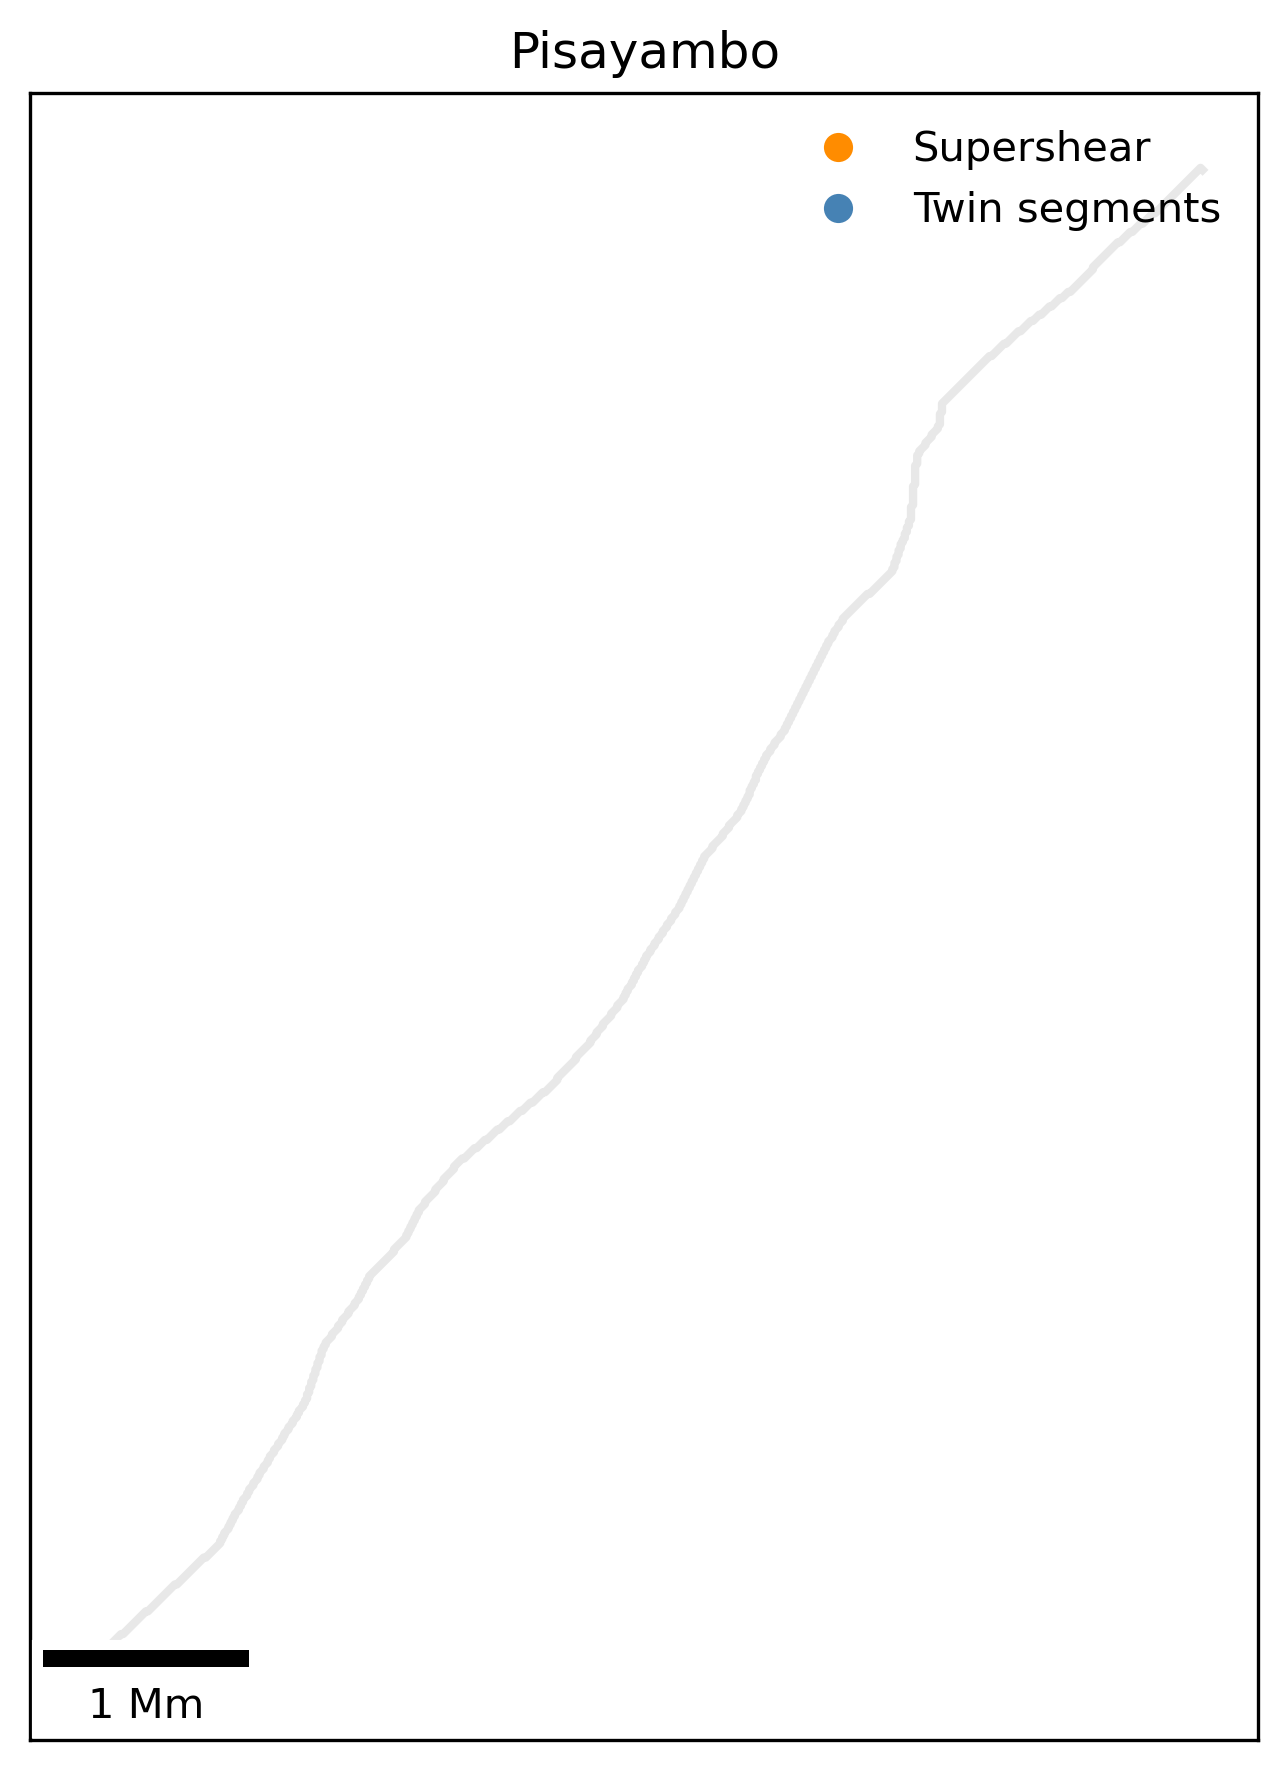

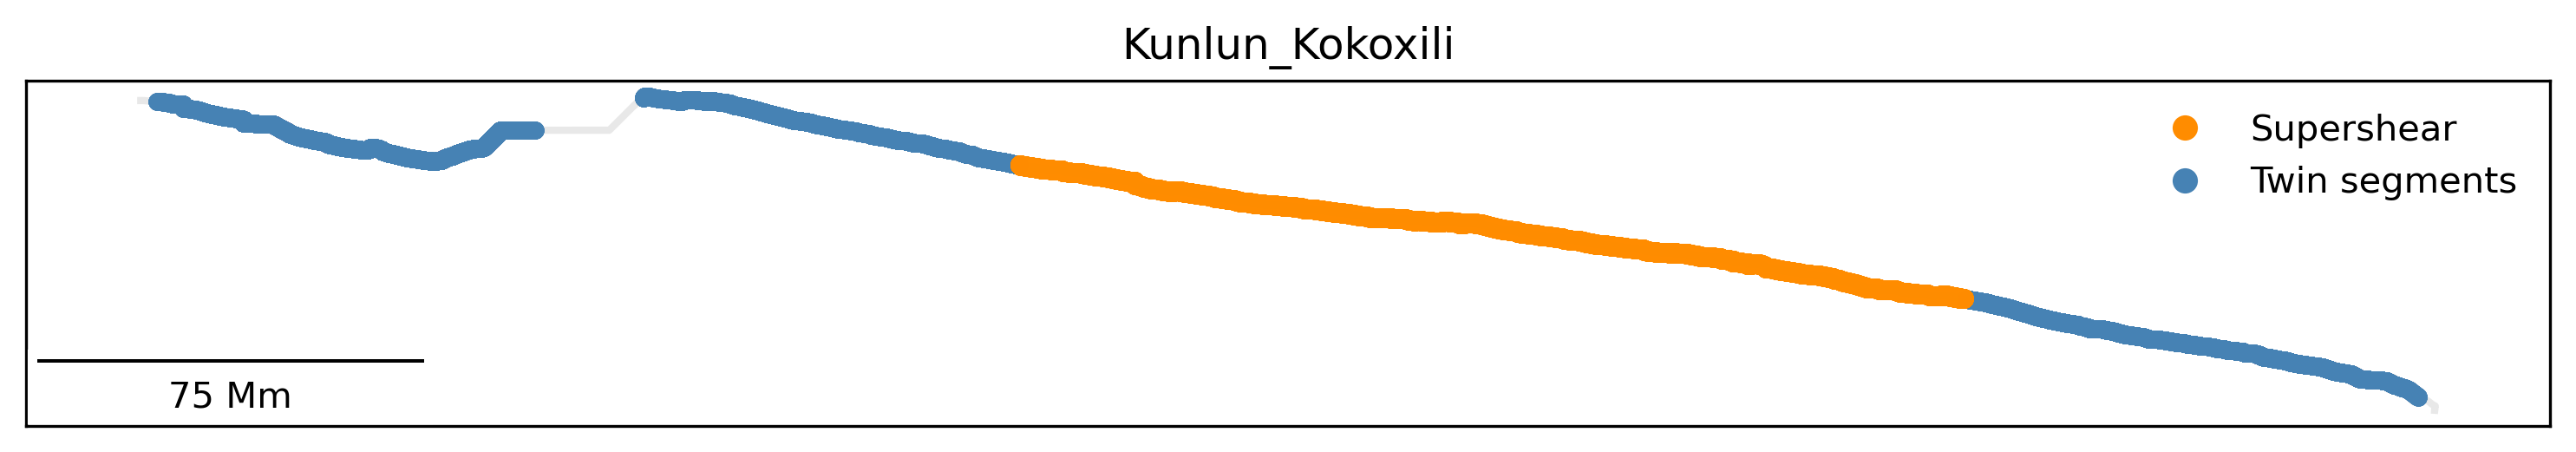

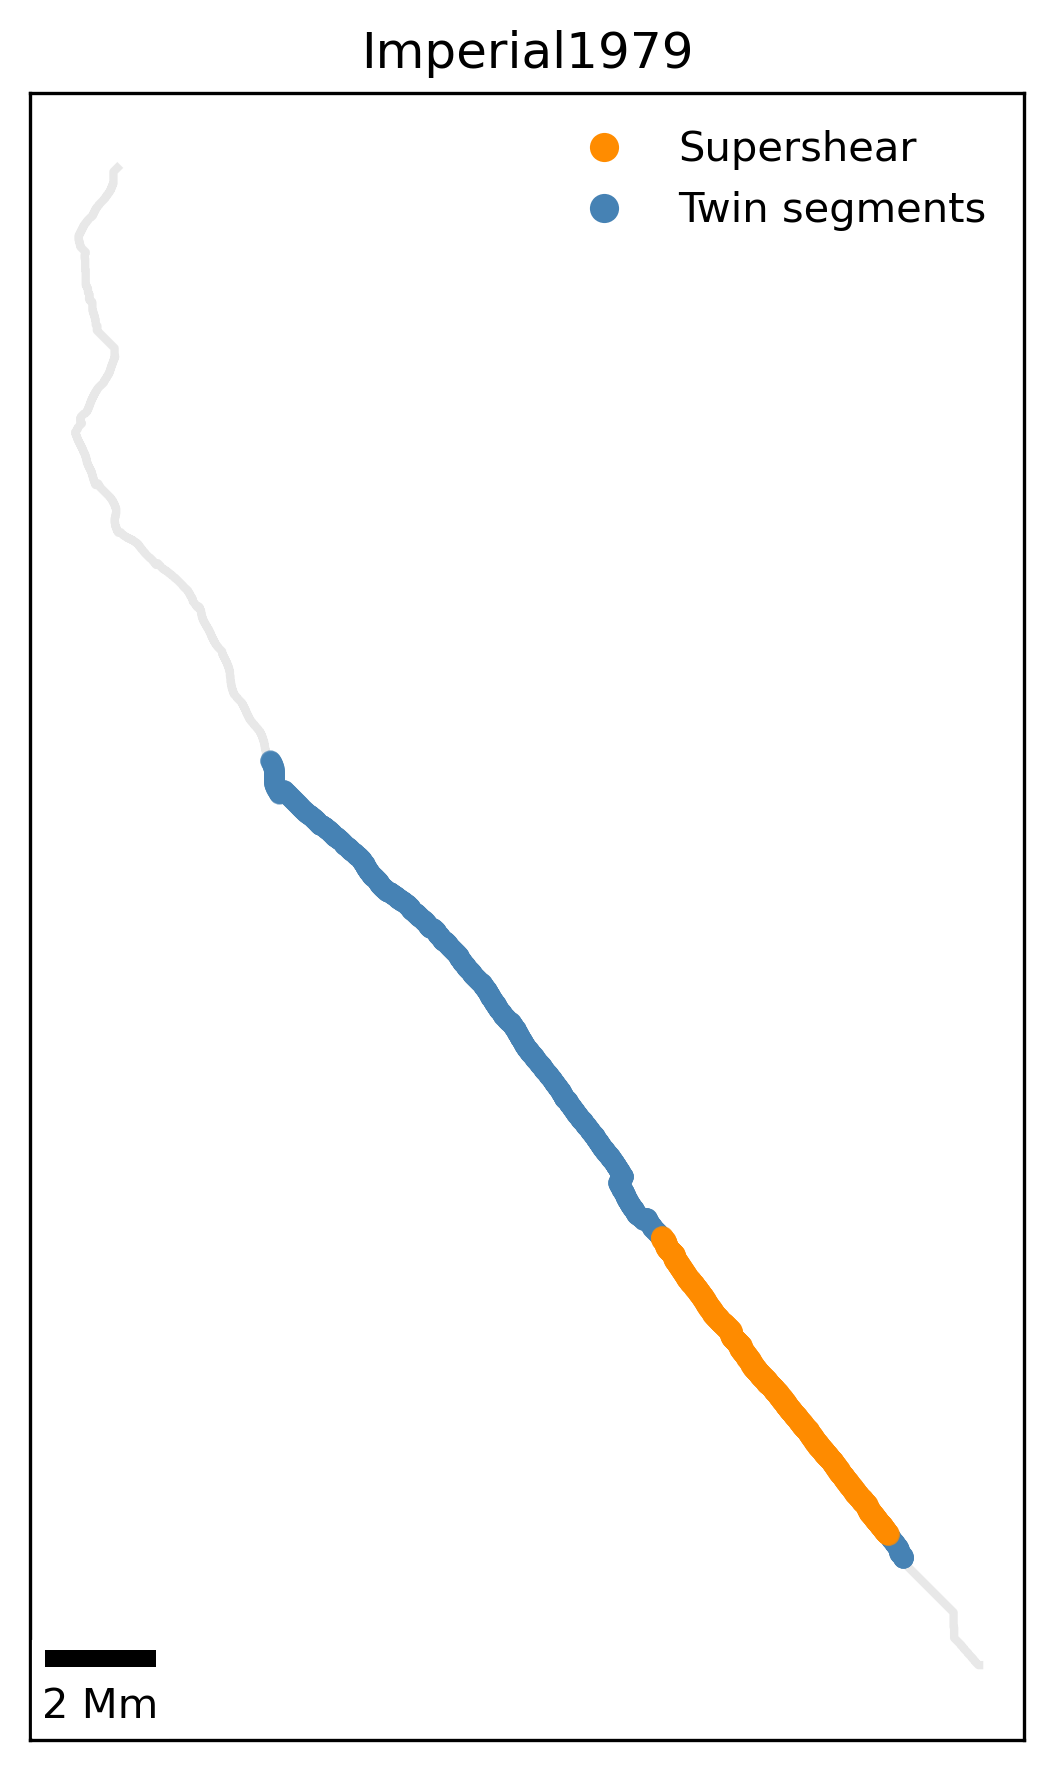

In [55]:
all_events = alpha_data_all_events_segment_type['event'].unique()

for event_name in all_events:
    print(f"\nProcessing {event_name}...")
    
    fig, ax = plt.subplots(figsize=(10, 6), dpi=300)
    
    shp_file = f'Output_LCP/{event_name}_LCP_line.shp'
    gdf = gpd.read_file(shp_file)
    epsg_code = utm_mapping.get(event_name)
    gdf_proj = gdf.to_crs(epsg=epsg_code) if epsg_code else gdf
    
    fault_line = gdf_proj.geometry.iloc[0]
    coords = np.array(fault_line.coords)
    ax.plot(coords[:, 0], coords[:, 1], 'lightgray', linewidth=2, alpha=0.5, zorder=1)

    event_data = alpha_data_all_events_segment_type[alpha_data_all_events_segment_type['event'] == event_name]
    
    supershear_segments = segment_info_df[segment_info_df['event'] == event_name]
    for _, seg in supershear_segments.iterrows():
        mask = (event_data['window_center_position'] >= seg['segment_start_m']) & \
            (event_data['window_center_position'] <= seg['segment_end_m'])
        points = event_data[mask]
        if len(points) > 0:
            ax.scatter(points['utm_x'], points['utm_y'], c='darkorange', s=20, alpha=0.8, zorder=3)
    
    twin_count = 0
    for _, supershear_seg in segment_info_df.iterrows():
        if supershear_seg['event'] != event_name:  # Different event
            twins = supershear_seg['twin_segments']
            if twins:
                for twin in twins:
                    if twin['event'] == event_name:  # This event contributes twins
                        mask = (event_data['window_center_position'] >= twin['start_pos']) & \
                        (event_data['window_center_position'] <= twin['end_pos'])
                        points = event_data[mask]
                        if len(points) > 0:
                            ax.scatter(points['utm_x'], points['utm_y'], c='steelblue', s=15, alpha=0.7, zorder=2)
                            twin_count += 1
                            print(f"  Twin {twin_count}: {event_name} segment {twin['start_pos']:.0f}-{twin['end_pos']:.0f}m "
                                  f"is twin to {supershear_seg['event']} supershear segment "
                                  f"{supershear_seg['segment_start_m']:.0f}-{supershear_seg['segment_end_m']:.0f}m "
                                  f"(length: {supershear_seg['segment_length_km']:.1f} km)")
    
    ax.add_artist(ScaleBar(1, units='km', location='lower left'))
    ax.set_aspect('equal')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f'{event_name}')
    
    legend_elements = [
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='darkorange', markersize=8, label='Supershear'),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='steelblue', markersize=8, label='Twin segments')
    ]
    ax.legend(handles=legend_elements, frameon=False, loc='upper right')
    plt.tight_layout()
    plt.savefig(f'Figures/{event_name}_map_twins_supershear.pdf', dpi=300, bbox_inches='tight')

print("\nAll maps created!")

### Phase boundary of length, alpha, roughness, dist to epi supershear, twin, etc.

In [56]:
# for each segment, catalog length, alpha, distance to epi, type

### Prediction map

In [ ]:
Qfaults_dir = 'Qfaults_GIS/SHP/Qfaults_US_Database.shp'
qfaults_gdf = gpd.read_file(Qfaults_dir)
strike_slip_mask = qfaults_gdf['slip_sense'].isin(['Strike slip', 'Right lateral', 'Left lateral'])
qfaults_SS = qfaults_gdf[strike_slip_mask].copy()

# group by fault zone
qfaults_SS['clean_name'] = qfaults_SS['fault_name'].str.replace(r'\b(fault|zone|faults|zones)\b', '', case=False, regex=True)
qfaults_SS['clean_name'] = qfaults_SS['clean_name'].str.strip().str.replace(r'\s+', ' ', regex=True)
fault_groups = qfaults_SS.groupby('clean_name')


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (2,) + inhomogeneous part.

<Figure size 1920x1440 with 0 Axes>

In [65]:
utm_zones = [
    # Continental US zones
    'EPSG:32610',  # UTM 10N (western US)
    'EPSG:32611',  # UTM 11N (western US)
    'EPSG:32612',  # UTM 12N (western US)
    'EPSG:32613',  # UTM 13N (central US)
    'EPSG:32614',  # UTM 14N (central US)
    'EPSG:32615',  # UTM 15N (central US)
    'EPSG:32616',  # UTM 16N (central US)
    'EPSG:32617',  # UTM 17N (eastern US)
    'EPSG:32618',  # UTM 18N (eastern US)
    'EPSG:32619',  # UTM 19N (eastern US)
    
    # Alaska zones
    'EPSG:32605',  # UTM 5N (western Alaska)
    'EPSG:32606',  # UTM 6N (western Alaska)
    'EPSG:32607',  # UTM 7N (central Alaska)
    'EPSG:32608',  # UTM 8N (central Alaska)
    'EPSG:32609',  # UTM 9N (eastern Alaska)
]

# Create the figure and axis first
fig, ax = plt.subplots(figsize=(16, 10), dpi=300)

# Define fault_groups - UNCOMMENT THIS LINE
fault_groups = qfaults_SS['clean_name'].unique().tolist()

for group_name in fault_groups:
    group_data = qfaults_SS[qfaults_SS['clean_name'] == group_name]
    group_copy = group_data.copy()
    
    group_copy_utm = None
    best_utm = None
    
    for utm_zone in utm_zones:
        try:
            temp_utm = group_copy.to_crs(utm_zone)
            if temp_utm.geometry.length.sum() > 0: # hack to check utm zone works
                group_copy_utm = temp_utm
                best_utm = utm_zone
                break
        except:
            continue
    if group_copy_utm is None:
        group_copy_utm = group_copy
        best_utm = "Original CRS"
    total_length_m = group_copy_utm.geometry.length.sum()
    total_length_km = total_length_m / 1000

# REMOVE THIS LINE - it creates a new figure and overwrites ax
# plt.figure(dpi=300)

for group_name in fault_groups:
    group_data = qfaults_SS[qfaults_SS['clean_name'] == group_name]
    if len(group_data) > 0:
        group_data.plot(ax=ax, linewidth=2, alpha=0.8, label=group_name)

ax.set_aspect('equal')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()


/var/folders/kg/j5ms0y1x28l_gm2jtsf5j4pr0000gn/T/ipykernel_43014/3505002905.py:60: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()
